# Credit Risk Modelling with Lending Club Data

# Executive Summary

# Outline

**Introduction**

**Phase 1: Data Ingestion & Quality**
- Ingest raw CSV
- Converting Datatypes
- Appending Economic Data
- Censoring Late Vintages
- Altering Class Distribution
- Flag Defaults and Event Timing
- Creating Credit_Age Variable
- Data Quality Checks (outliers, missingness, logical constraints)
- Create a data quality report
  
**Phase 2: Preprocessing**
- Defining Numerical and Categorical Variables
- Processing Categorical Variables
- Clipping Outliers
- Applying Transformations
- Imputing Missing Values
- One-Hot Encoding Categorical Variables
- Checking for Multicollinearity
- Applying Standard Scaling
- Splitting dataset into training, validation and testing datasets
  
**Phase 3: PD Model Training**
- Setup (Importing Functions and Defining Functions)
- Linear Discriminant Analysis Model
- Probit Model
- Logistic Regression Model
- Decision Tree Model
- Random Forest Model
- Comparing Models

**Phase 4: EAD & LGD Estimation**
- Creating Portfolio Dataset
- Exploring Portfolio Dataset
- Preprocessing Portfolio Dataset
- Calculating Exposure At Default
- Calculating Loss Given Default

**Phase 5: Scenario Analysis and Expected Credit Loss Calculation**
- Defining Scenarios
- Calculating ECL for Each Scenario

**Phase 6: VaR and CVaR**
- Monte Carlo Simulation for VaR and CVaR

**Conclusion**

# Introduction

The objective of this project is to design and implement an IFRS 9 / Basel-compliant credit risk modelling framework for retail, P2P loans leveraging the historical Lending Club dataset enriched with macroeconomic indicators. This framework will estimate Probability of Default (PD), Exposure at Default (EAD), Loss-Given Default (LGD) and compute the Expected Credit Loss (ECL) under multiple scenarios. Additionally, this project incorporates Monte Carlo simulations to quantify portfolio tail-risk through Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR).

**Goal**

Build an end-to-end pipeline for:
- Ingesting, manipulating and preprocessing large datasets.
- PD Modelling using statistical and machine learning (ML) approaches.
- EAD and LGD estimations based on loan amortization and recovery data.
- ECL computation for 12-month horizon and under different scenarios.
- Portfolio loss simulation for risk quantification.

**Scope**
- Preprocessing: Prepare large-scale and uncleaned datasets to be used in ML and statistical models by handling common issues such as unbalanced features, categorical data, outliers, skewness, missing data, encoding, multicollinearity and standard scaling.
- Modelling: Compare performance of traditional statistical models (Logistic Regression, Linear Discriminant Analysis (LDA), Probit) with machine learning models (Decision Trees, Random Forests) for PD estimation
- Stress Testing - Applying macroeconomic shocks (GDP and unemployment) and borrower-level overlays (income reduction, dti increase, interest rate increase, utilization increase) to assess portfolio resilience.
- Risk Metrics - Use Monte Carlo simulations to estimate VaR and CVaR under baseline and stressed conditions.

**Dataset**

- Source : Lending Club dataset, World Bank Development Indicators
- Features :
    - Loan-level: loan_status, annual_inc, dti, verification_status, revol_util, purpose, loan_amnt, int_rate, term, issue_d, last_pymnt_d, funded_amnt, total_pymnt, installment.
    - Recovery / Settlement: out_prncp, recoveries, collection_recovery_fee, settlement_amount, settlement_percentage, settlement_status, settlement_term, hardship_flag, hardship_status.
    - Behavioural / Bureau: emp_length, home_ownership, deling_2yrs, inq_last_6mths, open_acc, earliest_cr_line, mort_acc, avg_cur_bal, pub_rec_bankruptcies.
- Target : default_12m (default or charge-off within 12 months of origination)
- Combined these datasets enable robust credit risk analytics

# Phase 1: Data Ingestion

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import gc
from textwrap import fill
import matplotlib as mpl

## Customize Settings

In [2]:
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_columns", None)

## Ingesting Lending Club Dataset

**Overview and Background**

The Lending Club is a leading peer-to-peer lending platform in the US and the first P2P lender to be registered with the Securities and Exchange Comission (SEC). Lending Club connects borrowers seeking personal loans with investors. Investors would be able to browse and select loans they would like to invest in based on information provided by the borrower. Loans usually range from  USD 1,000 to US 40,000 with the standard loan period being 3 years. Borrowers benefit from typically lower loan rates and investors benefits from higher returns, while Lending Club profited from various fees charged to borrowers and investors. However, in 2020, the P2P platform was shutdown. Despite this, the loan data still remains includes borrower demographics, loan-level information, credit attributes, loan terms, performance outcomes and recovery data. There are a total of 2.3 million loan records with over 75 variables with a time horizon from June 2007 until December 2017. This rich dataset will form the basis for modelling of PD, EAD, LGD and ECL.

**Key Variables**

Out of these 75 variables, only 32 will be critical in assessing the credit-worthiness and modelling default risk:
- _loan_status_ : Current status of the loan (e.g., Fully Paid, Charged Off, Default).
- _annual_inc_ : Borrower’s self-reported annual income.
- _dti_ : Debt-to-Income ratio, calculated as monthly debt obligations divided by monthly income.
- _verification_status_ : Indicates whether income was verified by LendingClub.
- _emp_length_ : Employment length in years (bucketed: 0–3, 4–6, 7–9, 10+).
- _home_ownership_ : Borrower’s home ownership status (RENT, OWN, MORTGAGE).
- _delinq_2yrs_ : Number of 30+ day delinquencies in past 2 years.
- _inq_last_6mths_ : Credit inquiries in the past 6 months.
- _open_acc_ : Number of open credit lines.
- _revol_util_ : Revolving credit utilization rate (% of available credit used).
- _earliest_cr_line_ : Date of borrower’s earliest credit line.
- _purpose_ : Loan purpose category (e.g., debt consolidation, credit card, home improvement).
- _loan_amnt_ : Original loan amount requested.
- _int_rate_ : Interest rate on the loan.
- _term_ : Loan term in months (36 or 60).
- _mort_acc_ : Number of mortgage accounts.
- _avg_cur_bal_ : Average current balance across accounts.
- _pub_rec_bankruptcies_ : Number of public record bankruptcies.
- _issue_d_ : Loan origination date.
- _last_pymnt_d_ : Date of last payment received.
- _funded_amnt_ : Amount funded by investors.
- _out_prncp_ : Remaining outstanding principal.
- _total_pymnt_ : Total payments received to date.
- _installment_ : Monthly payment amount.
- _recoveries_ : Post-charge-off recoveries.
- _collection_recovery_fee_ : Fees associated with recovery efforts.
- _settlement_amount_ / _settlement_percentage_ / _settlement_status_ / _settlement_term_ : Details of any settlement plan agreed upon after charge-off.
- _hardship_flag_ / _hardship_status_ : Indicates if borrower is on a hardship plan.

**Source**: https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv

In [3]:
total_var = ["loan_status", "annual_inc", "dti", "verification_status", "emp_length", "home_ownership", "delinq_2yrs", "inq_last_6mths", "open_acc", "revol_util", 
              "earliest_cr_line", "purpose", "loan_amnt", "int_rate", "term", "mort_acc", "avg_cur_bal", "pub_rec_bankruptcies", "issue_d", "last_pymnt_d", "funded_amnt", 
              "out_prncp", "total_pymnt", "installment", "recoveries", "collection_recovery_fee", "settlement_amount", "settlement_percentage", "settlement_status", 
              "settlement_term", "hardship_flag", "hardship_status"]

Since the dataset is so large with over 2.3 million rows, the dataset will be loaded in chunks and then concatenated together

In [4]:
# Adjusting data and defining chunksize
csv_path = "loan.csv"
header_cols = pd.read_csv(csv_path, nrows=0).columns.tolist()
usecols = [c for c in total_var if c in header_cols]
chunksize = 250_000 
frames = []
reader = pd.read_csv(csv_path, usecols=usecols, chunksize=chunksize, low_memory=False)

# Ingesting data by chunks
for i, chunk in enumerate(reader):
    frames.append(chunk)  # collect for final concatenation
    mem_mb = chunk.memory_usage(deep=True).sum() / 1024**2
    print(f"Chunk {i} → {len(chunk):,} rows, ~{mem_mb:.1f} MB")
    gc.collect()

# Combining chunks into final dataframe
df = pd.concat(frames, ignore_index=True)
del frames
gc.collect()

Chunk 0 → 250,000 rows, ~189.5 MB
Chunk 1 → 250,000 rows, ~189.5 MB
Chunk 2 → 250,000 rows, ~190.3 MB
Chunk 3 → 250,000 rows, ~190.3 MB
Chunk 4 → 250,000 rows, ~190.5 MB
Chunk 5 → 250,000 rows, ~190.2 MB
Chunk 6 → 250,000 rows, ~190.1 MB
Chunk 7 → 250,000 rows, ~190.4 MB
Chunk 8 → 250,000 rows, ~190.1 MB
Chunk 9 → 10,668 rows, ~8.1 MB


0

In [5]:
def Plot_Dtype_Summary(
    df: pd.DataFrame,
    group=False,
    figsize=(14, 8),
    sort='desc',
    max_line_width=70
):

    # 1) Build dtype counts and mapping: dtype -> [columns]
    dtype_series = df.dtypes

    if group:
        def group_dtype(dtype):
            dt = str(dtype)
            if 'int' in dt or 'float' in dt or 'complex' in dt:
                return 'numeric'
            elif 'datetime' in dt:
                return 'datetime'
            elif 'timedelta' in dt:
                return 'timedelta'
            elif dt == 'bool':
                return 'bool'
            elif dt == 'category':
                return 'category'
            elif dt == 'object':
                return 'object'
            else:
                # fallback to the plain string (e.g., 'string[python]', 'Int64', etc.)
                return dt

        grouped = dtype_series.map(group_dtype)
        counts = grouped.value_counts()
        groups = {g: df.columns[grouped == g].tolist() for g in counts.index}
    else:
        # keep exact dtypes (e.g., 'int64', 'float64', 'object')
        counts = dtype_series.value_counts()
        groups = {str(dt): dtype_series.index[dtype_series == dt].tolist() for dt in counts.index}

    # 2) Optional sorting
    if sort == 'desc':
        counts = counts.sort_values(ascending=False)
    elif sort == 'asc':
        counts = counts.sort_values(ascending=True)

    dtype_names = counts.index.astype(str)
    dtype_counts = counts.values

    # 3) Layout: bar chart (left) + text panel (right)
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[2.0, 3.0])
    ax_bar = fig.add_subplot(gs[0])
    ax_text = fig.add_subplot(gs[1])

    # 4) Bar chart with labels
    bars = ax_bar.bar(dtype_names, dtype_counts, color="#4C78A8")
    ax_bar.set_title("Number of columns by dtype", fontsize=13)
    ax_bar.set_ylabel("Count", fontsize=11)
    ax_bar.tick_params(axis='x', labelrotation=30)
    ax_bar.bar_label(bars, padding=3, fontsize=10)  # data labels on bars

    # 5) Right panel: list variables for each dtype
    ax_text.axis('off')

    # Adjust y decrement to avoid overlap; increase figure height if text is long.
    y = 0.98
    header_fs = 12
    body_fs = 10
    line_gap = 0.04  # gap between lines

    for dtype_name in dtype_names:
        cols = groups[str(dtype_name)]
        # section header: dtype + count
        ax_text.text(0.0, y, f"{dtype_name} ({len(cols)})", fontsize=header_fs, fontweight="bold",
                     va="top", ha="left", transform=ax_text.transAxes)
        y -= line_gap

        if cols:
            # wrap long lists to keep them readable
            text = ", ".join(cols)
            wrapped = fill(text, width=max_line_width)
            ax_text.text(0.0, y, wrapped, fontsize=body_fs, va="top", ha="left",
                         transform=ax_text.transAxes)
            # estimate vertical space consumed by the wrapped text
            consumed_lines = wrapped.count("\n") + 1
            y -= consumed_lines * (line_gap * 0.9)

        # extra spacing between dtype sections
        y -= (line_gap * 0.6)

    fig.suptitle(f'Total Columns: {df.shape[1]} | Total Observations: {df.shape[0]:,.0f}',
                 fontsize = 14,
                 fontweight = "bold",
                 y = 1.02)
    
    fig.tight_layout()
    return fig, (ax_bar, ax_text)

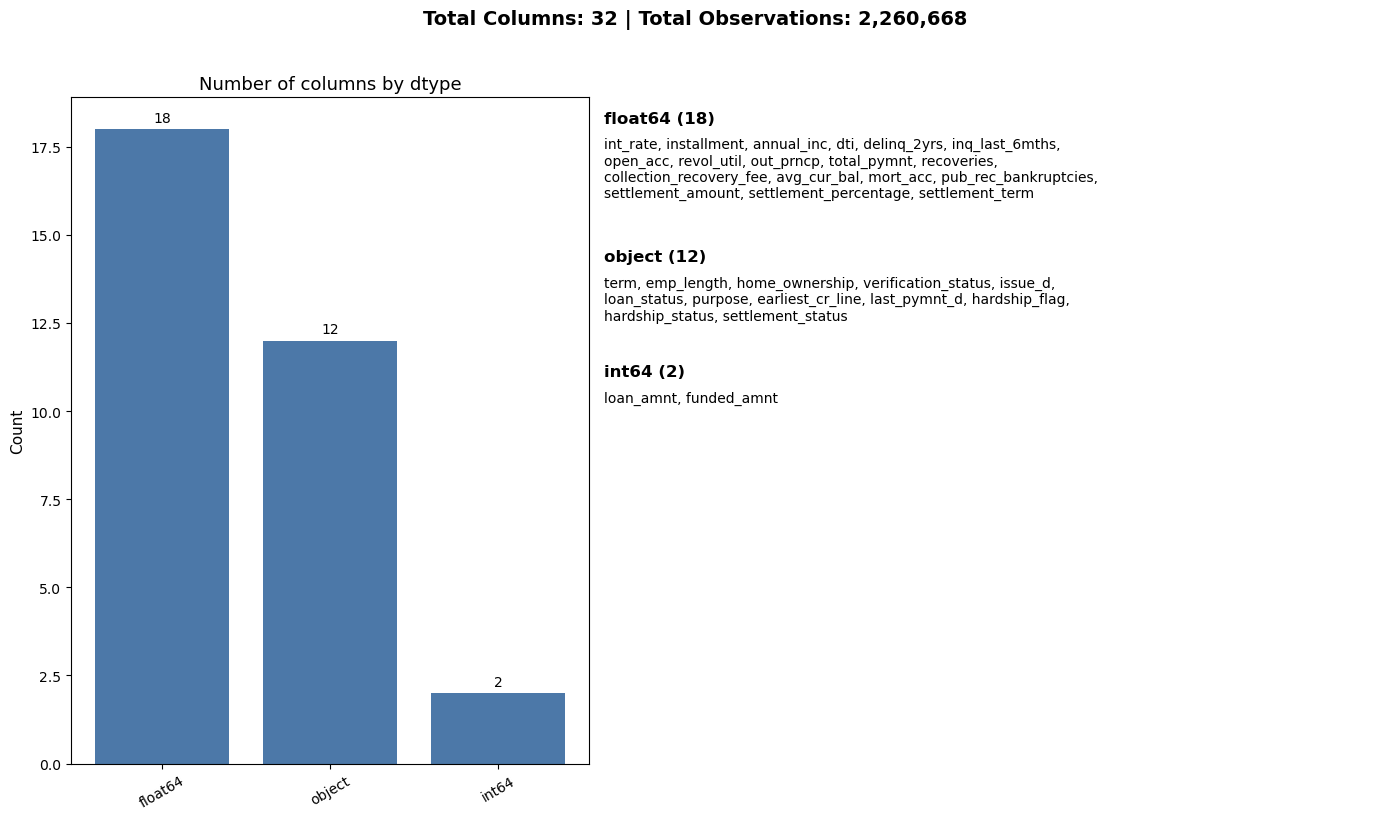

In [6]:
Plot_Dtype_Summary(df)
plt.show()

Variables with float64 and int64 will be converted into float32 and int32 respectively. This will essentially halve the amount of processing required.

In [7]:
# Converting variables from 64bit to 32bit
df = df.astype({col: "float32" for col in df.select_dtypes("float64").columns})
df = df.astype({col: "int32" for col in df.select_dtypes("int64").columns})

Date variables will be converted into datetime format

In [8]:
# Converting date variables into datetime
date_var = ["issue_d", "last_pymnt_d", "earliest_cr_line"]

for i in date_var:
    df[i] = pd.to_datetime(df[i], format = "%b-%Y")

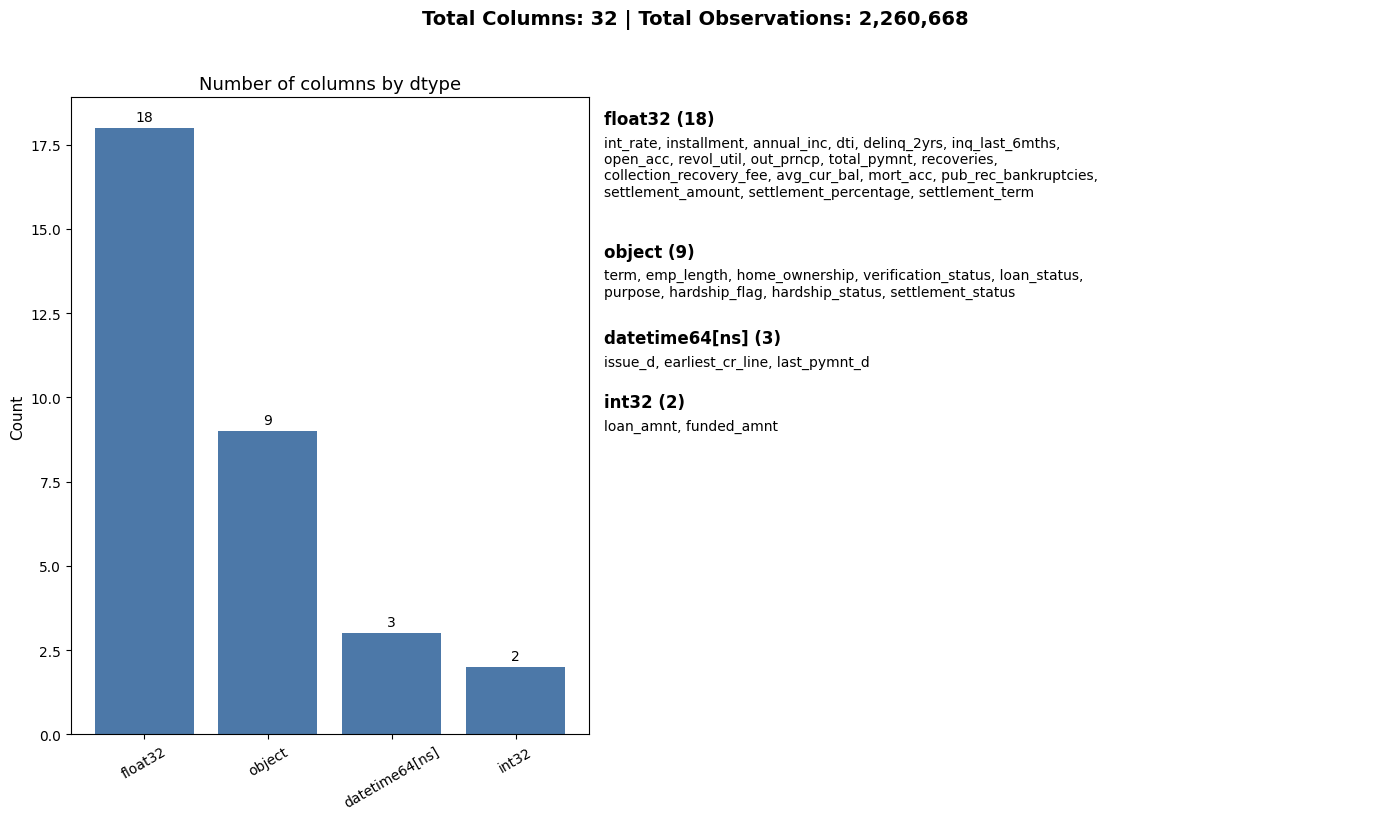

In [9]:
Plot_Dtype_Summary(df)
plt.show()

## World Bank Economic Data Enrichment

**Overview and Background**

For future stress-testing and scenario analysis, macroeconomic data is essential to mimic the impact of real-world scenarios. Thus, US economic data from the World Bank will be appended to the data based on the year of issue date (issue_d). The World Development Indicators (WDI) is the World Bank's premier compilation of internationally comparable data on global developement and macroeconomic events. Only data from 2007 until 2018 will be used to keep in line with the Lending Club time horizon. 

**Key Variables**

The key macroeconomic variables include:
- _GDP_growth_rate_: Annual percentage change in Gross Domestic Product, reflects economic expansion or contraction.
- _infl_rate_ : Inflation rate, indicates changes in consumer prices.
- _real_int_rate_ : Interest rate of the wider economy adjusted for inflation, impacts borrowing costs.
- _UE_rate_ : Unemployment rate, a key driver of borrower repayment capacity.

**Source**: https://databank.worldbank.org/source/world-development-indicators

In [10]:
#Ingesting the Economic Data and deleting the first 3 rows.
Econ_df = pd.read_csv("US_Economic_Data.csv").loc[:3]

#Isolating the relevant columns
Econ_df = Econ_df[["Series Name"] + [col for col in Econ_df.columns if col.startswith("20")]]

Econ_df

Series Name  2007 [YR2007]  \
0                              GDP growth (annual %)           2.00   
1  Unemployment, total (% of total labor force) (...           4.62   
2              Inflation, consumer prices (annual %)           2.85   
3                             Real interest rate (%)           5.20   

   2008 [YR2008]  2009 [YR2009]  2010 [YR2010]  2011 [YR2011]  2012 [YR2012]  \
0           0.11          -2.58           2.70           1.56           2.29   
1           5.78           9.25           9.63           8.95           8.07   
2           3.84          -0.36           1.64           3.16           2.07   
3           3.10           2.62           2.01           1.16           1.36   

   2013 [YR2013]  2014 [YR2014]  2015 [YR2015]  2016 [YR2016]  2017 [YR2017]  \
0           2.12           2.52           2.95           1.82           2.46   
1           7.38           6.17           5.28           4.87           4.36   
2           1.46           1.62           0.12           1.26           2.13   
3           1.75           1.59           2.48           2.64           2.37   

   2018 [YR2018]  
0           2.97  
1           3.90  
2           2.44  
3           2.46

In [11]:
#Melt Economic data so that all the years are in one column
Econ_df_melt = pd.melt(Econ_df, id_vars = ["Series Name"], var_name = "Year", value_name = "Value")

# Remove extra characters in Year
Econ_df_melt["Year"] = Econ_df_melt["Year"].str.extract(r"(\d{4})")

# Convert Year into datetime
Econ_df_melt["Year"] = pd.to_datetime(Econ_df_melt["Year"], format = "%Y")

# Convert values into float32
Econ_df_melt["Value"] = Econ_df_melt["Value"].astype("float32")

Econ_df_melt

Series Name       Year  Value
0                               GDP growth (annual %) 2007-01-01   2.00
1   Unemployment, total (% of total labor force) (... 2007-01-01   4.62
2               Inflation, consumer prices (annual %) 2007-01-01   2.85
3                              Real interest rate (%) 2007-01-01   5.20
4                               GDP growth (annual %) 2008-01-01   0.11
5   Unemployment, total (% of total labor force) (... 2008-01-01   5.78
6               Inflation, consumer prices (annual %) 2008-01-01   3.84
7                              Real interest rate (%) 2008-01-01   3.10
8                               GDP growth (annual %) 2009-01-01  -2.58
9   Unemployment, total (% of total labor force) (... 2009-01-01   9.25
10              Inflation, consumer prices (annual %) 2009-01-01  -0.36
11                             Real interest rate (%) 2009-01-01   2.62
12                              GDP growth (annual %) 2010-01-01   2.70
13  Unemployment, total (% of total labor force) (... 2010-01-01   9.63
14              Inflation, consumer prices (annual %) 2010-01-01   1.64
15                             Real interest rate (%) 2010-01-01   2.01
16                              GDP growth (annual %) 2011-01-01   1.56
17  Unemployment, total (% of total labor force) (... 2011-01-01   8.95
18              Inflation, consumer prices (annual %) 2011-01-01   3.16
19                             Real interest rate (%) 2011-01-01   1.16
20                              GDP growth (annual %) 2012-01-01   2.29
21  Unemployment, total (% of total labor force) (... 2012-01-01   8.07
22              Inflation, consumer prices (annual %) 2012-01-01   2.07
23                             Real interest rate (%) 2012-01-01   1.36
24                              GDP growth (annual %) 2013-01-01   2.12
25  Unemployment, total (% of total labor force) (... 2013-01-01   7.38
26              Inflation, consumer prices (annual %) 2013-01-01   1.46
27                             Real interest rate (%) 2013-01-01   1.75
28                              GDP growth (annual %) 2014-01-01   2.52
29  Unemployment, total (% of total labor force) (... 2014-01-01   6.17
30              Inflation, consumer prices (annual %) 2014-01-01   1.62
31                             Real interest rate (%) 2014-01-01   1.59
32                              GDP growth (annual %) 2015-01-01   2.95
33  Unemployment, total (% of total labor force) (... 2015-01-01   5.28
34              Inflation, consumer prices (annual %) 2015-01-01   0.12
35                             Real interest rate (%) 2015-01-01   2.48
36                              GDP growth (annual %) 2016-01-01   1.82
37  Unemployment, total (% of total labor force) (... 2016-01-01   4.87
38              Inflation, consumer prices (annual %) 2016-01-01   1.26
39                             Real interest rate (%) 2016-01-01   2.64
40                              GDP growth (annual %) 2017-01-01   2.46
41  Unemployment, total (% of total labor force) (... 2017-01-01   4.36
42              Inflation, consumer prices (annual %) 2017-01-01   2.13
43                             Real interest rate (%) 2017-01-01   2.37
44                              GDP growth (annual %) 2018-01-01   2.97
45  Unemployment, total (% of total labor force) (... 2018-01-01   3.90
46              Inflation, consumer prices (annual %) 2018-01-01   2.44
47                             Real interest rate (%) 2018-01-01   2.46

In [12]:
# Pivot the dataframe and select the relevant columns
Econ_df_pivot = Econ_df_melt.pivot_table(
    index = "Year",
    columns = "Series Name",
    values = "Value",
    aggfunc = "first"
).reset_index()

Econ_df_pivot.columns = ["year", "GDP_growth_rate", "infl_rate", "real_int_rate", "UE_rate"]

Econ_df_pivot

year  GDP_growth_rate  infl_rate  real_int_rate  UE_rate
0  2007-01-01             2.00       2.85           5.20     4.62
1  2008-01-01             0.11       3.84           3.10     5.78
2  2009-01-01            -2.58      -0.36           2.62     9.25
3  2010-01-01             2.70       1.64           2.01     9.63
4  2011-01-01             1.56       3.16           1.16     8.95
5  2012-01-01             2.29       2.07           1.36     8.07
6  2013-01-01             2.12       1.46           1.75     7.38
7  2014-01-01             2.52       1.62           1.59     6.17
8  2015-01-01             2.95       0.12           2.48     5.28
9  2016-01-01             1.82       1.26           2.64     4.87
10 2017-01-01             2.46       2.13           2.37     4.36
11 2018-01-01             2.97       2.44           2.46     3.90

In [13]:
# Merge the economic data with the loan data by combining on year as the key
data_merged = df.merge(
    Econ_df_pivot.assign(year_num = Econ_df_pivot["year"].dt.year),
    left_on = df["issue_d"].dt.year,
    right_on = "year_num",
    suffixes = ("", "_dup")
)

In [14]:
df = data_merged.copy()

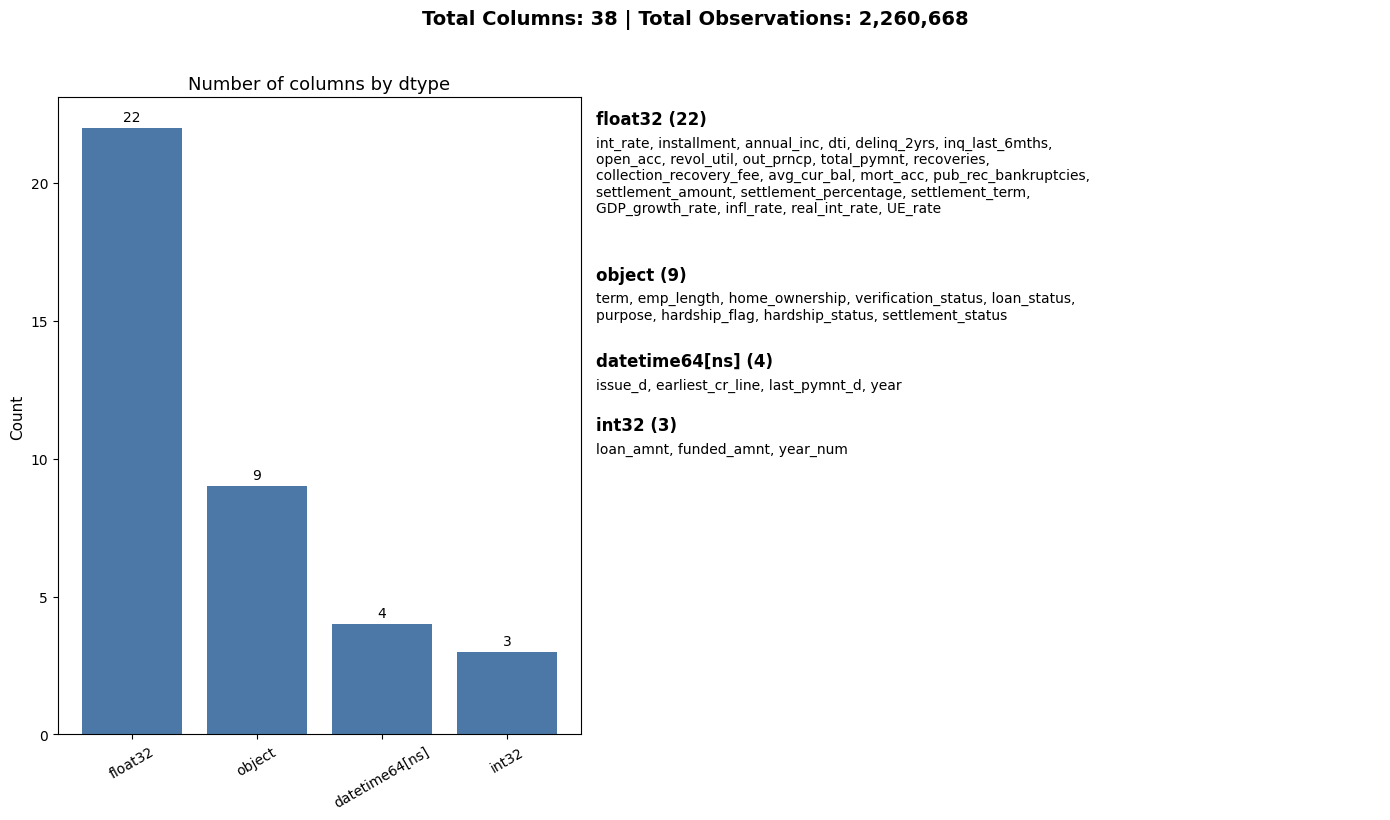

In [15]:
Plot_Dtype_Summary(df)
plt.show()

## Censoring Late Vintages

Loans that have originated too close to the snapshot date (Dec 2017) do not have enough time to fully  exhibit their default behaviour within the observation window. For this project, default is defined as occuring within 12 months of origination, thus loans issued in the last 12 months before the snapshot date cannot be reliably classified. These loans are considered "right-censored" and must be removed. Therefore, only loans issued before Dec 2016 are eligible. Censoring late vintages avoids biased PD estimates (artificially inflate "non-defaults") and ensures regulatory alignment (default identification over a defined time horizon).

In [16]:
# Finding date of latest observation
Snapshot_d = df["issue_d"].max()

# Finding the observation cutoff
Obs_Cutoff = Snapshot_d - pd.Timedelta(days = 365)

print(f"Latest Date : {Snapshot_d}")
print(f"Observation Cutoff Date : {Obs_Cutoff}")

Latest Date : 2018-12-01 00:00:00
Observation Cutoff Date : 2017-12-01 00:00:00


In [17]:
# Selecting only eligible observations
df["eligible"] = df["issue_d"] <= Obs_Cutoff
df = df[df["eligible"]]

In [18]:
print(f'{df["eligible"].value_counts().iloc[0]:,.0f}')

1,765,426


This means that out of the 2.3 million observations from the dataset, only 1.76 million observations are eligible

## Creating Default Flag Variable

The aim is to create a binary default flag called _default_12m_ to indicate whether a loan has defaulted within a 12 month time horizon. This ensures a consistent definition of default. Furthermore, using a 12-month fixed time horizon ensures comparability across vintages and prevents PD estimates from mixing short-term and long-term risk, making them inconsistent.

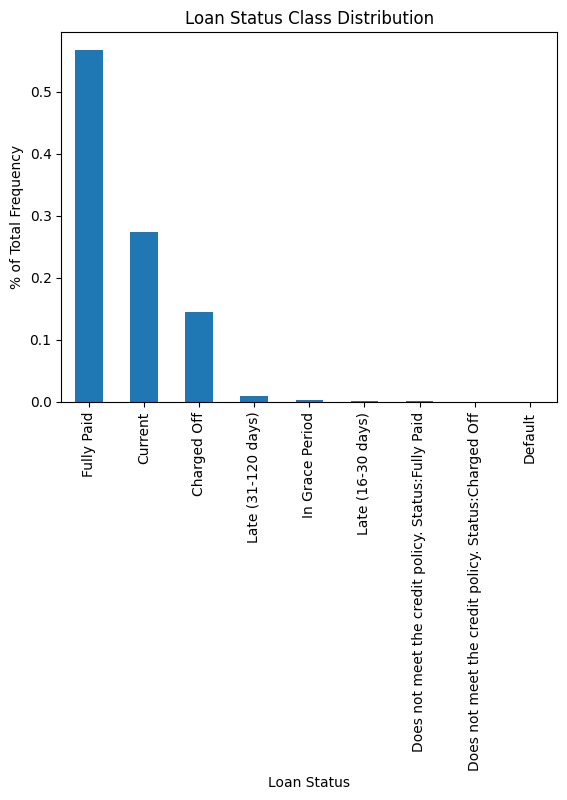

In [19]:
# Checking class distribution
df["loan_status"].value_counts(normalize = True).plot(kind = "bar", 
                                                      title = "Loan Status Class Distribution", 
                                                      xlabel = "Loan Status", 
                                                      ylabel = "% of Total Frequency")
plt.show()

In [20]:
pd.DataFrame(df["loan_status"].value_counts(normalize = True))

proportion
loan_status                                                   
Fully Paid                                                0.57
Current                                                   0.27
Charged Off                                               0.14
Late (31-120 days)                                        0.01
In Grace Period                                           0.00
Late (16-30 days)                                         0.00
Does not meet the credit policy. Status:Fully Paid        0.00
Does not meet the credit policy. Status:Charged...        0.00
Default                                                   0.00

Classes within _loan_status_ are numerous, have a small frequency and include transitional states that might be irrelevant for PD modelling. A binary flag would simplify this into a clear target. 

Moving forward, "Default" class will include charged off, default and late (31 - 120 days). "Non-Default" will include Fully Paid and Current. Excluding minor classes like "Does not meet credit policy" and Grace Periods because they are transitional.

In [21]:
# Selecting unwanted classes
class_to_remove = ["In Grace Period", "Late (16-30 days)", "Does not meet the credit policy. Status:Fully Paid:", "Does not meet the credit policy. Status:Charged Off"]

# Removing unwanted classes
mask = ~df["loan_status"].isin(class_to_remove)
df = df[mask]

Creating the default variable by converting "Charged Off", "Default" and "Late" into default

In [22]:
# Creating default_flag variable as a binary variable
df["default_flag"] = df["loan_status"].apply(lambda x : 1 if x in ["Charged Off", "Default", "Late (31-130 days)"] else 0)

In [23]:
def plot_pie_with_table(
    df: pd.DataFrame,
    col: str,
    top_n: int | None = None,     # e.g., 8 -> keep top 8 categories, group rest as "Other"
    dropna: bool = False,         # include NaN in counts when False
    figsize: tuple = (10, 6),
    table_fontsize: int = 10
):

    # 1) Compute counts
    vc = df[col].value_counts(dropna=dropna)

    # Optional: group small categories into "Other"
    if top_n is not None and len(vc) > top_n:
        top = vc.iloc[:top_n]
        other_count = vc.iloc[top_n:].sum()
        counts = pd.concat([top, pd.Series({'Other': other_count})])
    else:
        counts = vc

    labels = counts.index.astype(str)
    sizes = counts.values
    total = sizes.sum()
    pct = 100 * sizes / total

    # 2) Layout: pie (left) + table (right)
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3, 1])
    ax_pie = fig.add_subplot(gs[0])
    ax_table = fig.add_subplot(gs[1])

    # 3) Pie chart with percentage labels
    def fmt_autopct(pct_val):
        # Only show label if slice is reasonably large (avoid clutter)
        return f"{pct_val:.1f}%" if pct_val >= 2 else ""

    wedges, texts, autotexts = ax_pie.pie(
        sizes,
        labels=labels,
        autopct=fmt_autopct,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(edgecolor="white"),
        textprops=dict(color="black", fontsize=10)
    )
    ax_pie.set_title(f"Class Distribution: {col}\n(n={total:,})", fontsize=12, pad = 20)
    ax_pie.axis("equal")  # keep the pie circular

    # 4) Table on the right (counts + percentages)
    ax_table.axis("off")

    table_df = pd.DataFrame({
        "Class": labels,
        "Count": [f"{c:,}" for c in sizes],
        "Percent": [f"{p:.1f}%" for p in pct]
    })

    # Create table: header + rows
    cell_text = [table_df.columns.tolist()] + table_df.values.tolist()
    table = ax_table.table(
        cellText=cell_text,
        loc="center",
        cellLoc="left",
        colWidths=[0.25, 0.25, 0.25]
    )

    # Style table
    for (row, col_idx), cell in table.get_celld().items():
        cell.set_edgecolor("white")
        if row == 0:
            cell.set_text_props(weight="bold")
            cell.set_facecolor("#f0f0f0")
        cell.set_fontsize(table_fontsize)
        cell.PAD = 0.5  # compact padding

    fig.tight_layout()
    
    return fig, (ax_pie, ax_table)

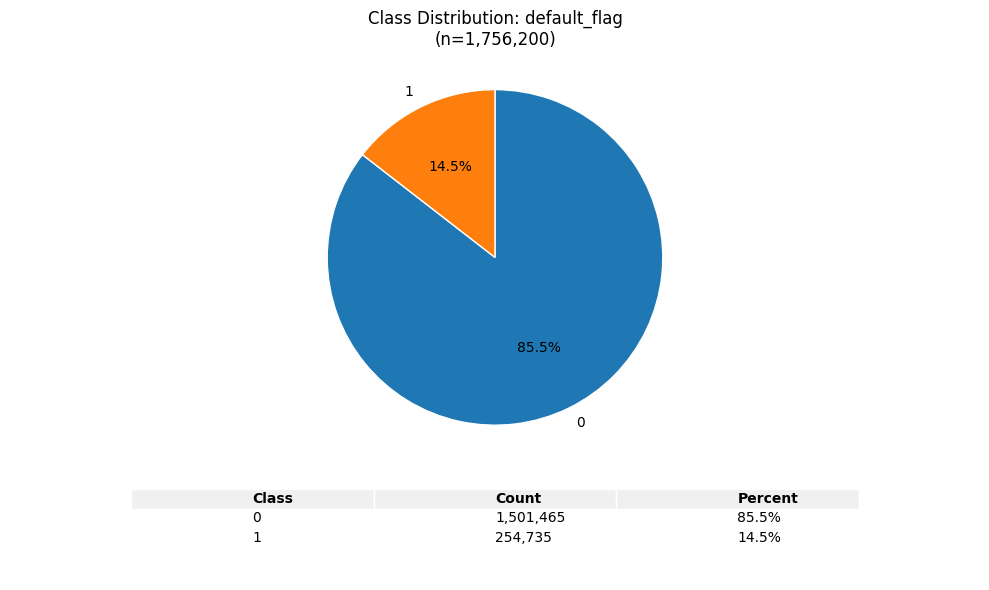

In [24]:
plot_pie_with_table(df, col = "default_flag")
plt.show()

Following the previous logic of determining default within 12 months, any default that occurs past 12 months, will be deleted

Text(0.5, 0, 'Days')

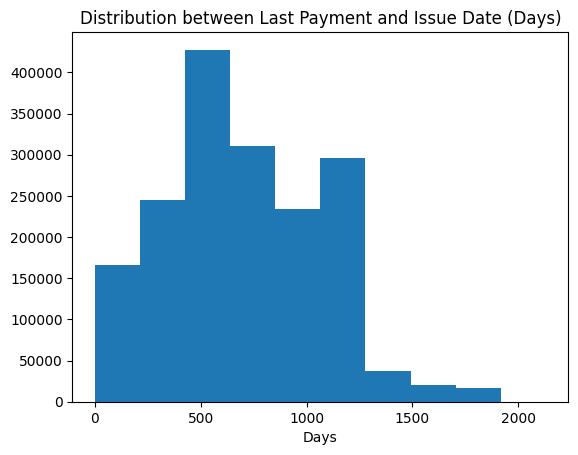

In [25]:
# Determining number of days until default
days_to_event = (df["last_pymnt_d"] - df["issue_d"]).dt.days

plt.hist(days_to_event)
plt.title("Distribution between Last Payment and Issue Date (Days)")
plt.xlabel("Days")

In [26]:
# Categorizing whether the default occurs within 365 days
df["default_12m"] = np.where((df["default_flag"] == 1) | (days_to_event <= 365), 1, 0)

In [27]:
# Checking distribution of defaul_12m
df["default_12m"].value_counts(normalize = True)

default_12m
0   0.71
1   0.29
Name: proportion, dtype: float64

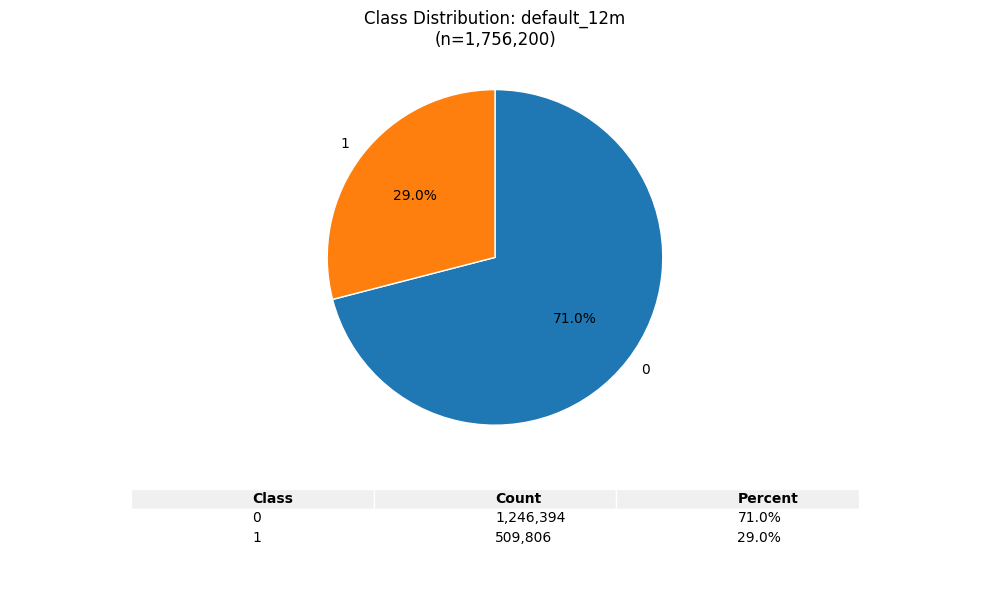

In [28]:
plot_pie_with_table(df, "default_12m")
plt.show()

Despite reducing the number of classes and implementing the event horizon, the _default_12m_ still has an unbalanced distribution. During the modelling phase, class_weights must be enabled

## Creating New Feature Variables

### Creating *credit_age* variable

Creating a new variable called "credit age" which will be the length of the borrower's credit history at the time of the loan origination. This will provide more predictive power because a longer history indicates more experience and lower default risk.

In [29]:
# Creating the Credit Age variable
df["credit_age"] = ((df["issue_d"] - df["earliest_cr_line"]).dt.days / 365.25).astype("float32")

Resetting the index

In [30]:
df = df.reset_index(drop = True)
df

loan_amnt  funded_amnt        term  int_rate  installment emp_length  \
0             8000         8000   36 months     12.79       268.75    4 years   
1            20000        20000   60 months     17.99       507.76     1 year   
2            10000        10000   36 months      8.59       316.10  10+ years   
3            32200        32200   60 months     21.49       880.02  10+ years   
4             2600         2600   36 months      8.99        82.67    3 years   
...            ...          ...         ...       ...          ...        ...   
1756195      12000        12000   60 months     14.08       279.72  10+ years   
1756196      12000        12000   60 months     25.82       358.01   < 1 year   
1756197      10000        10000   36 months     11.99       332.10  10+ years   
1756198      12000        12000   60 months     21.45       327.69        NaN   
1756199      16550        16550   60 months     21.45       451.94    3 years   

        home_ownership  annual_inc verification_status    issue_d  \
0             MORTGAGE    95000.00            Verified 2016-09-01   
1             MORTGAGE    66000.00        Not Verified 2016-09-01   
2             MORTGAGE   137500.00     Source Verified 2016-09-01   
3             MORTGAGE    65000.00        Not Verified 2016-09-01   
4                 RENT    35000.00     Source Verified 2016-09-01   
...                ...         ...                 ...        ...   
1756195       MORTGAGE    58000.00        Not Verified 2017-10-01   
1756196       MORTGAGE    30000.00        Not Verified 2017-10-01   
1756197            OWN    64000.00     Source Verified 2017-10-01   
1756198           RENT    60000.00        Not Verified 2017-10-01   
1756199           RENT    60000.00        Not Verified 2017-10-01   

         loan_status             purpose   dti  delinq_2yrs earliest_cr_line  \
0            Current  debt_consolidation 10.30         0.00       1993-05-01   
1        Charged Off             medical 12.62         2.00       2008-12-01   
2         Fully Paid  debt_consolidation 13.42         0.00       2002-05-01   
3         Fully Paid         credit_card 11.71         0.00       1992-11-01   
4         Fully Paid              moving  6.73         0.00       2009-09-01   
...              ...                 ...   ...          ...              ...   
1756195      Current  debt_consolidation 20.88         0.00       2004-01-01   
1756196   Fully Paid  debt_consolidation 19.28         3.00       2003-03-01   
1756197      Current  debt_consolidation 12.96         0.00       1995-02-01   
1756198      Current  debt_consolidation 30.82         2.00       2003-07-01   
1756199      Current         credit_card 18.40         0.00       2014-04-01   

         inq_last_6mths  open_acc  revol_util  out_prncp  total_pymnt  \
0                  1.00     12.00       47.90    2063.66      7521.68   
1                  0.00     18.00       31.00       0.00      7366.25   
2                  1.00     18.00        8.80       0.00     10962.48   
3                  1.00     17.00       48.10       0.00     35770.81   
4                  0.00     14.00        1.40       0.00      2662.59   
...                 ...       ...         ...        ...          ...   
1756195            0.00     12.00       39.20    8687.20      5360.96   
1756196            1.00     10.00       20.20       0.00     14499.80   
1756197            0.00      6.00       70.90    5993.27      5306.94   
1756198            1.00      8.00       34.90    9924.69      5207.29   
1756199            1.00     13.00       50.80   13541.01      7355.50   

         recoveries  collection_recovery_fee last_pymnt_d  avg_cur_bal  \
0              0.00                     0.00   2019-02-01      2559.00   
1           1313.11                   236.36   2017-10-01     13076.00   
2              0.00                     0.00   2018-12-01     34332.00   
3              0.00                     0.00   2017-04-01     10845.00   

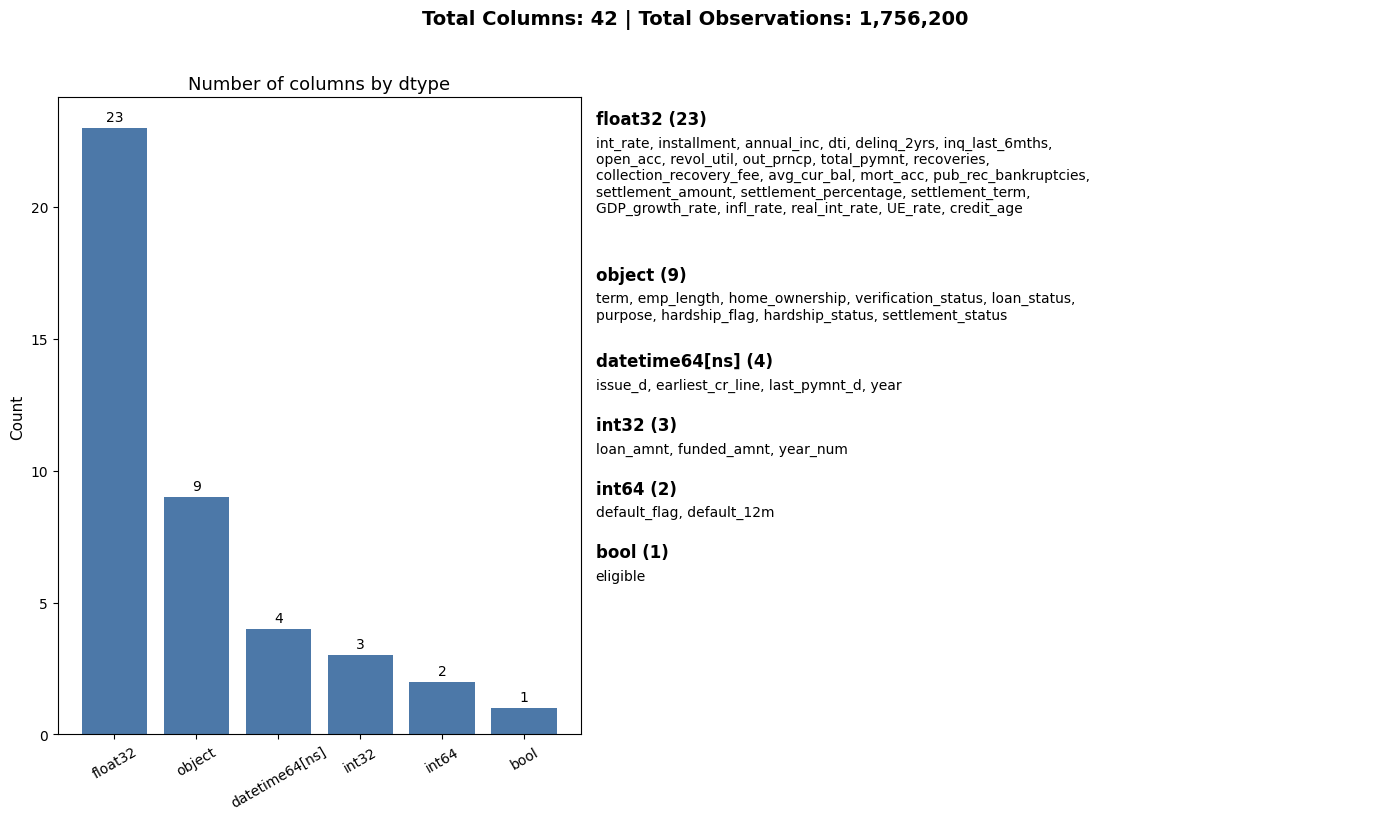

In [31]:
Plot_Dtype_Summary(df)
plt.show()

### Creating *verified* variable

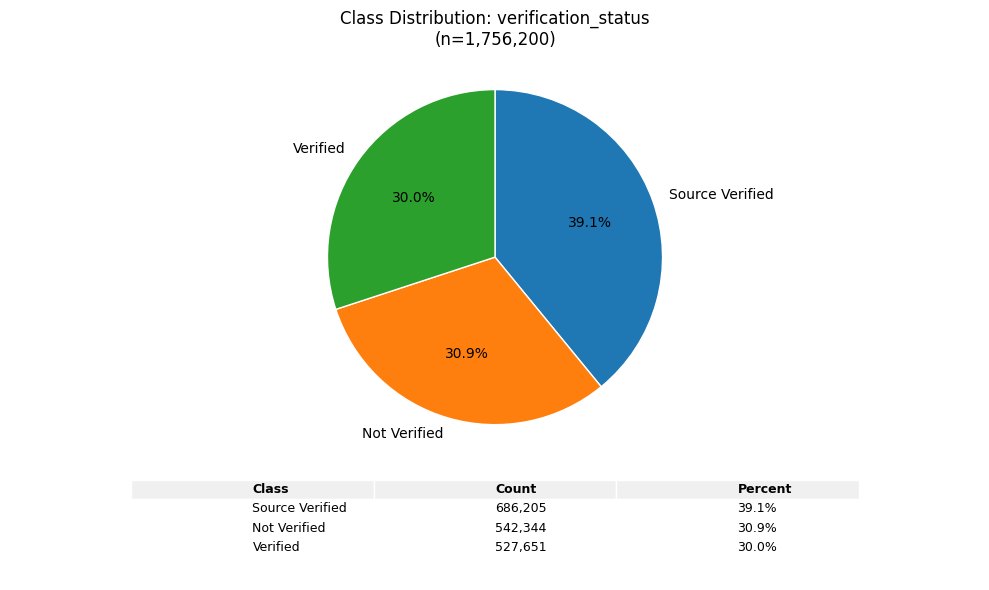

In [32]:
plot_pie_with_table(df, "verification_status")
plt.show()

## Creating Dataset to Calculate PD

Not all variables will be relevant for calculating the PD. Therefore, only important variables such as _default_12m_, _issue_d_, _purpose_, _loan_amnt_, _int_rate_, _term_, _annual_inc_, _dti_, _verification_status_, _emp_length_, _home_ownership_, _delinq_2yrs_, _inq_last_6mths_, _open_acc_, _revol_util_, _credit_age_, _mort_acc_, _avg_cur_bal_, _pub_rec_bankruptcies_, _GDP_growth_rate_, _infl_rate_, _real_int_rate_, _UE_rate_. 

In [33]:
# Selecting the variables for PD
PD_var = ["default_12m", "issue_d", "purpose", "loan_amnt","int_rate", "term", "annual_inc", "dti", "verification_status", "emp_length", "home_ownership", "delinq_2yrs", 
          "inq_last_6mths", "open_acc", "revol_util", "credit_age", "mort_acc", "avg_cur_bal", "pub_rec_bankruptcies",  "GDP_growth_rate", "infl_rate", "real_int_rate", 
          "UE_rate"]

PD_df = df[PD_var]

Exploring the dataset

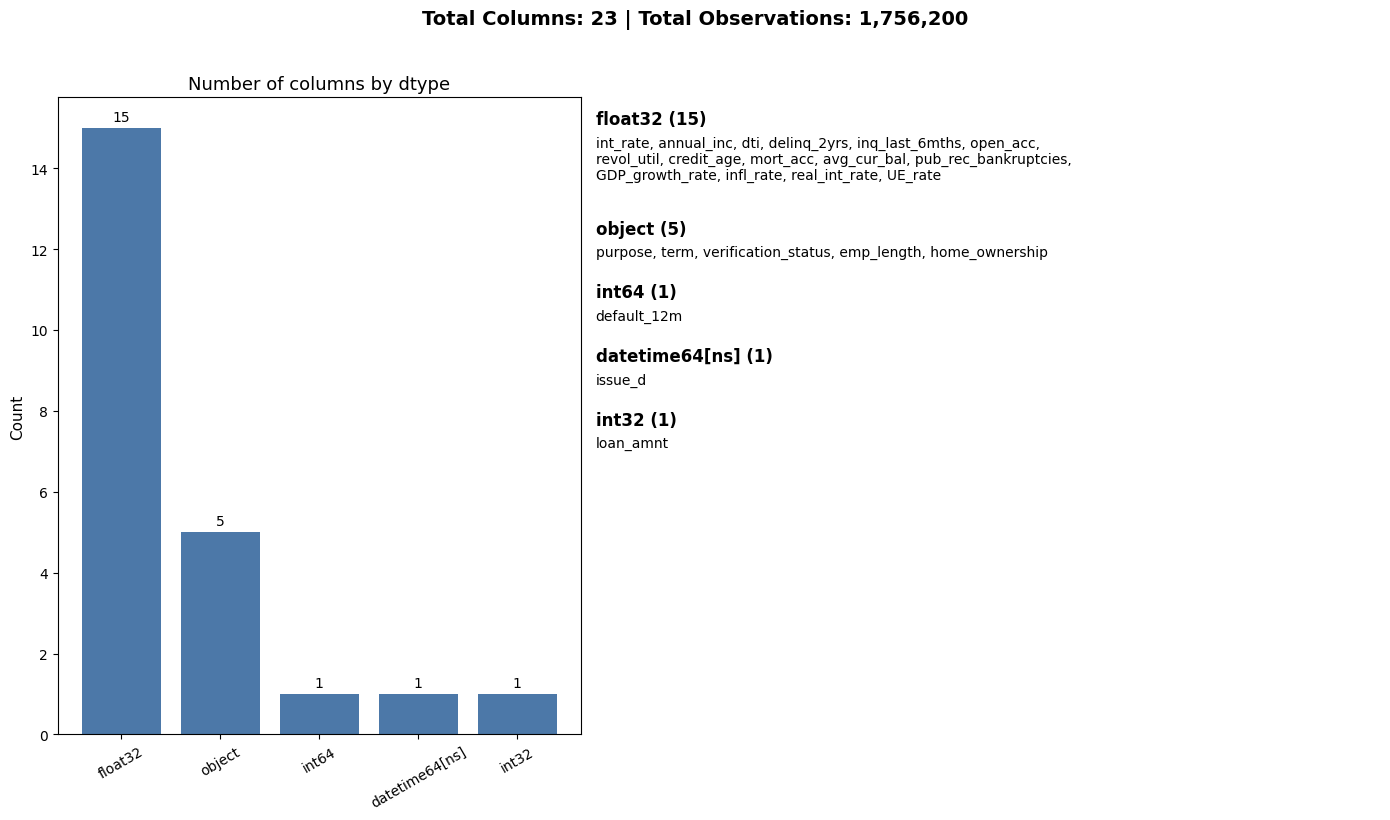

In [34]:
Plot_Dtype_Summary(PD_df)
plt.show()

In [35]:
PD_df.describe()

default_12m                        issue_d  loan_amnt   int_rate  \
count   1756200.00                        1756200 1756200.00 1756200.00   
mean          0.29  2015-09-26 03:58:08.420909056   14762.24      13.18   
min           0.00            2007-06-01 00:00:00     500.00       5.32   
25%           0.00            2014-11-01 00:00:00    8000.00       9.75   
50%           0.00            2015-12-01 00:00:00   12525.00      12.74   
75%           1.00            2017-01-01 00:00:00   20000.00      15.99   
max           1.00            2017-12-01 00:00:00   40000.00      30.99   
std           0.45                            NaN    8882.27       4.73   

        annual_inc        dti  delinq_2yrs  inq_last_6mths   open_acc  \
count   1756196.00 1755623.00   1756174.00      1756173.00 1756174.00   
mean      77387.92      18.58         0.33            0.61      11.65   
min           0.00      -1.00         0.00            0.00       0.00   
25%       46000.00      12.01         0.00            0.00       8.00   
50%       65000.00      17.86         0.00            0.00      11.00   
75%       92000.00      24.35         0.00            1.00      14.00   
max   110000000.00     999.00        42.00           31.00      97.00   
std      118718.38      11.83         0.90            0.92       5.55   

       revol_util  credit_age   mort_acc  avg_cur_bal  pub_rec_bankruptcies  \
count  1755005.00  1756174.00 1706931.00   1686655.00            1755051.00   
mean        52.13       16.47       1.62     13500.33                  0.13   
min          0.00        0.50       0.00         0.00                  0.00   
25%         33.90       11.33       0.00      3131.00                  0.00   
50%         52.40       14.92       1.00      7428.00                  0.00   
75%         70.90       20.33       3.00     18717.00                  0.00   
max        892.30       83.25      94.00    958084.00                 12.00   
std         24.35        7.61       1.95     16247.10                  0.37   

       GDP_growth_rate  infl_rate  real_int_rate    UE_rate  
count       1756200.00 1756200.00     1756200.00 1756200.00  
mean              2.37       1.32           2.26       5.40  
min              -2.58      -0.36           1.16       4.36  
25%               1.82       1.26           1.75       4.36  
50%               2.46       1.46           2.37       5.28  
75%               2.52       2.13           2.62       6.17  
max               2.95       3.84           5.20       9.63  
std               0.50       0.77           0.42       1.12

# Phase 2: PD Dataset Preprocessing

1) Categorical Grouping
2) Normalize String Fields
3) Clip Outliers - Large and crazy outliers, apply clipping (governance-friendly and easily explainable)
4) Transformation - To handle skewed data, applying log transformation and square root
5) Imputation - Use median for continuous and mode for counts and categoricals
6) One-Hot Encoding (OHE) for categorical variables
7) VIF Check - Check for multicollinearity. Drop highly correlated features
8) Standard Scaling - Use StandardScaler from sklearn for continuous variables only
9) Splitting data into train, validation and test datasets

## Defining the Numerical and Categorical Columns

In [36]:
num_col = ["loan_amnt", "int_rate", "annual_inc", "dti", "delinq_2yrs",
       "inq_last_6mths", "open_acc", "revol_util", "credit_age", "mort_acc", "avg_cur_bal",
       "pub_rec_bankruptcies", "GDP_growth_rate", "infl_rate", "real_int_rate",
       "UE_rate"]

cat_col = ["purpose", "term", "verification_status", "emp_length", "home_ownership"]

## Processing Categorical Variables

### Binning rare categories into "Other"

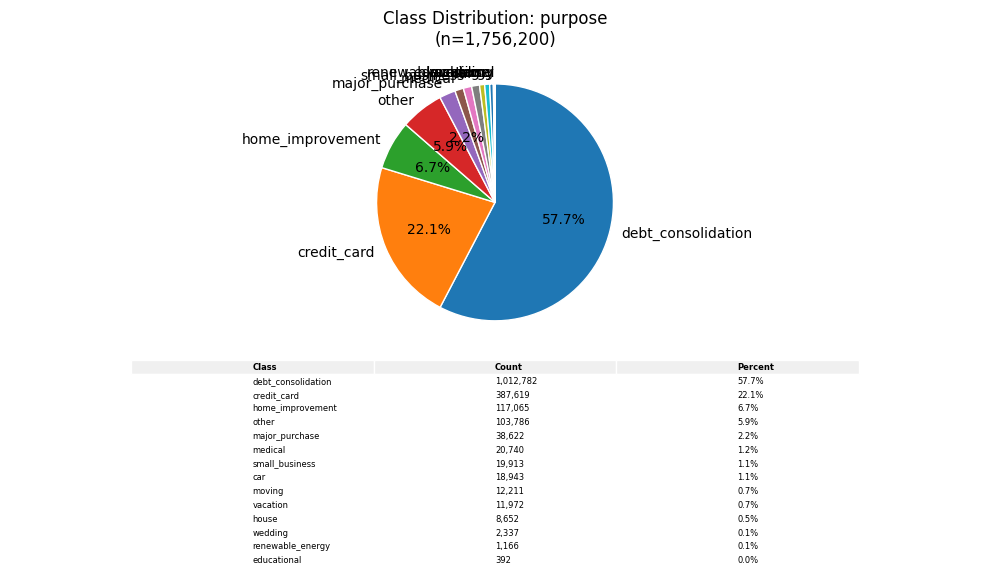

In [37]:
plot_pie_with_table(PD_df, "purpose")
plt.show()

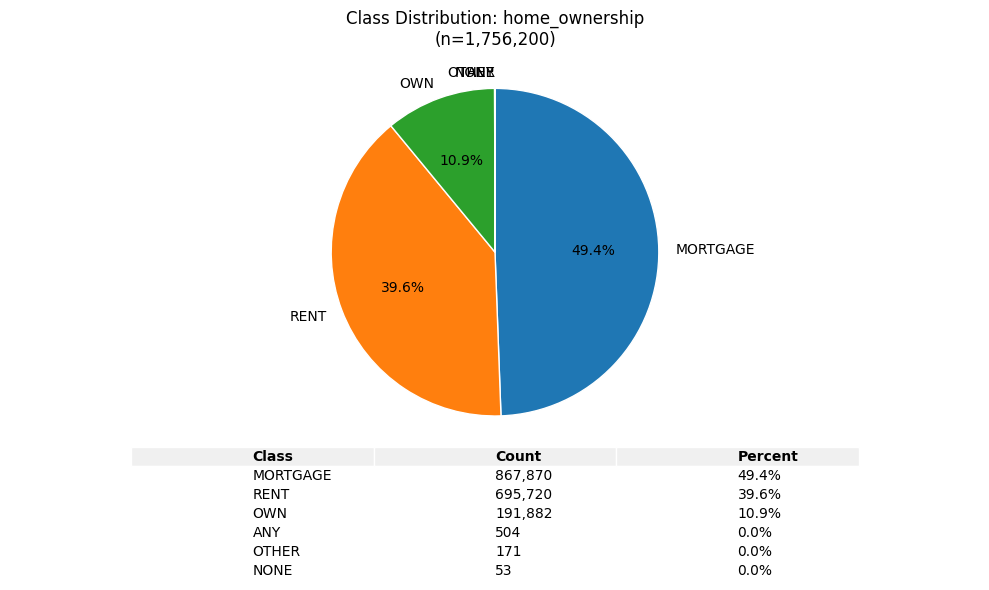

In [38]:
plot_pie_with_table(PD_df, "home_ownership")
plt.show()

_purpose_ and _home_ownership_ has various classes with extremely small frequencies. These will be combined together into another category called "Other". This will reduce the chance of overfitting by reducing noise and improving generalization. Reducing the number of categories also improves model stability by preventing high-dimensional sparse features after one-hot encoding and improves interpretability.

In [39]:
# Selecting variables with small categories
rare_cat = ["purpose", "home_ownership"]

In [40]:
PD_df_cat = PD_df.copy()

In [41]:
# Creating "Other" subcategory
for i in rare_cat:
    freq = PD_df_cat[i].value_counts(normalize = True)
    rare_categories = freq[freq<0.10].index
    PD_df_cat[i] = PD_df_cat[i].replace(rare_categories, "Other")

Checking new categorical variable distribution

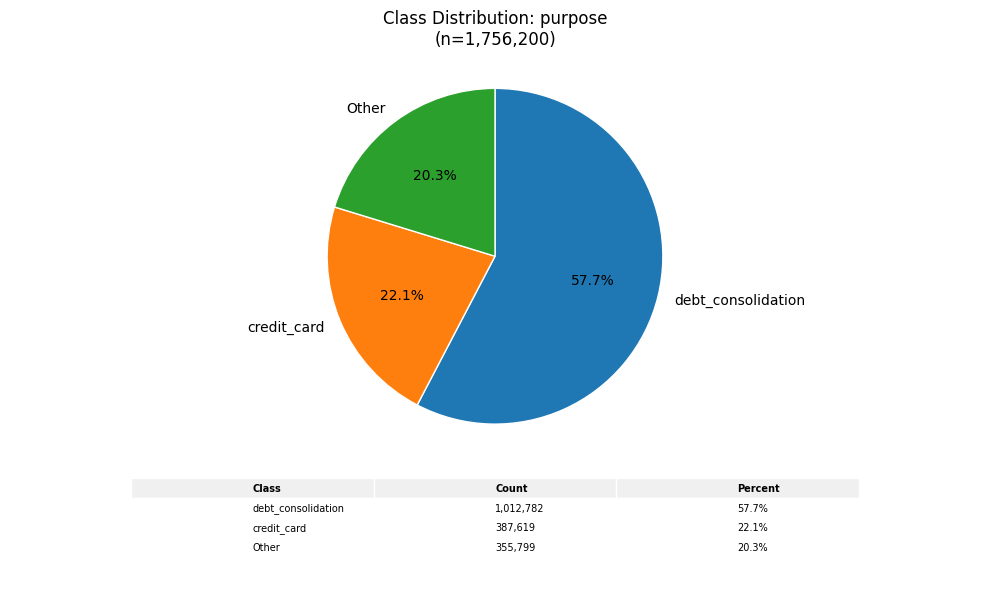

In [42]:
plot_pie_with_table(PD_df_cat, "purpose")
plt.show()

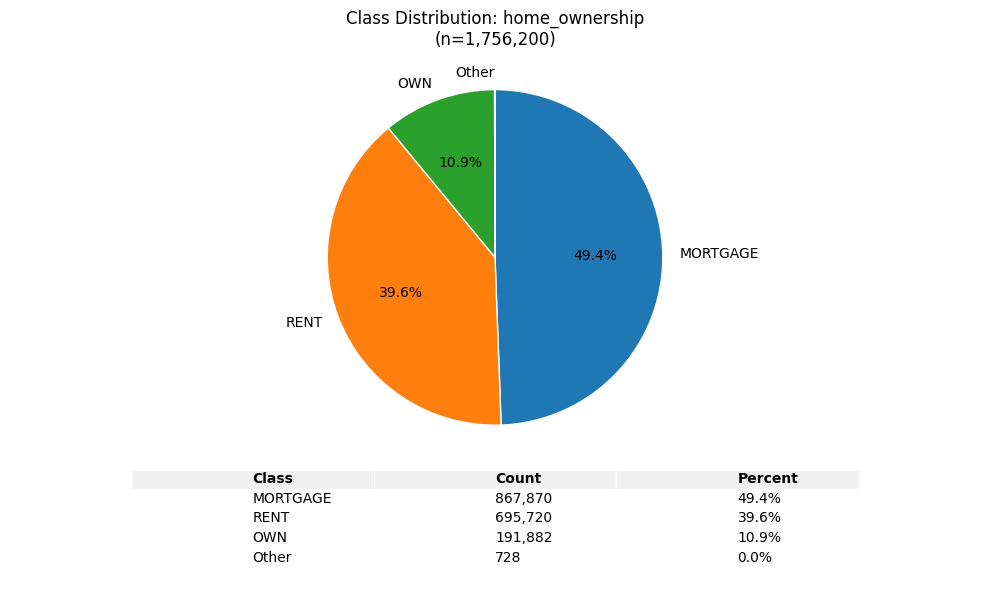

In [43]:
plot_pie_with_table(PD_df_cat, "home_ownership")
plt.show()

### Binning emp_length variable

Checking the current class distribution within emp_length

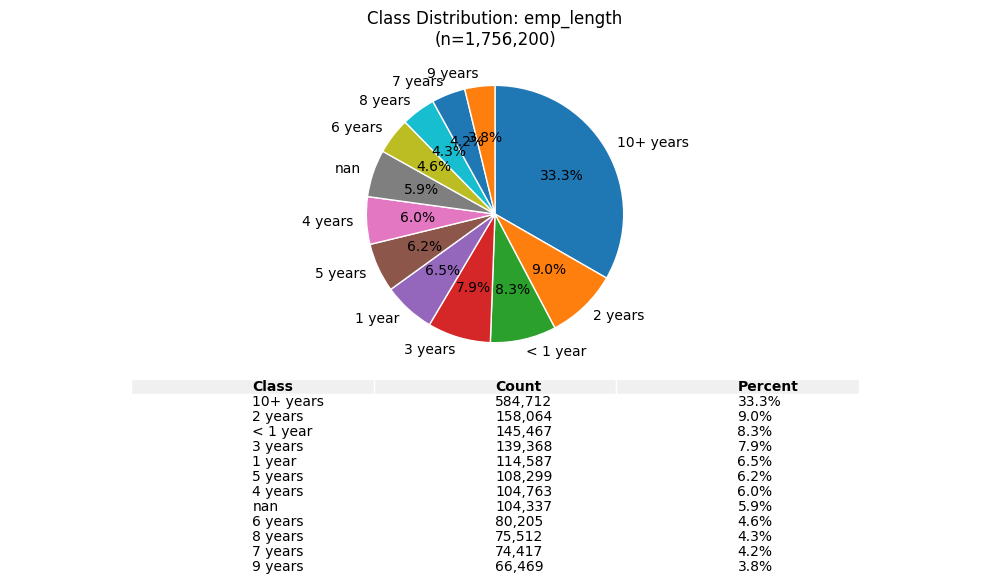

In [44]:
plot_pie_with_table(PD_df_cat, "emp_length")
plt.show()

_emp_length_ has too many classes that with very small frequencies. This will lead to the same problems as the rare categories in _purpose_ and _home_ownership_. Therefore, each category will be binned into fewer, wider categories as per the mapping

In [45]:
# Defining the new categories and mapping them to the old categories
emp_length_map = {
    "< 1 year" : "0-3 years",
    "1 year" : "0-3 years",
    "2 years" : "0-3 years",
    "3 years" : "0-3 years",
    "4 years" : "4-6 years",
    "5 years" : "4-6 years",
    "6 years" : "4-6 years",
    "7 years" : "7-9 years",
    "8 years" : "7-9 years",
    "9 years" : "7-9 years",
    "10+ years" : "10+ years"
}

# Applying the mapping
PD_df_cat["emp_length"] = PD_df_cat["emp_length"].replace(emp_length_map)

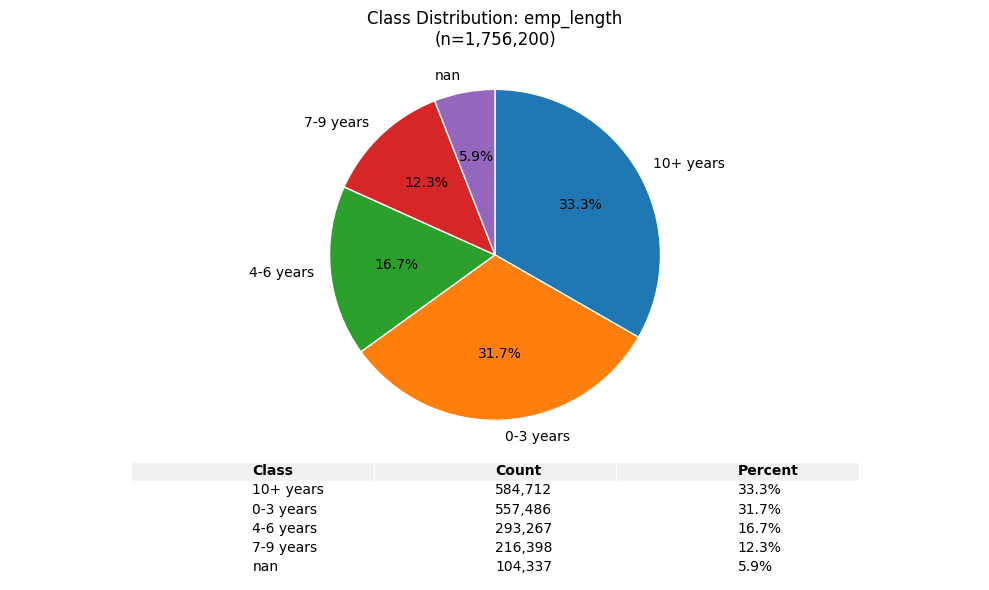

In [46]:
plot_pie_with_table(PD_df_cat, "emp_length")
plt.show()

_emp_length_ now has fewer classes with better distribution

## Clipping Outliers

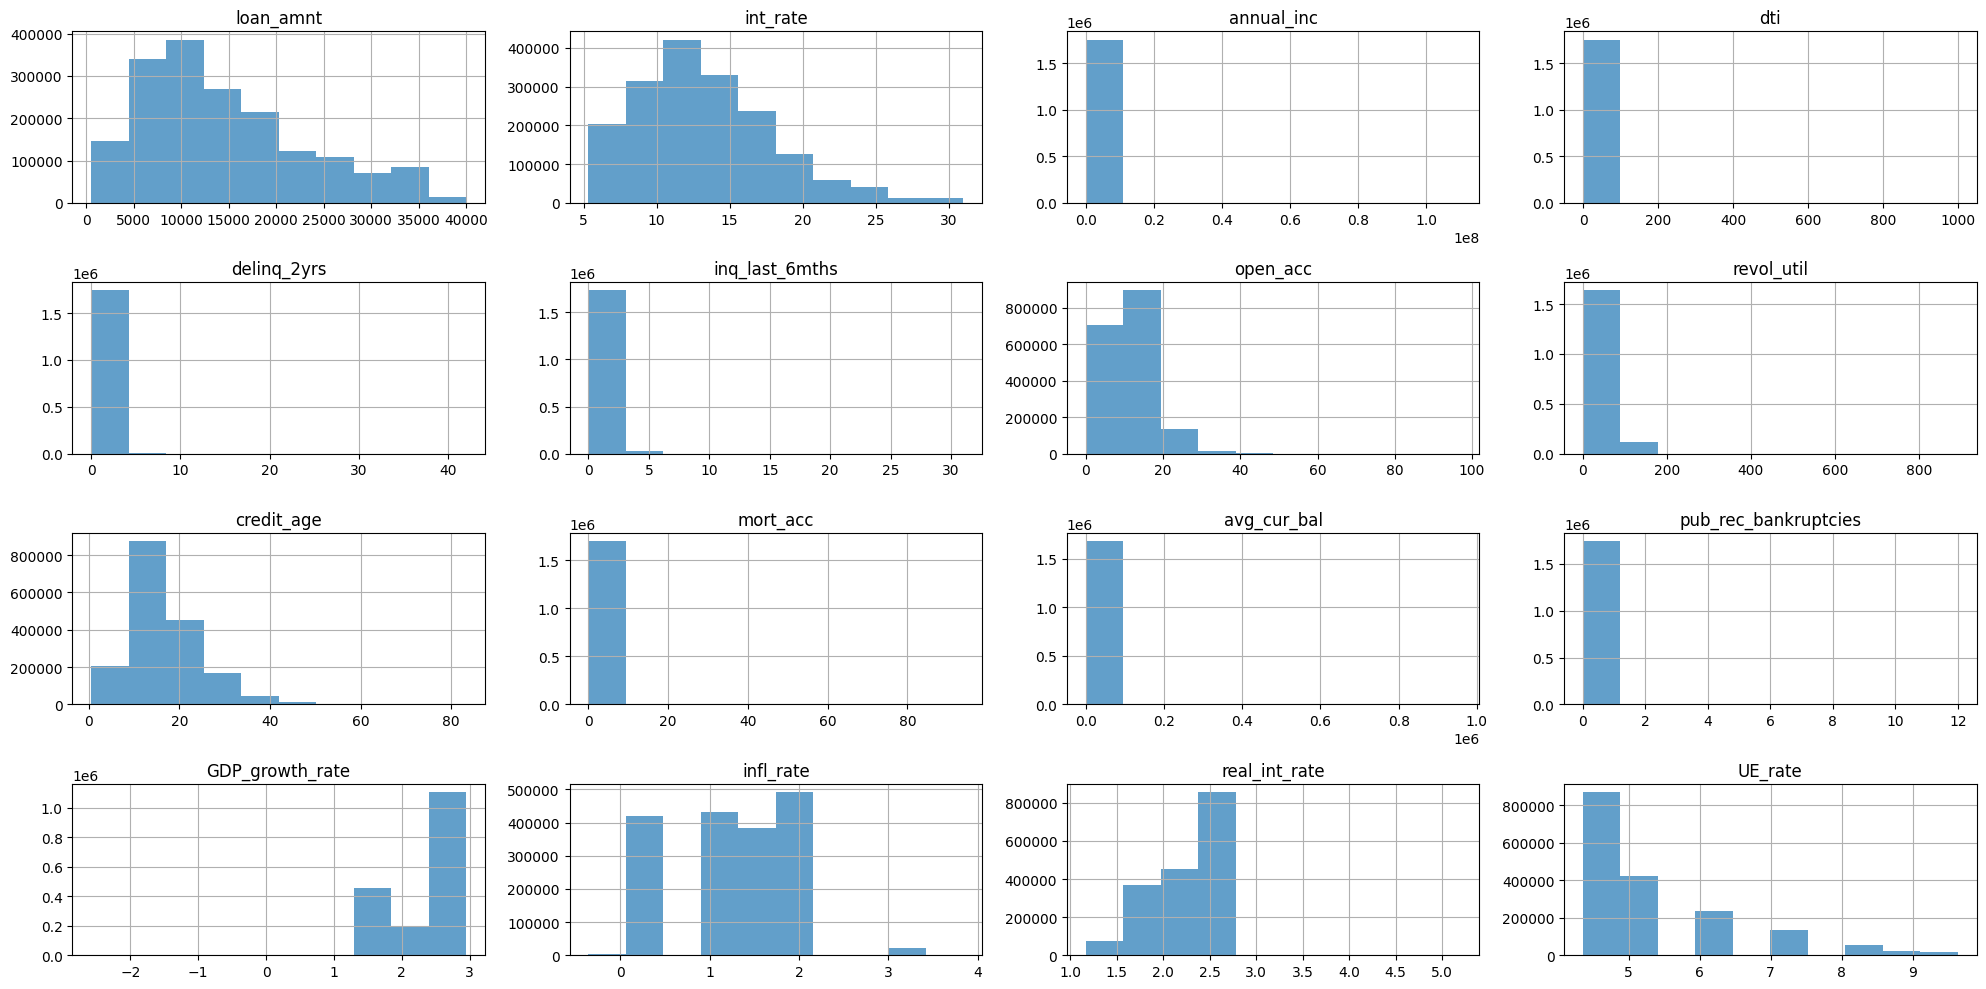

In [47]:
PD_df_cat[num_col].hist(bins=10, alpha=0.7, figsize=(20, 10))
plt.tight_layout()
plt.show()

Based on the histograms above, we can see that the distributions for numerical variables are heavily right skewed with long right tails and significant outliers. Therefore outliers will be clipped based on the clip_rules outlined below based on logical ranges for each variable. Clipping outliers will reduce the model's sensitivity to extreme values leading to more stable and unbiased estimates. Removing outlieres also improves robustness and generalization by removing data errors, unusual transactions or rare events that do not generalize well.

In [48]:
PD_df_clip = PD_df_cat.copy()

In [49]:
# Defining maximum and minimum clipping values
clip_rules = {
    "loan_amnt": (0, 40000),
    "int_rate": (0, 30),
    "annual_inc": (0, 300000),
    "dti": (0, 100),
    "delinq_2yrs": (0,10),
    "inq_last_6mths": (0, 10),
    "open_acc": (0, 50),
    "revol_util": (0, 100),
    "credit_age" : (0, 60),
    "mort_acc": (0, 25),
    "avg_cur_bal": (0, 100000),
    "pub_rec_bankruptcies": (0, 2)
}

# Applying the clip rules to the dataset
for col, (lo, hi) in clip_rules.items():
    if col in PD_df_clip.columns:
        PD_df_clip[col] = PD_df_clip[col].clip(lo, hi)

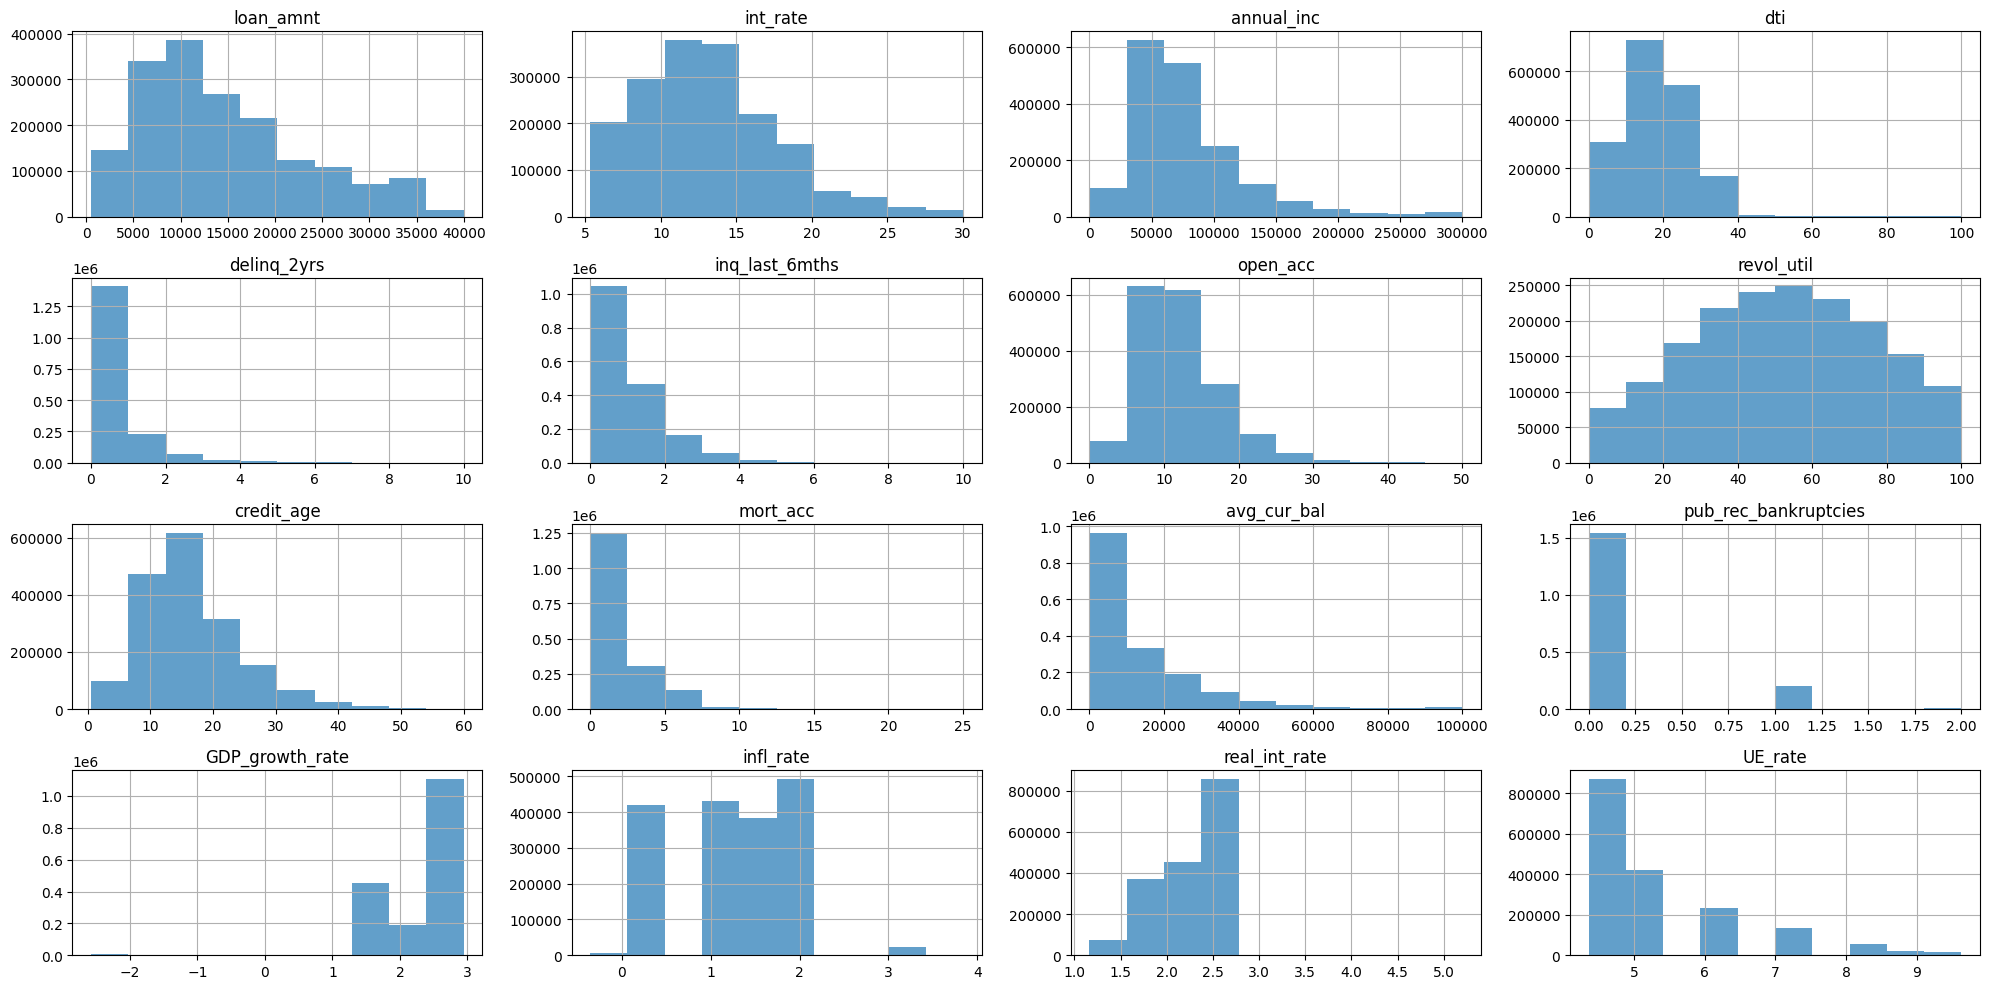

In [50]:
PD_df_clip[num_col].hist(bins=10, alpha=0.7, figsize=(20, 10))
plt.tight_layout()
plt.show()

Outliers have been removed but the data is heavily skewed. Will need to apply some transformations to reduce the skewness

## Transformations

Transformations will only be applied to continuous numerical columns. Transformations will also not be applied to macroeconomic variables since they might lose their interpretability. Regression models assume linearity and often work better when predictors are closer to normal distribution, stabilizing variances and improving model performance.

In [51]:
num_con_col = ["loan_amnt", "int_rate", "dti", "avg_cur_bal", "annual_inc"]

In [52]:
# Checking current skew
PD_df_clip[num_con_col].agg(["skew"]).round(2)

loan_amnt  int_rate  dti  avg_cur_bal  annual_inc
skew       0.76      0.74 0.98         2.29        2.02

Based on the table above, all continuous variables need to be transformed due to their significant positive skew. Almost all variables have a skew above 1. Each continuous variable will have no transformation, log, square root and cube applied to them, then the transformation that produces the smallest absolute skew will be saved and applied to the final dataset.

In [53]:
PD_df_tran = PD_df_clip.copy()

In [54]:
transformations = pd.DataFrame({
    "none" : abs(PD_df_tran[num_con_col].skew()),
    "log" : abs(np.log1p(PD_df_tran[num_con_col]).skew()),
    "sqrt" : abs(np.sqrt(PD_df_tran[num_con_col]).skew()),
    "cube" : abs((np.sign(PD_df_tran[num_con_col]) * np.power(np.abs(PD_df_tran[num_con_col]), 1/3)).skew())
})

transformation_dict = {col : [] for col in transformations}

for row in transformations.index:
    min_col = transformations.loc[row].idxmin()
    transformation_dict[min_col].append(row)

transformation_dict

{'none': [],
 'log': ['avg_cur_bal'],
 'sqrt': ['dti'],
 'cube': ['loan_amnt', 'int_rate', 'annual_inc']}

Based on this, we can see that:
- _loan_amnt_, _int_rate_ and _annual_inc_ should be cubed.
- _dti_ should have a square root transformation
- _avg_cur_bal_ should have a log transformation.

In [55]:
def Transform (df, dictionary):
    for trans in dictionary:
        if trans == "none":
            for col in dictionary[trans]:
                df[col] = df[col]
        elif trans == "log":
            for col in dictionary[trans]:
                df[col] = np.log1p(df[col])
        elif trans == "sqrt":
            for col in dictionary[trans]:
                df[col] = np.sqrt(df[col])
        elif trans == "cube":
            for col in dictionary[trans]:
                df[col] = (np.sign(df[col]) * np.power(np.abs(df[col]), 1/3))
    return df

In [56]:
Transform(PD_df_tran, transformation_dict)

default_12m    issue_d             purpose  loan_amnt  int_rate  \
0                  0 2016-09-01  debt_consolidation      20.00      2.34   
1                  1 2016-09-01               Other      27.14      2.62   
2                  0 2016-09-01  debt_consolidation      21.54      2.05   
3                  1 2016-09-01         credit_card      31.81      2.78   
4                  1 2016-09-01               Other      13.75      2.08   
...              ...        ...                 ...        ...       ...   
1756195            0 2017-10-01  debt_consolidation      22.89      2.41   
1756196            1 2017-10-01  debt_consolidation      22.89      2.96   
1756197            0 2017-10-01  debt_consolidation      21.54      2.29   
1756198            0 2017-10-01  debt_consolidation      22.89      2.78   
1756199            0 2017-10-01         credit_card      25.48      2.78   

               term  annual_inc  dti verification_status emp_length  \
0         36 months       45.63 3.21            Verified  4-6 years   
1         60 months       40.41 3.55        Not Verified  0-3 years   
2         36 months       51.61 3.66     Source Verified  10+ years   
3         60 months       40.21 3.42        Not Verified  10+ years   
4         36 months       32.71 2.59     Source Verified  0-3 years   
...             ...         ...  ...                 ...        ...   
1756195   60 months       38.71 4.57        Not Verified  10+ years   
1756196   60 months       31.07 4.39        Not Verified  0-3 years   
1756197   36 months       40.00 3.60     Source Verified  10+ years   
1756198   60 months       39.15 5.55        Not Verified        NaN   
1756199   60 months       39.15 4.29        Not Verified  0-3 years   

        home_ownership  delinq_2yrs  inq_last_6mths  open_acc  revol_util  \
0             MORTGAGE         0.00            1.00     12.00       47.90   
1             MORTGAGE         2.00            0.00     18.00       31.00   
2             MORTGAGE         0.00            1.00     18.00        8.80   
3             MORTGAGE         0.00            1.00     17.00       48.10   
4                 RENT         0.00            0.00     14.00        1.40   
...                ...          ...             ...       ...         ...   
1756195       MORTGAGE         0.00            0.00     12.00       39.20   
1756196       MORTGAGE         3.00            1.00     10.00       20.20   
1756197            OWN         0.00            0.00      6.00       70.90   
1756198           RENT         2.00            1.00      8.00       34.90   
1756199           RENT         0.00            1.00     13.00       50.80   

         credit_age  mort_acc  avg_cur_bal  pub_rec_bankruptcies  \
0             23.34      3.00         7.85                  1.00   
1              7.75      1.00         9.48                  1.00   
2             14.34      2.00        10.44                  1.00   
3             23.83      3.00         9.29                  1.00   
4              7.00      0.00         7.24                  0.00   
...             ...       ...          ...                   ...   
1756195       13.75      2.00         8.32                  0.00   
1756196       14.59      4.00        10.45                  0.00   
1756197       22.66      3.00        10.36                  0.00   
1756198       14.25      0.00         9.01                  0.00   
1756199        3.50      0.00         7.59                  0.00   

         GDP_growth_rate  infl_rate  real_int_rate  UE_rate  
0                   1.82       1.26           2.64     4.87  
1                   1.82       1.26           2.64     4.87  
2                   1.82       1.26           2.64     4.87  
3                   1.82       1.26           2.64     4.87  
4                   1.82       1.26           2.64     4.87  
...                  ...        ...            ...      ...  
1756195             2.46       2.13           2.37     4.36  
17561

In [57]:
# Rechecking skew
skew_comparison_df = pd.DataFrame({
    "Old_skew": PD_df_clip[num_con_col].skew().round(2),
    "New_skew": PD_df_tran[num_con_col].skew().round(2)
})
skew_comparison_df

Old_skew  New_skew
loan_amnt        0.76     -0.09
int_rate         0.74      0.11
dti              0.98     -0.21
avg_cur_bal      2.29     -0.35
annual_inc       2.02      0.60

All skew for continuous numerical values are below 1

## Imputation

This dataset contains significant missing values as will be shown below. Some models such as logistic regression, LDA and probit cannot handle missing data. Furthermore, simply removing observations with missing variables can reduce the sample size and introduce unnecessary bias into the model. Missing values for continuous numeric variables will be imputed using median and missing values for categorical and discrete numerical values will be imputed using mode.

In [58]:
from sklearn.impute import SimpleImputer

In [59]:
def plot_missing_with_table(
    df: pd.DataFrame,
    top_n: int | None = None,        # show only top-N columns by missing count
    include_zero: bool = False,      # include columns with zero missing in table/chart
    sort: str = "desc",              # 'desc' or 'asc' by missing count
    figsize: tuple = (14, 7),
    table_fontsize: int = 20
):

    # Creating Variables
    n_rows = len(df)
    miss = df.isna().sum()

    if not include_zero:
        miss = miss[miss > 0]

    if miss.empty:
        fig, ax = plt.subplots(figsize=(8, 3))
        ax.text(0.5, 0.5, "No missing values detected", ha="center", va="center", fontsize=12)
        ax.axis("off")
        return fig, (ax, None)

    # Sort
    miss = miss.sort_values(ascending=(sort == "asc"))

    # Keep top-N
    if top_n is not None and len(miss) > top_n:
        miss = miss.iloc[:top_n]

    pct = (miss / n_rows * 100).round(1)
    cols = miss.index.tolist()

    # ---- Layout: bar (left) + table (right) ----
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=(1, 1))
    ax_bar = fig.add_subplot(gs[0])
    ax_table = fig.add_subplot(gs[1])

    # ---- Bar chart (horizontal for readability) ----
    y_pos = range(len(cols))
    bars = ax_bar.barh(y_pos, miss.values, color="#4C78A8")

    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(cols)
    ax_bar.invert_yaxis()  # largest at top, like a sorted table
    ax_bar.set_xlabel("Missing count")
    ax_bar.set_title(f"Missing Values by Column (n={n_rows:,} rows)", fontsize=12, pad=10)

    # Data labels: show count and %
    for rect, c, p in zip(bars, miss.values, pct.values):
        x = rect.get_width()
        ax_bar.annotate(f"{int(c):,} ({p:.1f}%)",
                        xy=(x, rect.get_y() + rect.get_height()/2),
                        xytext=(5, 0), textcoords="offset points",
                        va="center", ha="left", fontsize=9)

    # Add a bit of right margin so labels don't clip
    max_x = miss.max()
    ax_bar.set_xlim(0, max_x * 1.15)

    # ---- Table on the right ----
    ax_table.axis("off")
    table_df = pd.DataFrame({
        "Column": cols,
        "Missing": [f"{int(v):,}" for v in miss.values],
        "Percent": [f"{p:.1f}%" for p in pct.values]
    })

    # Optional: shrink the first column width if names are long/short
    table = ax_table.table(
        cellText=[table_df.columns.tolist()] + table_df.values.tolist(),
        loc="center",
        cellLoc="left",
        colWidths=[0.3, 0.3, 0.3]  # tweak similar to your pie-table style
    )

    # Style table
    for (r, c), cell in table.get_celld().items():
        cell.set_edgecolor("white")
        if r == 0:
            cell.set_facecolor("#f0f0f0")
            cell.set_text_props(weight="bold")
        cell.set_fontsize(table_fontsize)
        cell.PAD = 0.5

    fig.tight_layout()

    return fig, (ax_bar, ax_table)

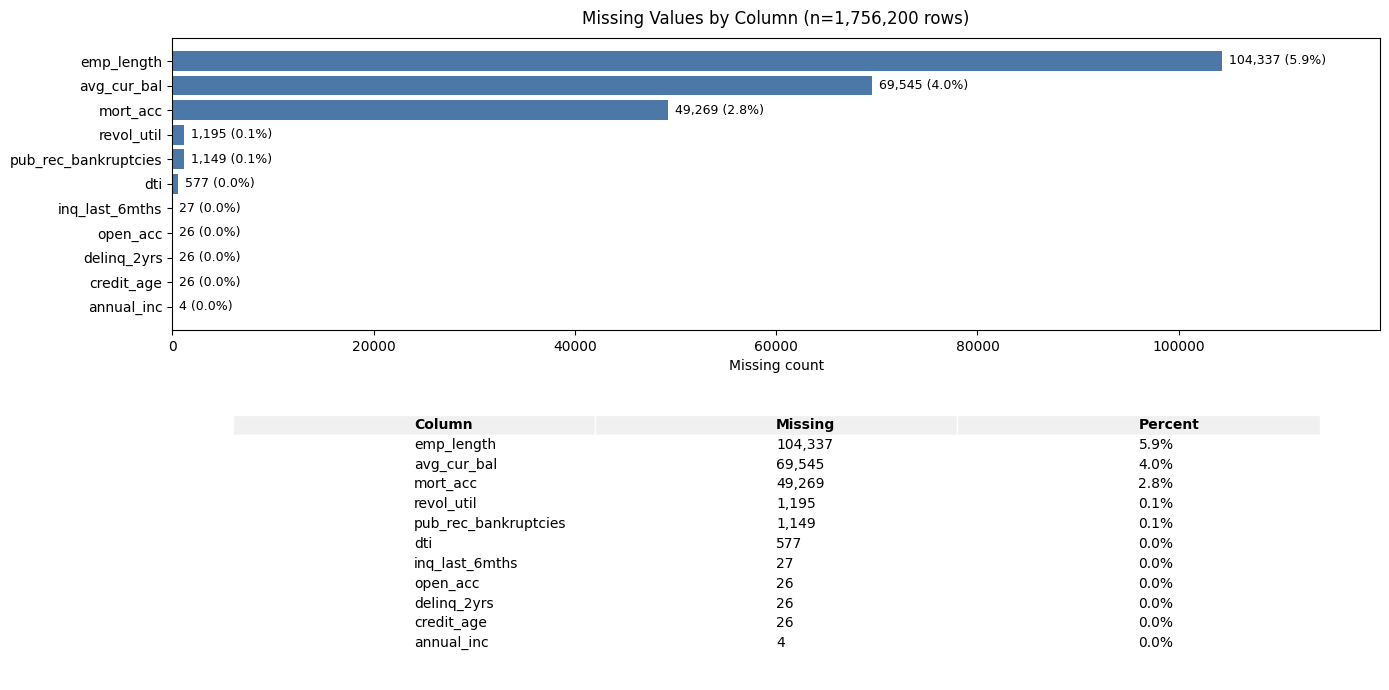

In [60]:
plot_missing_with_table(PD_df_tran)
plt.show()

Median Imputation : _avg_cur_bal_, _revol_util_, _dti_ and _annual_inc_

Mode Imputation : _mort_acc_, _pub_rec_bankruptcies_, _inq_last_6mnths_, _delinq_2yrs_, _open_acc_ and _emp_length_

In [61]:
PD_df_imp = PD_df_tran.copy()

In [62]:
# Creating dictionary for which column has which type of imputation
impute_dict = {
    "mode_col" : ["mort_acc", "pub_rec_bankruptcies", "inq_last_6mths", "delinq_2yrs", "open_acc","emp_length"],
    "median_col" : ["avg_cur_bal", "revol_util", "dti", "annual_inc", "credit_age"]
}

In [63]:
def Impute (df, impute_dict):

    # Creating dataframe to save old datatypes
    dtype = pd.DataFrame()
    dtype["Old_dtype"] = df.dtypes

    # Creating the simple imputer
    mode_imputer = SimpleImputer(strategy = "most_frequent")
    median_imputer = SimpleImputer(strategy = "median")

    # Applying the Simple Imputer
    X_mode = mode_imputer.fit_transform(df[impute_dict["mode_col"]])
    X_median = median_imputer.fit_transform(df[impute_dict["median_col"]])

    # Saving the imputed data
    df[impute_dict["mode_col"]] = pd.DataFrame(X_mode, columns = impute_dict["mode_col"], index = PD_df_imp.index)
    df[impute_dict["median_col"]]= pd.DataFrame(X_median, columns = impute_dict["median_col"], index = PD_df_imp.index)

    # Saving the new datatypes
    dtype["New_dtype"] = df.dtypes

    # Comparing the old datatypes with the new datatypes and saving any differences
    false_col = dtype.index[dtype["Old_dtype"] != dtype["New_dtype"]].tolist()

    # Incorrect datatypes are converted back into their original datatype
    for col in false_col:
        df[col] = df[col].astype(dtype.loc[col].iloc[0])

    return df

In [64]:
Impute(PD_df_imp, impute_dict)

default_12m    issue_d             purpose  loan_amnt  int_rate  \
0                  0 2016-09-01  debt_consolidation      20.00      2.34   
1                  1 2016-09-01               Other      27.14      2.62   
2                  0 2016-09-01  debt_consolidation      21.54      2.05   
3                  1 2016-09-01         credit_card      31.81      2.78   
4                  1 2016-09-01               Other      13.75      2.08   
...              ...        ...                 ...        ...       ...   
1756195            0 2017-10-01  debt_consolidation      22.89      2.41   
1756196            1 2017-10-01  debt_consolidation      22.89      2.96   
1756197            0 2017-10-01  debt_consolidation      21.54      2.29   
1756198            0 2017-10-01  debt_consolidation      22.89      2.78   
1756199            0 2017-10-01         credit_card      25.48      2.78   

               term  annual_inc  dti verification_status emp_length  \
0         36 months       45.63 3.21            Verified  4-6 years   
1         60 months       40.41 3.55        Not Verified  0-3 years   
2         36 months       51.61 3.66     Source Verified  10+ years   
3         60 months       40.21 3.42        Not Verified  10+ years   
4         36 months       32.71 2.59     Source Verified  0-3 years   
...             ...         ...  ...                 ...        ...   
1756195   60 months       38.71 4.57        Not Verified  10+ years   
1756196   60 months       31.07 4.39        Not Verified  0-3 years   
1756197   36 months       40.00 3.60     Source Verified  10+ years   
1756198   60 months       39.15 5.55        Not Verified  10+ years   
1756199   60 months       39.15 4.29        Not Verified  0-3 years   

        home_ownership  delinq_2yrs  inq_last_6mths  open_acc  revol_util  \
0             MORTGAGE         0.00            1.00     12.00       47.90   
1             MORTGAGE         2.00            0.00     18.00       31.00   
2             MORTGAGE         0.00            1.00     18.00        8.80   
3             MORTGAGE         0.00            1.00     17.00       48.10   
4                 RENT         0.00            0.00     14.00        1.40   
...                ...          ...             ...       ...         ...   
1756195       MORTGAGE         0.00            0.00     12.00       39.20   
1756196       MORTGAGE         3.00            1.00     10.00       20.20   
1756197            OWN         0.00            0.00      6.00       70.90   
1756198           RENT         2.00            1.00      8.00       34.90   
1756199           RENT         0.00            1.00     13.00       50.80   

         credit_age  mort_acc  avg_cur_bal  pub_rec_bankruptcies  \
0             23.34      3.00         7.85                  1.00   
1              7.75      1.00         9.48                  1.00   
2             14.34      2.00        10.44                  1.00   
3             23.83      3.00         9.29                  1.00   
4              7.00      0.00         7.24                  0.00   
...             ...       ...          ...                   ...   
1756195       13.75      2.00         8.32                  0.00   
1756196       14.59      4.00        10.45                  0.00   
1756197       22.66      3.00        10.36                  0.00   
1756198       14.25      0.00         9.01                  0.00   
1756199        3.50      0.00         7.59                  0.00   

         GDP_growth_rate  infl_rate  real_int_rate  UE_rate  
0                   1.82       1.26           2.64     4.87  
1                   1.82       1.26           2.64     4.87  
2                   1.82       1.26           2.64     4.87  
3                   1.82       1.26           2.64     4.87  
4                   1.82       1.26           2.64     4.87  
...                  ...        ...            ...      ...  
1756195             2.46       2.13           2.37     4.36  
17561

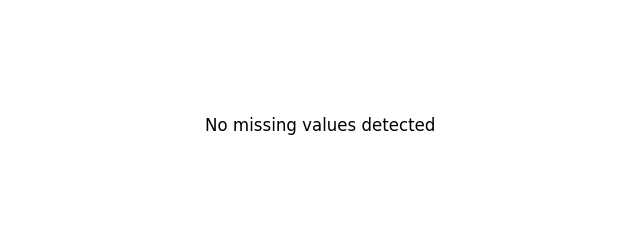

In [65]:
plot_missing_with_table(PD_df_imp)
plt.show()

In [66]:
null_comparison_df = pd.DataFrame({
    "Old_Null":PD_df_tran.isnull().sum(),
    "New_Null": PD_df_imp.isnull().sum()
}).sort_values(by = "Old_Null", ascending = False)

null_comparison_df.head(15)

Old_Null  New_Null
emp_length              104337         0
avg_cur_bal              69545         0
mort_acc                 49269         0
revol_util                1195         0
pub_rec_bankruptcies      1149         0
dti                        577         0
inq_last_6mths              27         0
open_acc                    26         0
credit_age                  26         0
delinq_2yrs                 26         0
annual_inc                   4         0
default_12m                  0         0
issue_d                      0         0
loan_amnt                    0         0
purpose                      0         0

No missing values remain

## One-Hot Encoding

All categorical variables, saved as object, will be one hot encoded to convert it into numerical data for the models. The first category will be dropped to prevent perfect correlation

In [67]:
ohe_var = ["purpose", "term", "verification_status", "emp_length", "home_ownership"]

In [68]:
def OHE (df, col):
    df_ohe = pd.get_dummies(df,
                            columns = col,
                           drop_first = True,
                           dtype = int
                           )
    return df_ohe

In [69]:
PD_df_ohe = OHE(PD_df_imp, ohe_var)
PD_df_ohe

default_12m    issue_d  loan_amnt  int_rate  annual_inc  dti  \
0                  0 2016-09-01      20.00      2.34       45.63 3.21   
1                  1 2016-09-01      27.14      2.62       40.41 3.55   
2                  0 2016-09-01      21.54      2.05       51.61 3.66   
3                  1 2016-09-01      31.81      2.78       40.21 3.42   
4                  1 2016-09-01      13.75      2.08       32.71 2.59   
...              ...        ...        ...       ...         ...  ...   
1756195            0 2017-10-01      22.89      2.41       38.71 4.57   
1756196            1 2017-10-01      22.89      2.96       31.07 4.39   
1756197            0 2017-10-01      21.54      2.29       40.00 3.60   
1756198            0 2017-10-01      22.89      2.78       39.15 5.55   
1756199            0 2017-10-01      25.48      2.78       39.15 4.29   

         delinq_2yrs  inq_last_6mths  open_acc  revol_util  credit_age  \
0               0.00            1.00     12.00       47.90       23.34   
1               2.00            0.00     18.00       31.00        7.75   
2               0.00            1.00     18.00        8.80       14.34   
3               0.00            1.00     17.00       48.10       23.83   
4               0.00            0.00     14.00        1.40        7.00   
...              ...             ...       ...         ...         ...   
1756195         0.00            0.00     12.00       39.20       13.75   
1756196         3.00            1.00     10.00       20.20       14.59   
1756197         0.00            0.00      6.00       70.90       22.66   
1756198         2.00            1.00      8.00       34.90       14.25   
1756199         0.00            1.00     13.00       50.80        3.50   

         mort_acc  avg_cur_bal  pub_rec_bankruptcies  GDP_growth_rate  \
0            3.00         7.85                  1.00             1.82   
1            1.00         9.48                  1.00             1.82   
2            2.00        10.44                  1.00             1.82   
3            3.00         9.29                  1.00             1.82   
4            0.00         7.24                  0.00             1.82   
...           ...          ...                   ...              ...   
1756195      2.00         8.32                  0.00             2.46   
1756196      4.00        10.45                  0.00             2.46   
1756197      3.00        10.36                  0.00             2.46   
1756198      0.00         9.01                  0.00             2.46   
1756199      0.00         7.59                  0.00             2.46   

         infl_rate  real_int_rate  UE_rate  purpose_credit_card  \
0             1.26           2.64     4.87                    0   
1             1.26           2.64     4.87                    0   
2             1.26           2.64     4.87                    0   
3             1.26           2.64     4.87                    1   
4             1.26           2.64     4.87                    0   
...            ...            ...      ...                  ...   
1756195       2.13           2.37     4.36                    0   
1756196       2.13           2.37     4.36                    0   
1756197       2.13           2.37     4.36                    0   
1756198       2.13           2.37     4.36                    0   
1756199       2.13           2.37     4.36                    1   

         purpose_debt_consolidation  term_ 60 months  \
0                                 1                0   
1                                 0                1   
2                                 1                0   
3                                 0                1   
4                                 0                0   
...                             ...              ...   
1756195                           1                1   
1756196                           1                1   
1756197                           1                0   
1

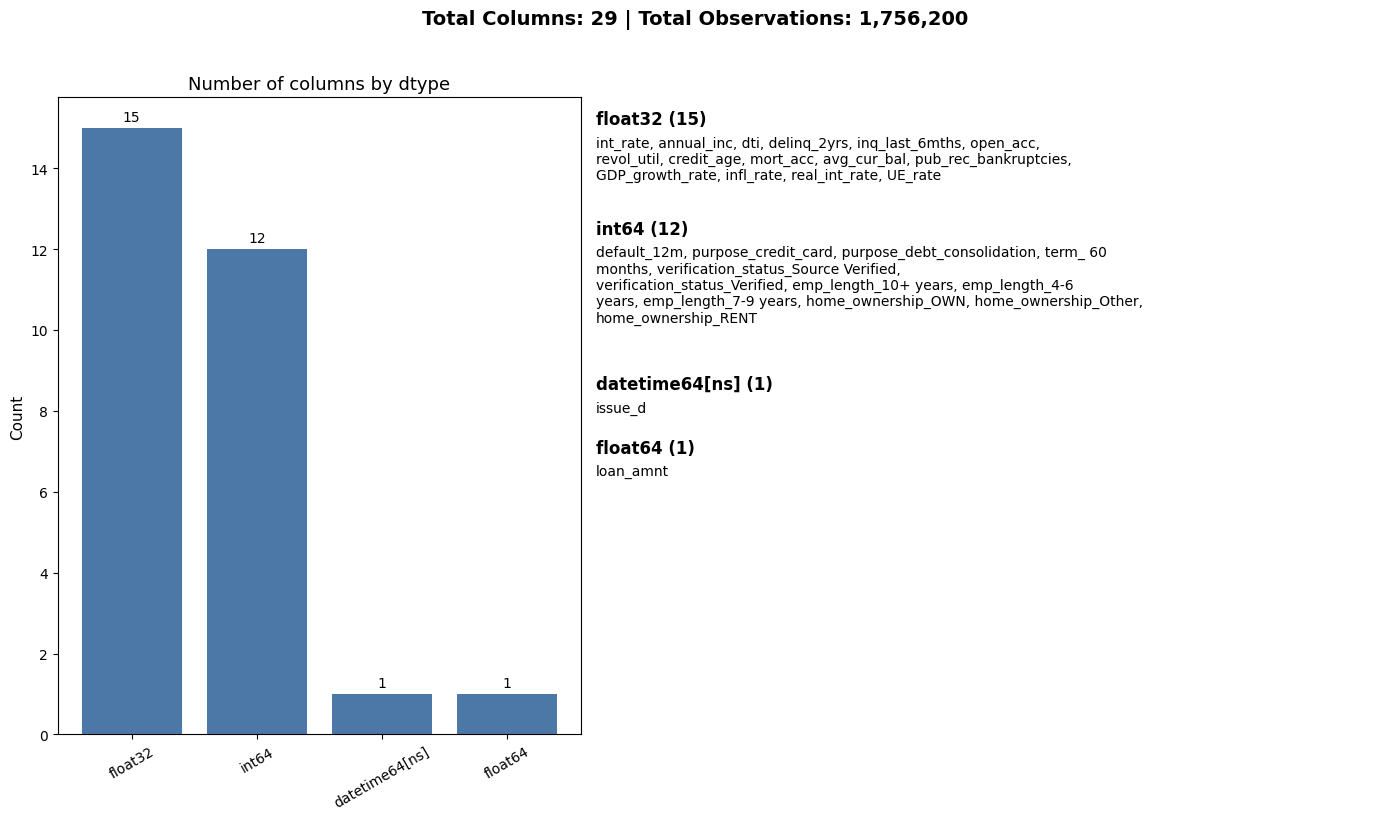

In [70]:
Plot_Dtype_Summary(PD_df_ohe)
plt.show()

## Multicollinearity

Multicollinearity might be a real problem and will affect the performance of logistic regression and linear discriminant analysis. Therefore, the Variance Inflation Factor (VIF) will be calculated for all variables.

In [71]:
# Importing the VIF package
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [72]:
# Selecting variables that will calculate VIF
VIF_col = PD_df_ohe.drop(["default_12m", "issue_d"], axis = 1).copy()

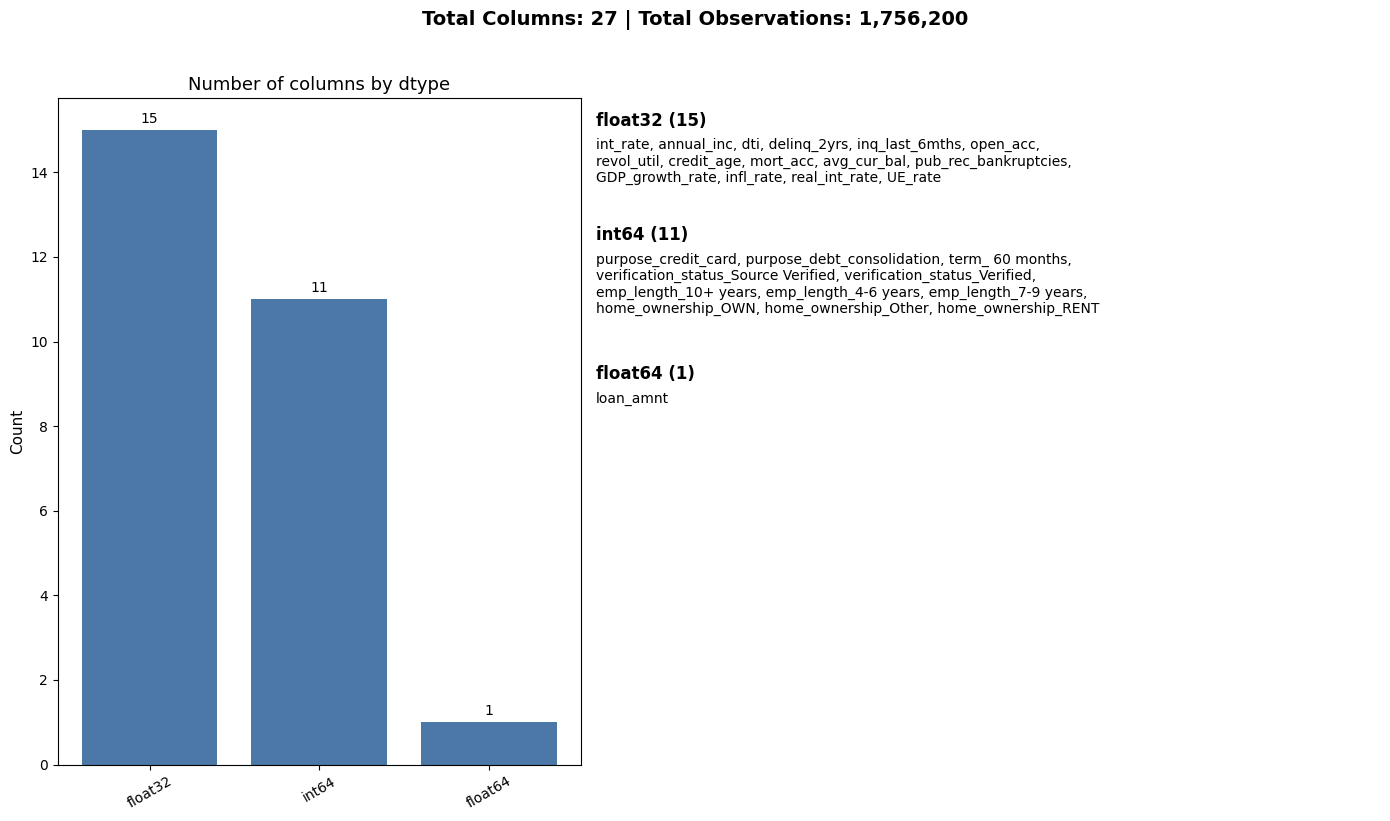

In [73]:
Plot_Dtype_Summary(VIF_col)
plt.show()

In [74]:
# Creating a table of VIF values for each variable
vif_table = pd.DataFrame({
    "feature" : VIF_col.columns,
    "VIF": [VIF(VIF_col.values, i) for i in range(VIF_col.shape[1])]
}).sort_values("VIF", ascending = False)

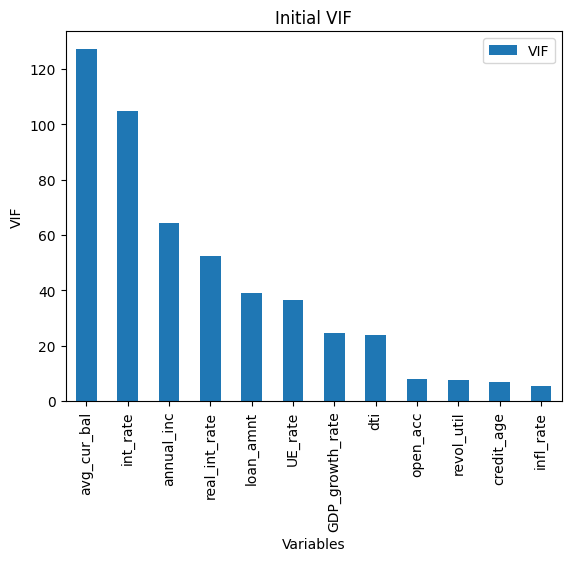

In [75]:
vif_table[vif_table["VIF"] >= 5].plot(x = "feature", y = "VIF", kind = "bar", xlabel = "Variables", ylabel = "VIF")
plt.title("Initial VIF")
plt.show()

In [76]:
vif_table[vif_table["VIF"] >= 5]

feature    VIF
10      avg_cur_bal 127.25
1          int_rate 104.90
2        annual_inc  64.47
14    real_int_rate  52.52
0         loan_amnt  38.92
15          UE_rate  36.56
12  GDP_growth_rate  24.48
3               dti  23.73
6          open_acc   7.98
7        revol_util   7.61
8        credit_age   6.96
13        infl_rate   5.46

Extremely high VIF for _GDP_growth_rate_, _real_int_rate_, _UE_rate_ and _int_rate_.

Moderately high VIF for _open_acc_, _revol_util_, _dti_, _credit_age_ and _loan_amnt_

A few variables must be dropped based on their correlation with one another

In [77]:
corr = VIF_col.corr()

threshold = 0.7

mask = np.triu(np.ones_like(corr, dtype = bool), k = 1)

corr_long = (
    corr.where(mask)
    .stack()
    .reset_index(name = "corr")
)

high_corr = corr_long[corr_long["corr"].abs() >= threshold].sort_values(by = "corr", key = lambda s : s.abs(), ascending = False)

high_corr

level_0  level_1  corr
273  real_int_rate  UE_rate -0.76

It seems that only _real_int_rate_ and _UE_rate_ are significantly correlated with one another. Thus, we will drop _real_int_rate_ because it would intuitively also correlate with _int_rate_.

Furthermore:
- _avg_cur_bal_ will be dropped because it would correlate too much with _annual_inc_ which both measure overall wealth.
- _infl_rate_ will be dropped because it correlates too much with _GDP_growth_rate_ and _UE_rate_ which measure the overall health of the economy.

In [78]:
VIF_col1 = VIF_col.drop(["avg_cur_bal", "real_int_rate", "infl_rate"], axis = 1)

In [79]:
vif_table1 = pd.DataFrame({
    "feature" : VIF_col1.columns,
    "VIF": [VIF(VIF_col1.values, i) for i in range(VIF_col1.shape[1])]
}).sort_values("VIF", ascending = False)

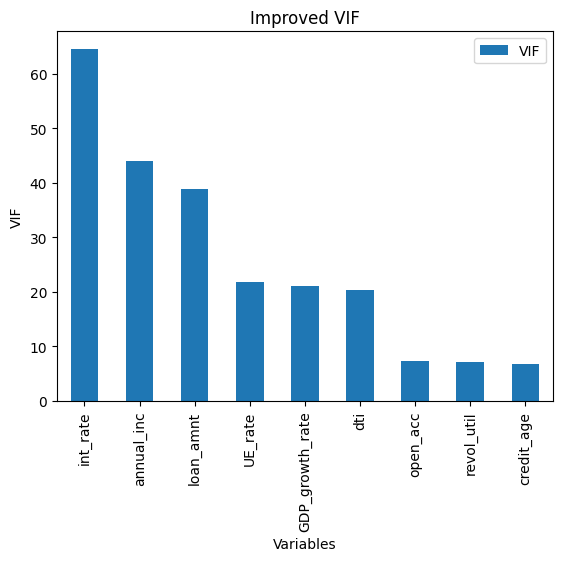

In [80]:
vif_table1[vif_table1["VIF"] >= 5].plot(x = "feature", y = "VIF", kind = "bar", xlabel = "Variables", ylabel = "VIF")
plt.title("Improved VIF")
plt.show()

In [81]:
vif_table1[vif_table1["VIF"] >= 5]

feature   VIF
1          int_rate 64.58
2        annual_inc 44.04
0         loan_amnt 38.82
12          UE_rate 21.82
11  GDP_growth_rate 21.04
3               dti 20.32
6          open_acc  7.36
7        revol_util  7.07
8        credit_age  6.86

In [82]:
print(f'Old Total VIF: {vif_table["VIF"].sum():,.0f}')
print(f'New Total VIF: {vif_table1["VIF"].sum():,.0f}')
print(f'Old Mean VIF: {vif_table["VIF"].mean():,.2f}')
print(f'New Mean VIF: {vif_table1["VIF"].mean():,.2f}')

Old Total VIF: 531
New Total VIF: 261
Old Mean VIF: 19.68
New Mean VIF: 10.89


After dropping those three variables, the VIF has dropped significantly but they are still elevated for int_rate, annual_inc, loan_amnt, UE_rate, GDP_growth_rate and dti. Thus, we will need to perform regularization for the logistic regression to drop any meaningless or over-correlated variables.

In [83]:
# Dropping variables with high multicollinearity
PD_df_vif = PD_df_ohe.drop(["avg_cur_bal", "real_int_rate", "infl_rate"], axis = 1)

## Standard Scaling

Scaling is essential to avoid bias from feature magnitude because algorithms such as logistic regression, LDA and probit use distance or gradient-based optimization which might lead to one feature dominating the model (E.G. loan_amnt dominating over GDP_growth_rate). Furthermore, scaling improves convergence in gradient based models, ensures fairness in regularization (which must be applied due to high VIF) and makes coefficients comparable across features.


Discrete numeric variables like _mort_acc_, _delin1_2yrs_, _inq_last_6mths_, _open_acc_ and _pub_rec_bankruptcies_ will not be scaled. The continuous numeric variables will be scaled. 

sklearn's StandardScaler will be used scale these variables.

In [84]:
from sklearn.preprocessing import StandardScaler

In [85]:
PD_df_scal = PD_df_vif.copy()

In [86]:
# Selecting which columns to scale
scale_col = ["loan_amnt", "int_rate", "annual_inc", "dti", "revol_util", "GDP_growth_rate", "UE_rate"]

In [87]:
def Scale(df, col):
    # Setting up Standard Scaler
    scaler = StandardScaler(with_mean=True, with_std = True)

    # Applying Standard Scaler
    X_scaled = scaler.fit_transform(df[col])

    # Saving scaled values
    df[col] = pd.DataFrame(X_scaled, columns = col, index = df.index)

    return df

In [88]:
PD_df_scal = Scale(PD_df_scal, scale_col)
PD_df_scal

default_12m    issue_d  loan_amnt  int_rate  annual_inc   dti  \
0                  0 2016-09-01      -0.68      0.03        0.62 -0.88   
1                  1 2016-09-01       0.72      1.04       -0.08 -0.56   
2                  0 2016-09-01      -0.38     -1.01        1.43 -0.46   
3                  1 2016-09-01       1.63      1.62       -0.11 -0.68   
4                  1 2016-09-01      -1.90     -0.89       -1.11 -1.44   
...              ...        ...        ...       ...         ...   ...   
1756195            0 2017-10-01      -0.11      0.31       -0.31  0.38   
1756196            1 2017-10-01      -0.11      2.24       -1.33  0.21   
1756197            0 2017-10-01      -0.38     -0.14       -0.13 -0.52   
1756198            0 2017-10-01      -0.11      1.61       -0.25  1.28   
1756199            0 2017-10-01       0.39      1.61       -0.25  0.12   

         delinq_2yrs  inq_last_6mths  open_acc  revol_util  credit_age  \
0               0.00            1.00     12.00       -0.17       23.34   
1               2.00            0.00     18.00       -0.87        7.75   
2               0.00            1.00     18.00       -1.78       14.34   
3               0.00            1.00     17.00       -0.17       23.83   
4               0.00            0.00     14.00       -2.09        7.00   
...              ...             ...       ...         ...         ...   
1756195         0.00            0.00     12.00       -0.53       13.75   
1756196         3.00            1.00     10.00       -1.31       14.59   
1756197         0.00            0.00      6.00        0.77       22.66   
1756198         2.00            1.00      8.00       -0.71       14.25   
1756199         0.00            1.00     13.00       -0.05        3.50   

         mort_acc  pub_rec_bankruptcies  GDP_growth_rate  UE_rate  \
0            3.00                  1.00            -1.10    -0.47   
1            1.00                  1.00            -1.10    -0.47   
2            2.00                  1.00            -1.10    -0.47   
3            3.00                  1.00            -1.10    -0.47   
4            0.00                  0.00            -1.10    -0.47   
...           ...                   ...              ...      ...   
1756195      2.00                  0.00             0.18    -0.93   
1756196      4.00                  0.00             0.18    -0.93   
1756197      3.00                  0.00             0.18    -0.93   
1756198      0.00                  0.00             0.18    -0.93   
1756199      0.00                  0.00             0.18    -0.93   

         purpose_credit_card  purpose_debt_consolidation  term_ 60 months  \
0                          0                           1                0   
1                          0                           0                1   
2                          0                           1                0   
3                          1                           0                1   
4                          0                           0                0   
...                      ...                         ...              ...   
1756195                    0                           1                1   
1756196                    0                           1                1   
1756197                    0                           1                0   
1756198                    0                           1                1   
1756199                    1                           0                1   

         verification_status_Source Verified  verification_status_Verified  \
0                                          0                             1   
1                                          0                             0   
2                                          1                             0   
3                                          0                             0   
4                                          1                             0   
...      

In [89]:
# Checking if StandardScaler has been applied correctly
scaler_summary = pd.DataFrame({
    "mean_orig" : PD_df_vif[scale_col].mean(),
    "std_orig" : PD_df_vif[scale_col].std(),
    "mean_scaled" : PD_df_scal[scale_col].mean(),
    "std_scaled" : PD_df_scal[scale_col].std()
})

scaler_summary

mean_orig  std_orig  mean_scaled  std_scaled
loan_amnt            23.47      5.11         0.00        1.00
int_rate              2.33      0.28        -0.00        1.00
annual_inc           40.99      7.45        -0.00        1.00
dti                   4.16      1.09         0.00        1.00
revol_util           52.12     24.30        -0.00        1.00
GDP_growth_rate       2.37      0.50         0.00        1.00
UE_rate               5.40      1.12         0.00        1.00

Scaling has been applied successfully

## Splitting Data into Train, Validation and Test Data

As previously mentioned, the data is from Jun 1st 2007 until Dec 31st 2017. 

- Train data : Jun 2007 - Dec 2015 
- Validation data : 2016 
- Testing : 2017

In [90]:
# Defining the end date for training window
Train_End = pd.Timestamp("2015-12-31")

# Defining the end date for validation window
Valid_End = pd.Timestamp("2016-12-31")

# Defining the start date for testing window
Test_Start = pd.Timestamp("2017-01-01")

In [91]:
# Creating training data window
PD_df_train = PD_df_scal[PD_df_scal["issue_d"] <= Train_End].copy()

# Creating validation data window
PD_df_valid = PD_df_scal[(PD_df_scal["issue_d"] > Train_End) & (PD_df_scal["issue_d"] <= Valid_End)].copy()

# Creating testing data window
PD_df_test = PD_df_scal[PD_df_scal["issue_d"] >= Test_Start]

In [92]:
# Defining training features
Final_Features = ["loan_amnt", "int_rate", "annual_inc", "dti",
       "delinq_2yrs", "inq_last_6mths", "open_acc", "revol_util", "credit_age",
       "mort_acc", "pub_rec_bankruptcies", "GDP_growth_rate", "UE_rate",
       "purpose_credit_card", "purpose_debt_consolidation", "term_ 60 months",
       "verification_status_Source Verified", "verification_status_Verified",
       "emp_length_10+ years", "emp_length_4-6 years", "emp_length_7-9 years",
       "home_ownership_OWN", "home_ownership_Other", "home_ownership_RENT"]

# Defining target features
Target_Col = ["default_12m"]

In [93]:
# Creating training and target feature for training window
x_train = PD_df_train[Final_Features].copy()
y_train = PD_df_train[Target_Col].copy()

# Creating training and target feature for validation window
x_valid = PD_df_valid[Final_Features].copy()
y_valid = PD_df_valid[Target_Col].copy()

# Creating training and target feature for testing window
x_test = PD_df_test[Final_Features].copy()
y_test = PD_df_test[Target_Col].copy()

In [94]:
# Collapsing target feature dataframes into an array
y_train = np.asarray(y_train).astype(int).ravel()
y_valid = np.asarray(y_valid).astype(int).ravel()
y_test = np.asarray(y_test).astype(int).ravel()

# Phase 3: Model Training

## Setup

### Importing Libraries

Importing the relevant libraries

In [95]:
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, log_loss, precision_recall_curve, average_precision_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import chi2
from scipy.special import logit as LT

from matplotlib.ticker import FuncFormatter, MaxNLocator, MultipleLocator

plt.rcParams["figure.dpi"] = 120
sns.set(style = "whitegrid")

### Defining Functions

#### metrics

The metrics function creates various metrics to determine a model's performance across multiple dimensions such as discrimination, calibration and operating-point quality. This provides ample metrics to determine which model is the best out of a subset.

The metrics included in this function are:
1. AUC (Area Under the ROC Curve)\
AUC measures the ability of the model to rank observations correctly by risk. It represents the probability that a randomly chosen default will have a higher predicted score than a randomly chosen non-default. Higher AUC means better ranking power, which is critical for approval segmentation and risk-based decisioning.

    0.5: No discrimination (random guess).\
    0.6–0.7: Modest discrimination.\
    ≥ 0.75: Strong discrimination.

2. GINI\
GINI is a linear transformation of AUC:\
GINI = 2 * AUC−1\
It measures the same concept as AUC but is widely used in credit risk governance and is often required in regulatory reporting and model validation packs.


    0: No discrimination.\
    0.2–0.3: Modest.\
    ≥ 0.4: Strong.

3. Brier Score\
Measures the mean squared error between predicted probabilities and actual outcomes. It Captures both calibration and discrimination while being sensitive to probability fidelity.\
Generally, the a lower score is better compared to the baseline (constant predictor at event rate)

5. LogLoss (Logarithmic Loss)\
Measures the negative log-likelihood of predicted probabilities. Penalizes extreme miscalibration more heavily than Brier. Important for governance and IFRS/CECL PD validation.\
Generally, the a lower score is better compared to the baseline (constant predictor at event rate)

7. Avg_PD (Average Predicted Probability of Default)\
Mean of all predicted PDs across the portfolio. Should be close to the event rate (portfolio bad rate). Large deviations indicate calibration-in-the-large issues.

8. Avg_PD_Error\
Absolute difference between Avg_PD and the actual event rate. Quick check for global calibration. High error means PDs are systematically biased.

9. Avg_Prec (Average Precision)\
Area under the Precision-Recall curve. Focuses on performance for the positive class (defaults), especially useful when class imbalance exists. Higher AP means better precision for defaults at various thresholds.

10. HL_Stat (Hosmer–Lemeshow Statistic)\
Chi-square statistic comparing observed vs expected defaults across decile bins of predicted PD. Tests calibration quality. High HL statistic (and low p-value) means poor calibration.

11. HL_p (Hosmer–Lemeshow p-value)\
p-value from HL test.

    Above 0.05: No evidence of miscalibration.\
    Roughly equal to 0: Strong evidence of miscalibration.

12. CalSlope (Calibration Slope)\
Slope from regressing actual outcomes on logit of predicted PDs. Ensures that probabilty of scaling is correct across the risk spectrum. 

    Ideal: ~1.\
    Less than 1: Predictions too extreme (overfitting).\
    More than 1: Predictions too flat.


13. CalIntercept (Calibration Intercept)\
    Intercept from calibration regression. This indicates the calibration-in-the-large (global bias). A wide gap between intercept and 0 means that the model's average PD is misaligned with the portfolio event rate causing systematic overpricing or underpricing

    Ideal: ~0.\
    Negative: Model overpredicts PD globally.\
    Positive: Model underpredicts PD globally.


14. Portfolio_Bad_Rate\
    Observed default rate in the portfolio

15. Top_Decile_Bad_Rate\
Observed default rate in the riskiest 10% of applicants by predicted PD. Shows risk concentration in top decile—critical for decline tiers and manual review prioritization.

16. Lift\
Ratio of Top-Decile Bad Rate to Portfolio Bad Rate. Higher lift = better ranking power. (E.G. 1.65× means top 10% are 65% more likely to default than average.)

In [96]:
def metrics (y_true, y_prob):

    eps = 1e-12
    g = 10
    # Create quantile bins; drop duplicates if not enough unique values
    bins = pd.qcut(y_prob, q=g, duplicates='drop')
    
    df = pd.DataFrame({'y': y_true, 'p': y_prob, 'bin': bins}).sort_values("p", ascending = False)
    
    grp = df.groupby('bin', observed=True).agg(
        n=('y', 'size'),
        obs_bad=('y', 'sum'),
        exp_bad=('p', 'sum')
    ).reset_index()

    grp['obs_good'] = grp['n'] - grp['obs_bad']
    grp['exp_good'] = grp['n'] - grp['exp_bad']

    # Chi-square components; guard against zero expectations
    hl_terms = ((grp['obs_bad'] - grp['exp_bad'])**2 / (grp['exp_bad'] + eps)) + \
               ((grp['obs_good'] - grp['exp_good'])**2 / (grp['exp_good'] + eps))
    hl_stat = hl_terms.sum()

    df_chi = max(len(grp) - 2, 1)  # degrees of freedom g-2, min 1 to avoid zero df
    hl_p = 1.0 - chi2.cdf(hl_stat, df_chi)

    p = np.clip(np.asarray(y_prob), eps, 1 - eps)
    z = LT(p).reshape(-1, 1)

    # Fit logistic regression on logit(p) (no regularization if supported)
    lr = LogisticRegression(penalty=None, 
                            solver='lbfgs', 
                            max_iter=1000)

    lr.fit(z, y_true)

    # Creating Lift metrics
    overall_bad_rate = df["y"].mean()

    top_n = int(len(df) * 0.1)
    top_bad_rate = df.iloc[:top_n]["y"].mean()

    lift = top_bad_rate / overall_bad_rate
    
    return{
        "AUC" : roc_auc_score(y_true, y_prob),
        "Brier" : brier_score_loss(y_true, y_prob),
        "LogLoss" : log_loss(y_true, np.vstack([1 - y_prob, y_prob]).T, labels = [0,1]),
        "Avg_PD" : float(np.mean(y_prob)), # Average Probability of Default
        "Avg_PD_Error": float(abs(np.mean(y_prob) - float(np.mean(y_true)))), #Average Error in Probability of Default
        "Avg_Prec" : average_precision_score(y_true, y_prob),
        "GINI" : 2.0 * roc_auc_score(y_true, y_prob) - 1.0,
        "HL_Stat": float(hl_stat),
        "HL_p": float(hl_p),
        "CalSlope": float(lr.coef_[0][0]),
        "CalIntercept": float(lr.intercept_[0]),
        "Portfolio_Bad_Rate" : overall_bad_rate,
        "Top_Decile_Bad_Rate" : top_bad_rate,
        "Lift" : lift
    }

#### composite_score

The composite_score function creates a single summary metric to rank models by combining multiple performance dimensions—discrimination, calibration, and operating-point quality—into one normalized score. This helps stakeholders quickly identify the best-performing models without relying on a single metric like AUC.

**How It Works**:

1) Each metric is scaled to a 0–1 range using min-max normalization:
- For metrics where higher is better (e.g., AUC), normalization is direct.
- For metrics where lower is better (e.g., Brier, LogLoss, Avg_PD_Error), normalization is inverted.

2) Apply Weights:
- The normalized metrics are combined using a weighted sum:
- CompositeScore = (0.40 * auc_norm + 0.15 * brier_norm + 0.10 * logloss_norm + 0.05 * align_norm + 0.15 * hl_norm + 0.10 * slope_norm + 0.05 * intercept_norm)

3) Rank Models:
Models are sorted by CompositeScore in descending order.




**Metrics Included**:

1) Discrimination:
- AUC (40%): Primary measure of ranking power.

2) Calibration:

- Brier Score (15%): Captures overall probability accuracy.
- LogLoss (10%): Penalizes extreme miscalibration.
- Avg_PD_Error (5%): Ensures global PD alignment.
- Hosmer–Lemeshow p-value (15%): Tests calibration across buckets.
- Calibration Slope (10%): Checks scaling of predicted PDs.
- Calibration Intercept (5%): Checks global bias in PDs.


**Why These Weights?**

- Discrimination (40%):\
  Ranking power is critical for approval segmentation and risk tiering. AUC gets the largest share (30%) because it is the most robust measure of discrimination.


- Calibration (60%):\
    PD fidelity is essential for pricing, limits, IFRS 9/CECL, and governance. Calibration metrics collectively dominate the composite score because miscalibrated PDs can lead to material financial and regulatory risk.

**Interpretation**

Higher CompositeScore = Better overall model performance across discrimination, calibration, and governance dimensions.\
A model with strong AUC but poor calibration will score lower than a model with slightly lower AUC but excellent calibration—reflecting real-world governance priorities. 

In [97]:
def composite_score (comparison):
    # Min-max normalize each metric to 0..1 where higher is better
    # For "lower is better" metrics, invert after scaling.
    df = comparison.copy()

    # Helper arrays to normalize each metric
    eps = 1e-12
    slope_cap = 0.5
    intercept_cap = 0.5
    
    auc_norm = (df["AUC"] - df["AUC"].min()) / (df["AUC"].max() - df["AUC"].min() + eps)
    brier_norm = 1.0 - (df["Brier"] - df["Brier"].min()) / (df["Brier"].max() - df["Brier"].min() + eps)
    logloss_norm = 1.0 - (df["LogLoss"] - df["LogLoss"].min()) / (df["LogLoss"].max() - df["LogLoss"].min() + eps)
    align_norm = 1.0 - (df["Avg_PD_Error"] - df["Avg_PD_Error"].min()) / (df["Avg_PD_Error"].max() - df["Avg_PD_Error"].min() + eps)

    # HL p-value already lies in [0,1]: larger is better
    hl_norm = df["HL_p"].clip(0, 1)

    # Calibration slope: distance from 1 (ideal). Cap the penalty for robustness.
    slope_dev = np.abs(df["CalSlope"] - 1.0)
    slope_norm = 1.0 - np.minimum(slope_dev, slope_cap) / slope_cap

    # Calibration intercept: distance from 0 (ideal). Cap penalty.
    intercept_dev = np.abs(df["CalIntercept"])
    intercept_norm = 1.0 - np.minimum(intercept_dev, intercept_cap) / intercept_cap

    # Composite score weights
    df["CompositeScore"] = (
        0.40 * auc_norm +
        0.15 * brier_norm +
        0.10 * logloss_norm +
        0.05 * align_norm +
        0.15 * hl_norm +
        0.10 * slope_norm +
        0.05 * intercept_norm
    )

    # Sort and return a neat view
    cols = ["Model", "AUC", "GINI", "Brier", "LogLoss", "Avg_PD", "Avg_PD_Error", "HL_Stat", "HL_p", "CalSlope", "CalIntercept", "CompositeScore"]
    
    # Sort columns
    df_sorted = df.sort_values("CompositeScore", ascending=False).reset_index(drop=True)
    
    return df_sorted[cols]

#### model_visualisations

This model_visualisations function will be used to visualise the outputs of the model. It includes an ROC curve, a Pricision-Recall Curve, a Calibration/Reliability Diagram, Score Density, Kolmogrov-Smirnov Chart, Lift Curve and also a Gain Curve. These visualisations will provide a comprehensive look at the various model's performance

1) Receiver Operating Characteristic (ROC) Curve\
    Measures the trade off between true positive rate and false positive rate across all thresholds. The key metrics used is Area Under Curve (AUC) which measures the discrimination ability of the model. A good model would have a steep rise to the top-left corner which shows that the model has a strong ability to rank defaults vs non-defaults at all thresholds. 

2) Precision-Recall Curve\
    Shows the trade-off between Precision and Recall with Precision being the accuracy among predicted defaults and recall being the coverage of actual defaults. A good curve would have a high precision and recall with a high AUC compared to base default rate. This is important for imbalanced datasets where defaults are rare.

3) Reliability Diagram / Calibration Curve\
Compares the predicted probability of default compared to the observed default rate in various bins. A good curve would be almost diagonal. If a curve is above diagonal, it would be underpredicting. Likewise, if a curve is a below the diagonal then it would be under-predicting.

4) Kolmogorov - Smirnov (KS) Chart\
Shows the cumulative % of goods vs bads across the score distributions. The KS metric measures the maximum separation between good (non-default) and bad (defaults). A higher KS means better rank ordering.

5) Lift/Gain Curves\
Gain shows the percentage of defaults captured by the top percent of the population. Lift shows how much better than random selection. A good Gain curve would be steep while a good lift would be above 3 for top deciles. It demonstrates business value for targeting high risk accounts.

In [98]:
def model_visualisation(y_proba, model, y_test = y_test, fig_size = (25, 12), label_font = 16, title_font = 20):

    met = metrics(y_test, y_proba)

    fig, axs = plt.subplots(2, 3, layout = "tight", figsize = fig_size)

    # ROC Curve
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    plt.sca(axs[0,0])
    plt.plot(fpr, tpr, label = f"ROC (AUC: {met["AUC"]:.3f})", color = "#1f77b4", lw = 2)
    plt.tight_layout()
    plt.plot([0,1], [0,1], "k--", lw = 1)
    plt.xlabel("False Positive Rate", fontsize = label_font)
    plt.ylabel("True Positive Rate (Recall)", fontsize = label_font)
    plt.title("ROC Curve (Test)", fontsize = title_font)
    plt.legend(loc = "lower right")
    plt.grid(True)

    # Precision-Recall Curve
    prec, rec, thr_pr = precision_recall_curve(y_test, y_proba)
    f1 = f1_score(y_test, (y_proba >= 0.5).astype(int))
    plt.sca(axs[0,1])
    plt.plot(rec, prec, color="#2ca02c", lw=2)
    base_rate = np.mean(y_test)
    plt.hlines(base_rate, 0, 1, colors="k", linestyles="--", label=f"Baseline (rate={base_rate:.3f})")
    plt.xlabel("Recall", fontsize = label_font)
    plt.ylabel("Precision", fontsize = label_font)
    plt.title(f"Precision–Recall (AP = {met["Avg_Prec"]:.3f}, F1 = {f1:.3f})", fontsize = title_font)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.grid(True)

    # Calibration/Reliability Diagram
    frac_pos, mean_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="quantile")
    plt.sca(axs[0,2])
    plt.plot(mean_pred, frac_pos, "o-", label="LDA", color="#d62728")
    plt.plot([0, 1], [0, 1], "k--", label="Perfect")
    plt.xlabel("Predicted probability (bin mean)", fontsize = label_font)
    plt.ylabel("Observed default rate", fontsize = label_font)
    plt.title("Reliability Diagram (Test)", fontsize = title_font)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.grid(True)
    
    # KS Chart
    order = np.argsort(y_proba)
    y_sorted = y_test[order]
    scores_sorted = y_proba[order]

    cum_good = np.cumsum(1 - y_sorted) / np.sum(1 - y_sorted)
    cum_bad  = np.cumsum(y_sorted) / np.sum(y_sorted)
    ks_values = np.abs(cum_bad - cum_good)
    ks_idx = np.argmax(ks_values)
    ks_score = ks_values[ks_idx]
    ks_threshold = scores_sorted[ks_idx]

    plt.sca(axs[1,0])
    plt.plot(scores_sorted, cum_bad, label="Cumulative Bad (Default)", color="#d62728")
    plt.plot(scores_sorted, cum_good, label="Cumulative Good (Non-default)", color="#1f77b4")
    plt.vlines(ks_threshold, cum_good[ks_idx], cum_bad[ks_idx], colors="gray", linestyles="--",
           label=f"KS = {ks_score:.3f} at score={ks_threshold:.3f}")
    plt.xlabel("Predicted PD (LDA)", fontsize = label_font)
    plt.ylabel("Cumulative share", fontsize = label_font)
    plt.title("KS Curve (Test)", fontsize = title_font)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.grid(True)

    # Lift/Gain Curve
    df_scores = pd.DataFrame({"y": y_test, "score": y_proba}).sort_values("score", ascending=False).reset_index(drop=True)
    df_scores["cum_obs"] = np.arange(1, len(df_scores)+1)
    df_scores["cum_bad"] = df_scores["y"].cumsum()

    total_bad = df_scores["y"].sum()
    total_obs = len(df_scores)
    baseline_rate = total_bad / total_obs

    df_scores["cum_bad_rate"] = df_scores["cum_bad"] / df_scores["cum_obs"]
    df_scores["lift"] = df_scores["cum_bad_rate"] / baseline_rate
    df_scores["perc_pop"] = df_scores["cum_obs"] / total_obs
    df_scores["gain"] = df_scores["cum_bad"] / (total_bad + 1e-12)  # share of bads captured

    # Plotting the Gain Curve
    plt.sca(axs[1,1])
    plt.plot(df_scores["perc_pop"], df_scores["gain"], lw=2, label="Gain")
    plt.plot([0,1], [0,1], "k--", label="Baseline")
    plt.xlabel("Share of population targeted", fontsize = label_font)
    plt.ylabel("Share of defaults captured", fontsize = label_font)
    plt.title("Gain Curve (Test)", fontsize = title_font)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)

    # Plotting the Lift Curve
    plt.sca(axs[1,2])
    plt.plot(df_scores["perc_pop"], df_scores["lift"], lw=2, color="#9467bd")
    plt.hlines(1.0, 0, 1, colors="k", linestyles="--", label="Baseline lift=1")
    plt.xlabel("Share of population targeted", fontsize = label_font)
    plt.ylabel("Cumulative lift", fontsize = label_font)
    plt.title("Lift Curve (Test)", fontsize = title_font)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    
    fig.suptitle(f"{model} Visualisations", fontsize = 25, y = 1.025)
    plt.show()

#### feature_loadings

This feature_loadings function will be used to present the top 24 features that contribute to the model's prediction. Each feature is usually scored on how much it reduces impurity across all splits in the tree.

In [99]:
def feature_loadings (model, model_title, train_data = x_train):
    # Extract feature names from training data
    feature_names = train_data.columns.tolist()

    # LDA coefficients → positive = toward DEFAULT (class 1), negative = toward NON-DEFAULT (class 0)
    coefs = model.coef_[0]
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)

    # Plot top drivers
    top_n = 24 
    top_pos = coef_df.nlargest(top_n, "coef")       # strongest toward default
    top_neg = coef_df.nsmallest(top_n, "coef")      # strongest toward non-default

    fig, axs = plt.subplots(1, 2, layout = "tight", figsize = (14, top_n*0.28))

    plt.sca(axs[0])
    sns.barplot(data=top_pos, y="feature", x="coef", color="#d62728")
    plt.title(f"{model_title} - Top Positive Loadings (toward DEFAULT)")
    plt.xlabel("Coefficient")
    plt.ylabel("")
    plt.tight_layout()
    plt.grid(True)

    plt.sca(axs[1])
    sns.barplot(data=top_neg.sort_values("coef"), y="feature", x="coef", color="#1f77b4")
    plt.title(f"{model_title} - Top Negative Loadings (toward NON-DEFAULT)")
    plt.xlabel("Coefficient")
    plt.ylabel("")
    plt.tight_layout()
    plt.grid(True)
    
    plt.show()

## Linear Discriminant Analysis (LDA)

In [100]:
# List of different solvers for hyperparameter tuning
lda_solver = ["svd", "lsqr", "eigen"]
lda_res = []

In [101]:
# Training the LDA model for each hyperparameter, testing on validation data and saving metrics for each model
for sol in lda_solver:
    lda = LinearDiscriminantAnalysis(
        solver = sol,
        shrinkage = None if sol == "svd" else "auto",
    ) 
    lda.fit(x_train, y_train)
    lda_val = lda.predict_proba(x_valid)[:, 1]
    lda_res.append({"Model" : lda, **metrics(y_valid, lda_val)})

In [102]:
# Creating the composite score for each LDA model
lda_df = composite_score(pd.DataFrame(lda_res))
lda_df

Model  AUC  GINI  Brier  \
0                       LinearDiscriminantAnalysis() 0.64  0.28   0.20   
1  LinearDiscriminantAnalysis(shrinkage='auto', s... 0.64  0.28   0.20   
2  LinearDiscriminantAnalysis(shrinkage='auto', s... 0.64  0.28   0.20   

   LogLoss  Avg_PD  Avg_PD_Error  HL_Stat  HL_p  CalSlope  CalIntercept  \
0     0.59    0.31          0.00   358.97  0.00      0.88         -0.09   
1     0.59    0.31          0.00   358.90  0.00      0.88         -0.09   
2     0.59    0.31          0.00   358.90  0.00      0.88         -0.09   

   CompositeScore  
0            0.82  
1            0.12  
2            0.12

It seems that the base LDA model with no hyperparameters is the best

In [103]:
# Selecting the best performing model
best_lda = lda_df.iloc[0,0]
print(best_lda)

LinearDiscriminantAnalysis()


In [104]:
# Testing the best model on test data
pd_lda = best_lda.predict_proba(x_test)[:, 1]

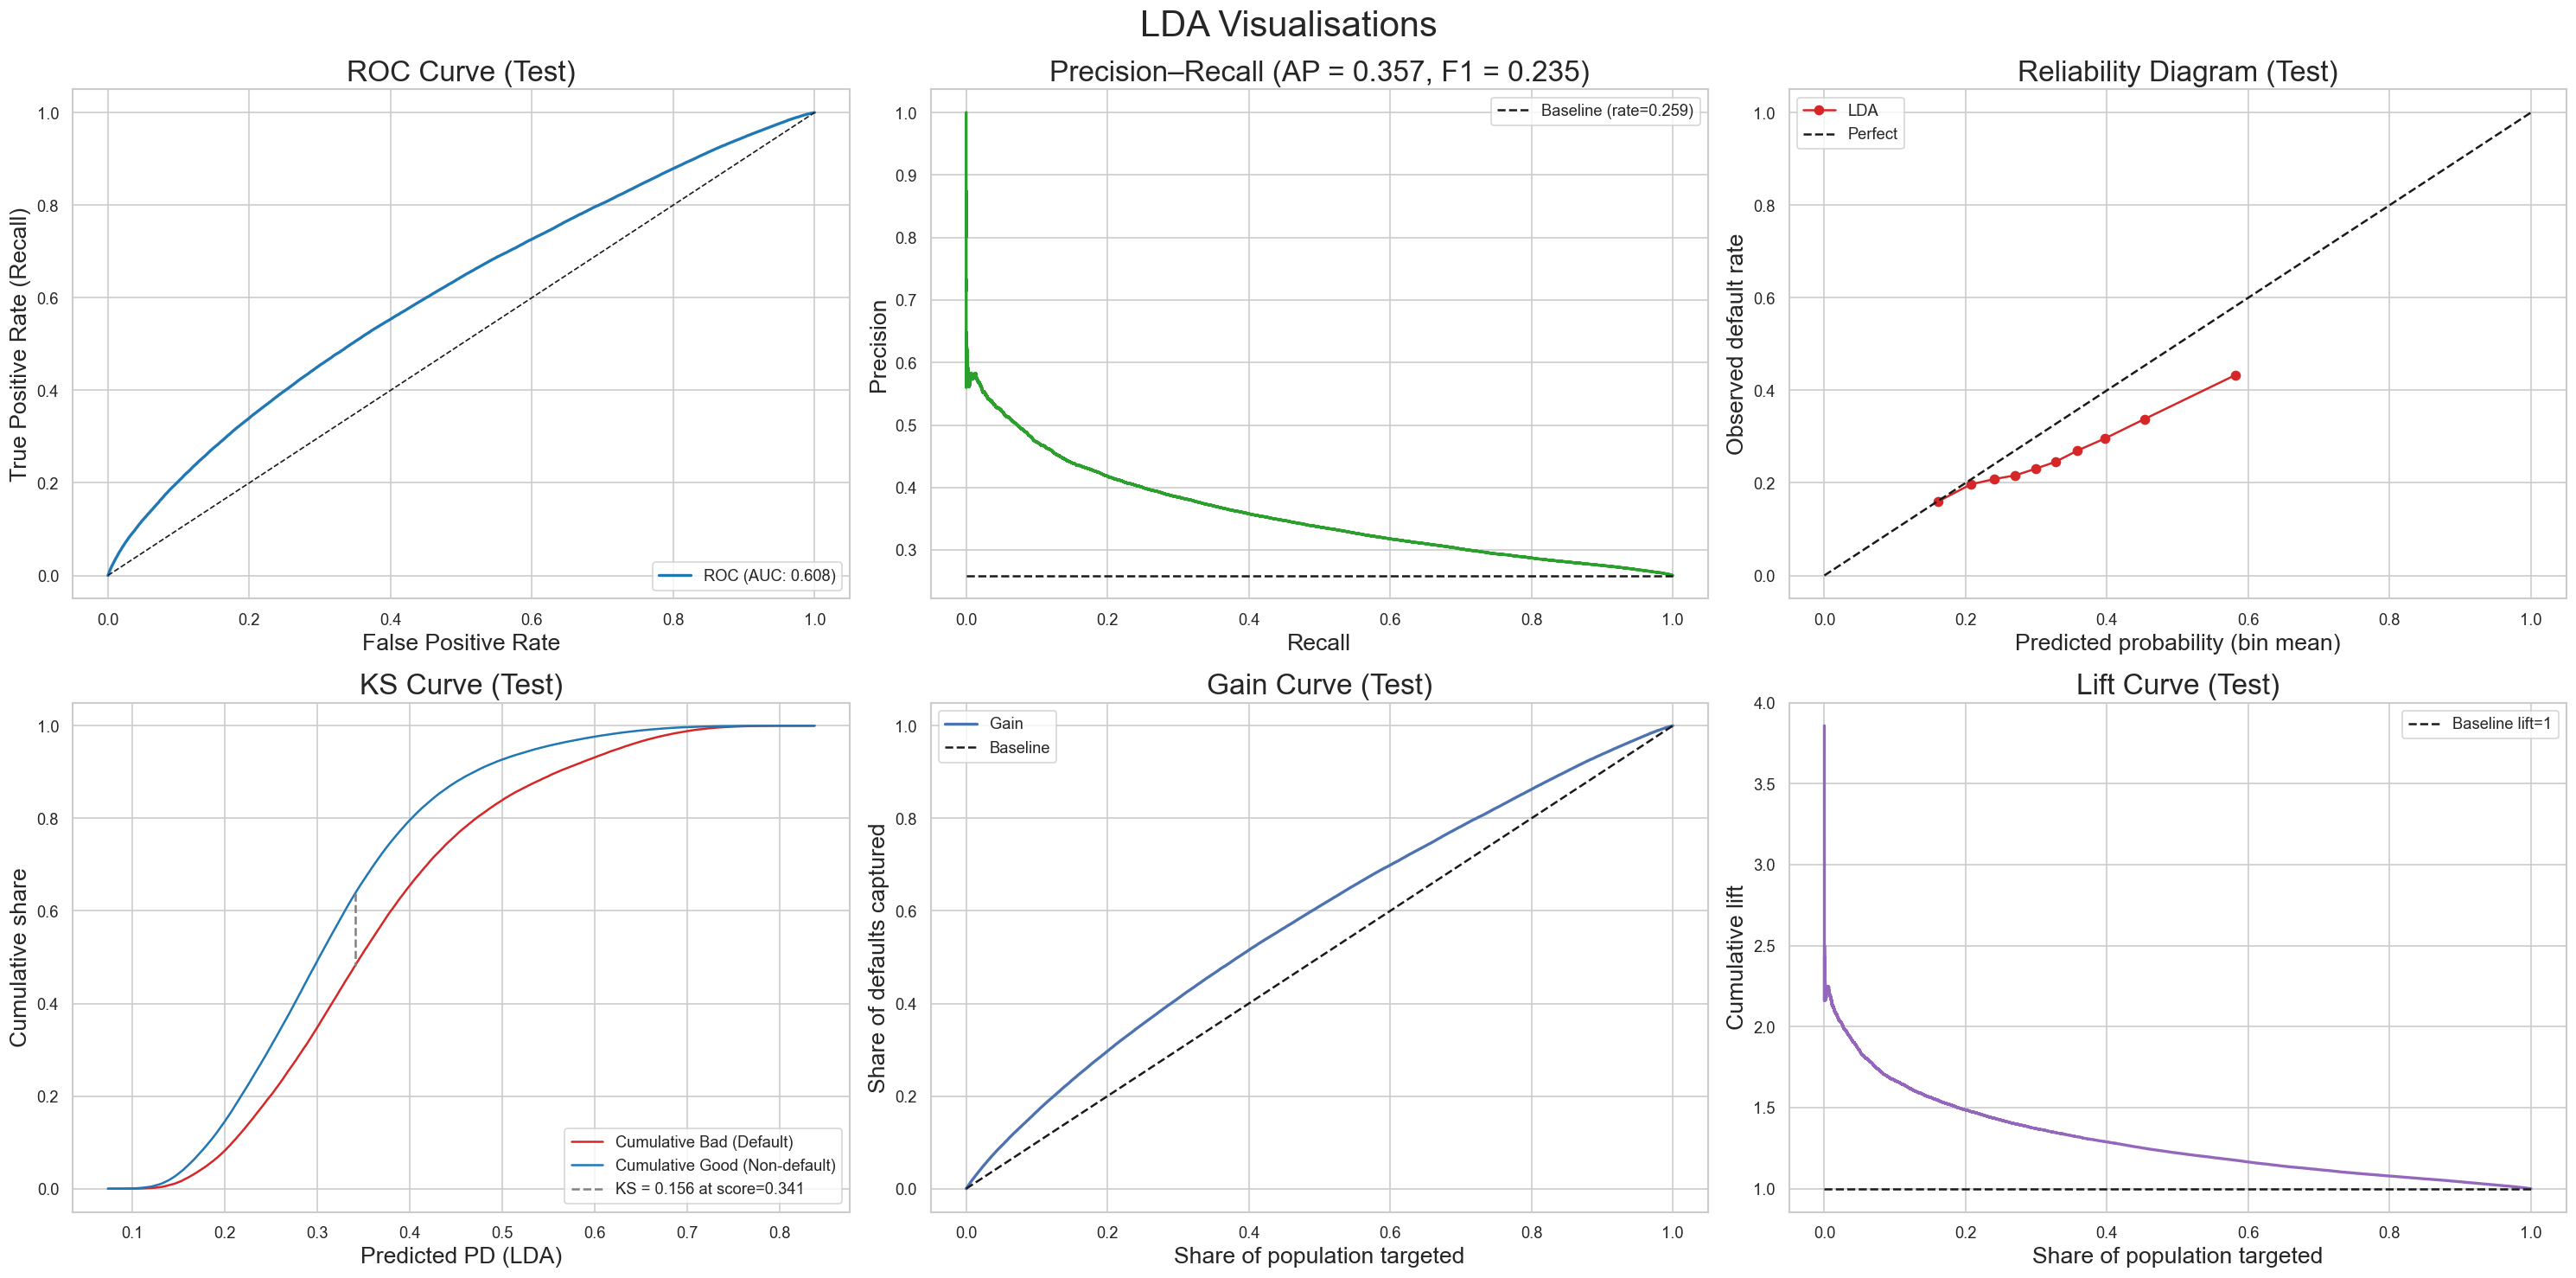

In [105]:
# Visualising the performance of the best LDA model
model_visualisation(pd_lda, "LDA")

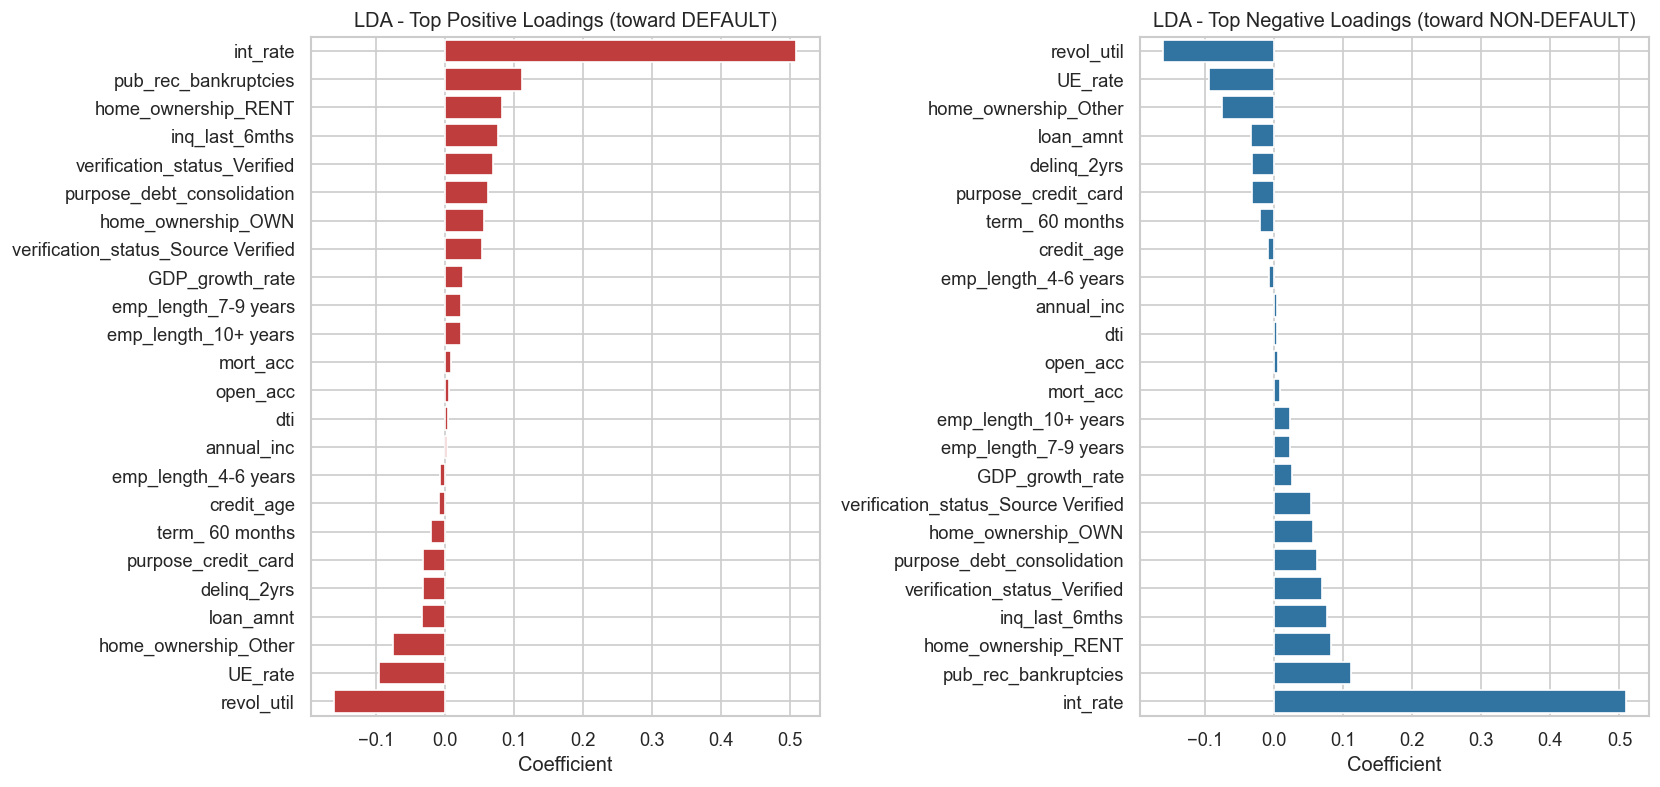

In [106]:
feature_loadings(best_lda, "LDA")

In [107]:
pd.DataFrame({"Metrics": metrics(y_test, pd_lda)}).T

AUC  Brier  LogLoss  Avg_PD  Avg_PD_Error  Avg_Prec  GINI  HL_Stat  \
Metrics 0.61   0.19     0.57    0.33          0.07      0.36  0.22 12933.25   

         HL_p  CalSlope  CalIntercept  Portfolio_Bad_Rate  \
Metrics  0.00      0.70         -0.55                0.26   

         Top_Decile_Bad_Rate  Lift  
Metrics                 0.43  1.67

**Overall Performance Summary**
   
The LDA model demonstrates modest predictive power for Probability of Default (PD) modelling. While it provides some ability to rank risk, its raw PD outputs are materially miscalibrated and nearly as poor as a constant predictor at the portfolio event rate when evaluated by Brier and LogLoss. This means the model is usable for ranking (e.g., segmentation, decline tiers) but not suitable for direct PD usage in pricing, limits, or regulatory capital without calibration.

Key Highlights:
- AUC: 0.609 (moderate discrimination)
- GINI: 0.217 (consistent with AUC)
- Avg PD: 0.331 vs event rate 0.259 → overprediction
- Calibration slope/intercept: 0.65 / -0.60 → strong miscalibration
- HL p-value: 0.000 → fails goodness-of-fit
- Top-decile lift: 1.65× → some concentration of risk


**Discrimination**

- AUC = 0.609, GINI = 0.217: Indicates modest ranking ability—better than random but far from strong. For consumer PD models, targets are typically AUC ≥ 0.65.
- Average Precision (AP) = 0.356: Above the base rate (0.259), showing some improvement in precision-recall space.

Interpretation: The model can separate higher-risk from lower-risk applicants, but improvements in feature engineering and model class are needed to achieve stronger discrimination.

**Calibration**

- Avg PD = 0.331 vs event rate = 0.259: Model overpredicts PD globally.
- Calibration slope = 0.649 (< 1): Predictions are too extreme—high PDs too high, low PDs too low.
- Calibration intercept = -0.599: Indicates a downward shift needed to align PDs.
- Hosmer–Lemeshow p-value = 0.000: Strong evidence of miscalibration across deciles.
- Brier = 0.194, LogLoss = 0.575: Slightly worse than a constant predictor at event rate (Brier ≈ 0.191, LogLoss ≈ 0.572).

Interpretation: Raw PDs are not reliable for pricing, limits, or IFRS/CECL forecasting. Post-hoc calibration (isotonic or Platt) is essential before using PDs operationally.

**Lift/Gain**

- Top-decile bad rate = 0.429 vs portfolio = 0.259 → Lift = 1.65×.
- The riskiest 10% are 65% more likely to default than average.
- The model concentrates risk in top deciles, enabling decline tiers or manual review prioritization. Stronger models often achieve lift ≥ 2.0× and capture ≥ 60% of bads in top 40%; this model captures ~51%, which is moderate.

Interpretation: Ranking power is usable for segmentation, but not optimal for aggressive risk-based strategies.

**Implications**

- Usable for ranking: Can support approval segmentation (e.g., accept safest 40%) and collections prioritization.
- Not suitable for raw PD usage: Miscalibration would lead to overpricing, excessive declines, and inflated capital if used directly.
- Governance risk: HL p=0 and slope/intercept far from targets will fail model risk validation without calibration.

## Probit

In [108]:
# Importing the probit model from stats
import statsmodels.api as sm

In [109]:
# Applying a constant to the train and test data
x_train_sm = sm.add_constant(pd.DataFrame(x_train))
x_test_sm = sm.add_constant(pd.DataFrame(x_test), has_constant = "add")

In [110]:
# Selecting the model and training it
probit_glm = sm.GLM(y_train, x_train_sm, family = sm.families.Binomial(sm.families.links.Probit()))
probit_res = probit_glm.fit_regularized(alpha = 0.1, L1_wt = 0.0)

C:\Users\arwin\.conda\envs\py312\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
C:\Users\arwin\.conda\envs\py312\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


Predicted probabilities reach exactly 0 or 1. Most likely this is due to perfect separation.

In [111]:
print((x_train_sm[y_train==1].max(axis=0) == 1).sum())  # Features always 1 when y=1
print((x_train_sm[y_train==0].max(axis=0) == 0).sum())

12
0


12 variables are perfectly separated

In [112]:
# Finding the variables that are perfectly separated
y1_mask = y_train == 1
perfect_separators = x_train_sm.columns[(x_train_sm.loc[y1_mask].max() == 1)].tolist()
print("Perfect separators:", perfect_separators)

Perfect separators: ['const', 'purpose_credit_card', 'purpose_debt_consolidation', 'term_ 60 months', 'verification_status_Source Verified', 'verification_status_Verified', 'emp_length_10+ years', 'emp_length_4-6 years', 'emp_length_7-9 years', 'home_ownership_OWN', 'home_ownership_Other', 'home_ownership_RENT']


These are the 12 variables that exactly predict the outcome

In [113]:
# Removing the perfectly separated variables
x_train_clean = x_train_sm.drop(columns=perfect_separators)
x_test_clean = x_test_sm.drop(columns=perfect_separators)

In [114]:
# re-selected and retraining the model
probit_glm = sm.GLM(
    y_train, 
    sm.add_constant(x_train_clean), 
    family=sm.families.Binomial(sm.families.links.Probit())
)

probit_glm = probit_glm.fit()

In [115]:
# Testing the model
pd_probit = np.asarray(probit_glm.predict(sm.add_constant(x_test_clean, has_constant = "add")))

In [116]:
# Creating metrics and composite score for Probit Model
probit_res = [{"Model" : "Probit", **metrics(y_test, pd_probit)}]
probit_df = composite_score(pd.DataFrame(probit_res))
probit_df

Model  AUC  GINI  Brier  LogLoss  Avg_PD  Avg_PD_Error  HL_Stat  HL_p  \
0  Probit 0.61  0.21   0.19     0.57    0.33          0.07 12872.68  0.00   

   CalSlope  CalIntercept  CompositeScore  
0      0.72         -0.55            0.34

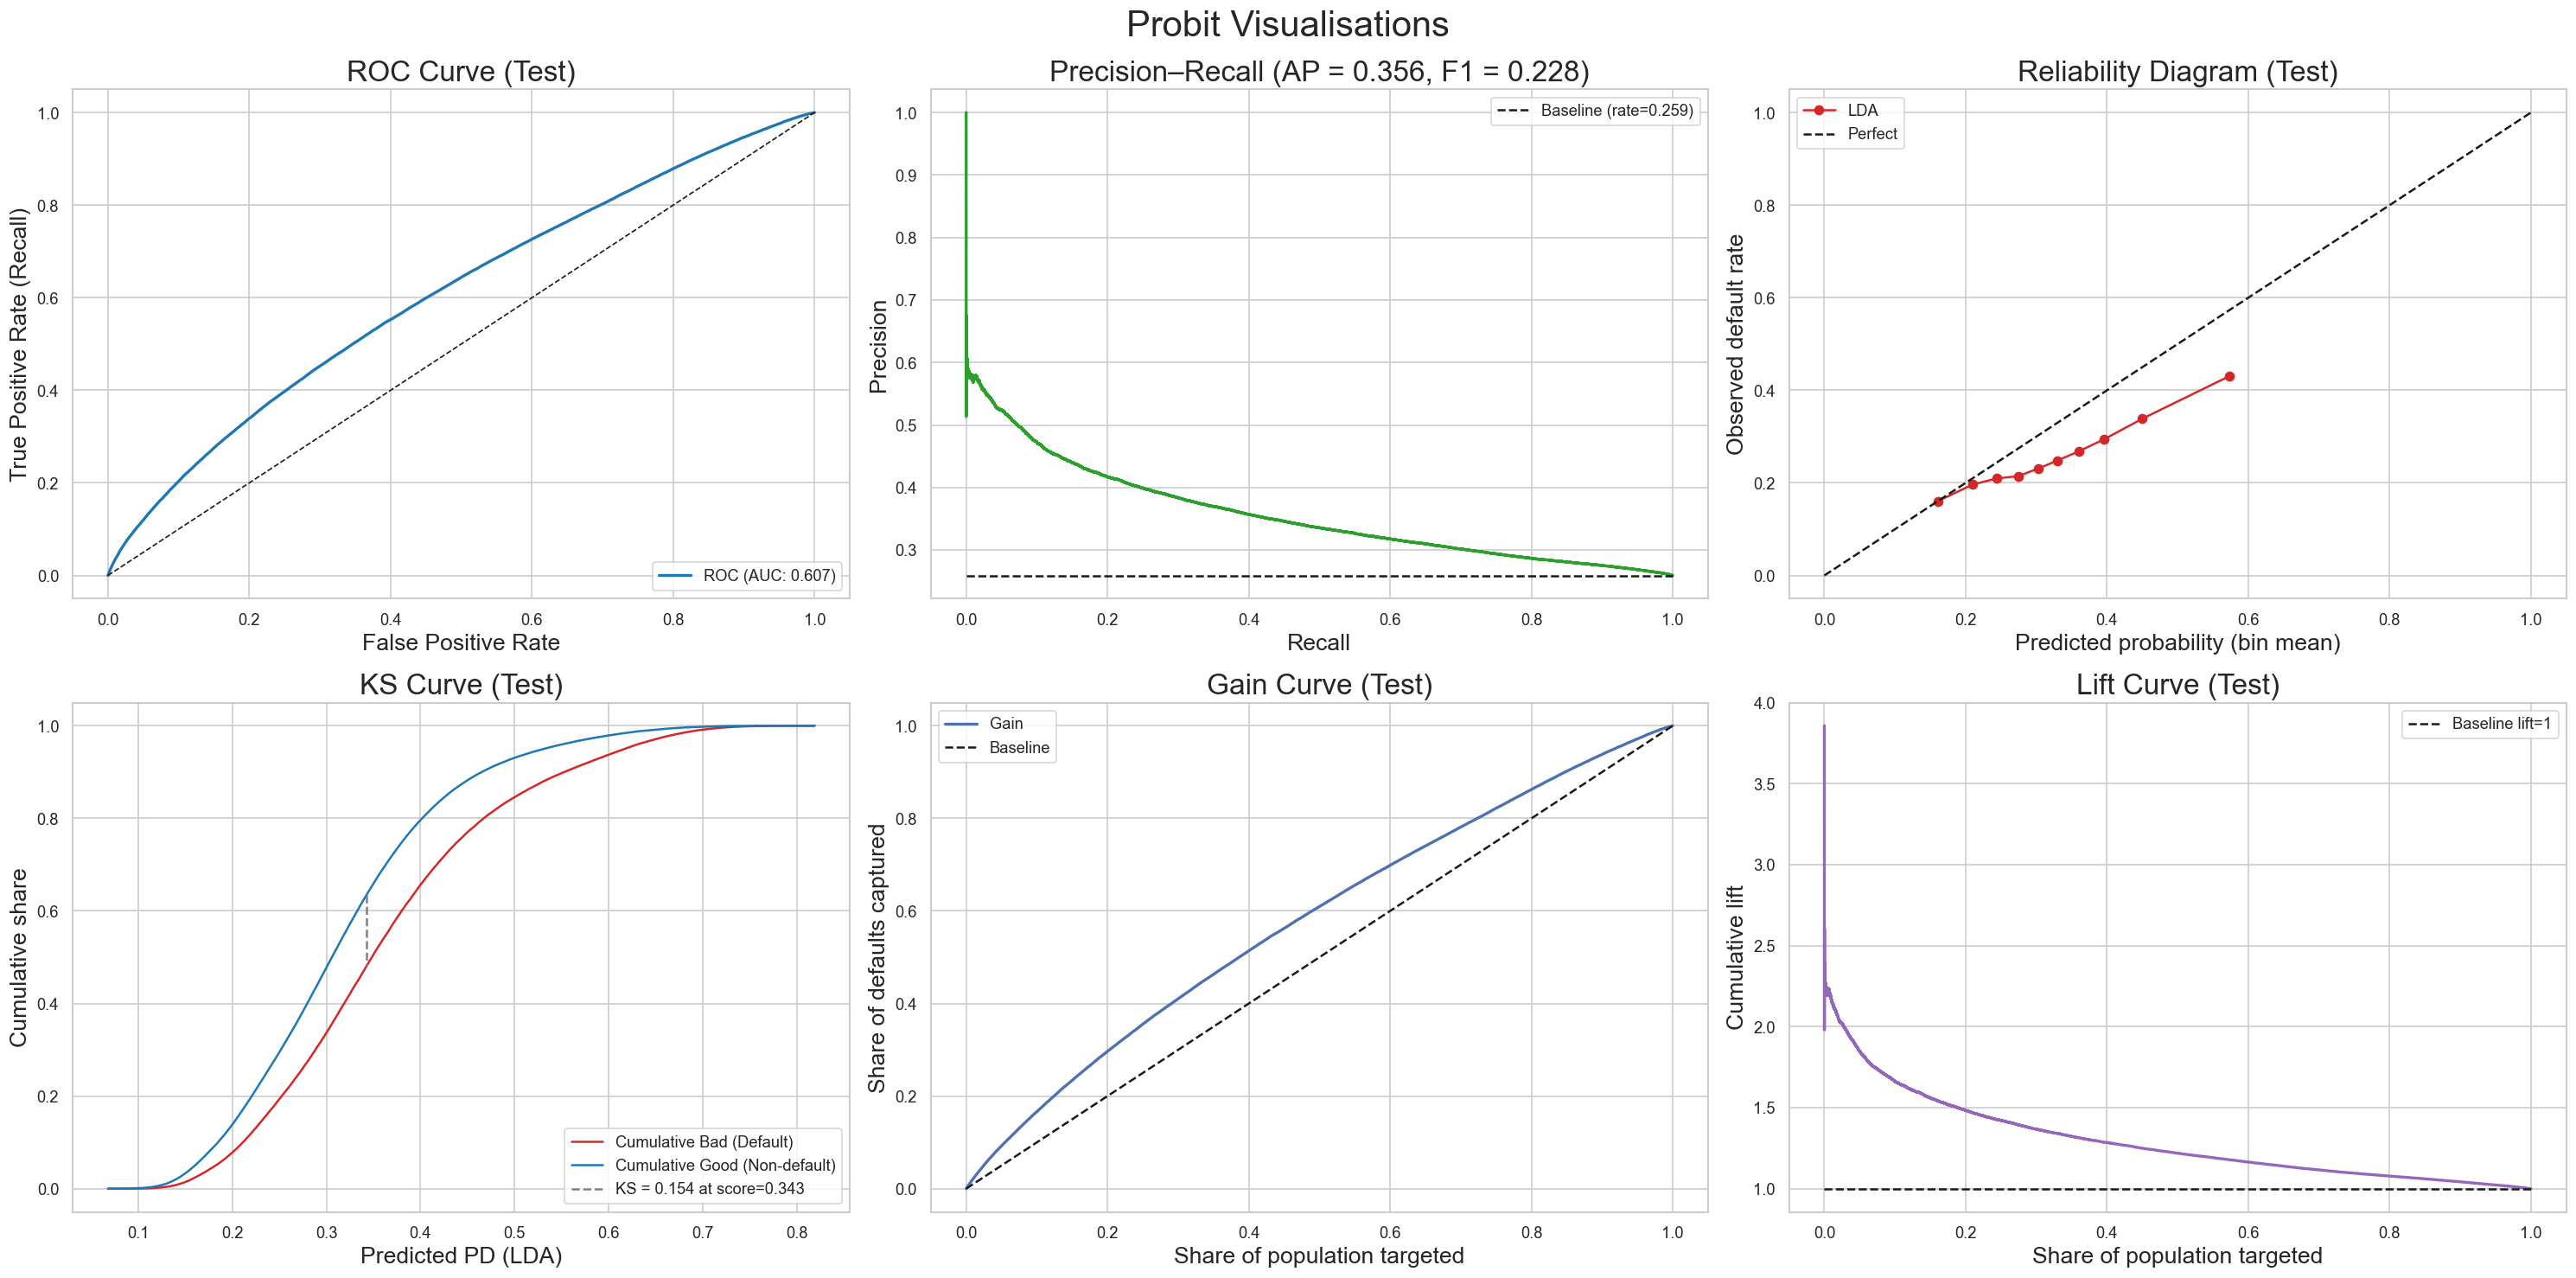

In [117]:
model_visualisation(pd_probit, "Probit")

In [118]:
pd.DataFrame({"Metrics": metrics(y_test, pd_probit)}).T

AUC  Brier  LogLoss  Avg_PD  Avg_PD_Error  Avg_Prec  GINI  HL_Stat  \
Metrics 0.61   0.19     0.57    0.33          0.07      0.36  0.21 12872.68   

         HL_p  CalSlope  CalIntercept  Portfolio_Bad_Rate  \
Metrics  0.00      0.72         -0.55                0.26   

         Top_Decile_Bad_Rate  Lift  
Metrics                 0.43  1.66

**Overall Performance Summary**
The Probit model demonstrates modest discrimination and significant miscalibration, similar to other linear models in this portfolio. While it ranks risk better than random, its raw PD outputs are not governance-ready for pricing, limits, or regulatory capital without calibration. The model’s Brier and LogLoss are only marginally better than a constant predictor at the event rate, signaling that while ranking is usable, probability fidelity is poor.

Key Highlights:
- AUC: 0.608 (moderate ranking power)
- GINI: 0.216 (consistent with AUC)
- Avg PD: 0.332 vs event rate 0.259 → overprediction
- Calibration slope/intercept: 0.68 / -0.58 → strong miscalibration
- Hosmer–Lemeshow p-value: 0.000 → fails goodness-of-fit
- Top-decile lift: 1.65× → some concentration of risk

**Discrimination**
- AUC = 0.608, GINI = 0.216: Indicates modest ranking ability—better than random but far from strong. For consumer PD models, targets are typically AUC ≥ 0.65.
- Average Precision (AP) = 0.356: Above the base rate (0.259), showing some improvement in precision-recall space.

Interpretation: The model can separate higher-risk from lower-risk applicants, but improvements in feature engineering and model class are needed to achieve stronger discrimination.

**Calibration**

- Avg PD = 0.332 vs event rate = 0.259: Model overpredicts PD globally.
- Calibration slope = 0.682 (< 1): Predictions are too extreme; high PDs too high, low PDs too low.
- Calibration intercept = -0.580: Indicates a downward shift needed to align PDs.
- Hosmer–Lemeshow p-value = 0.000: Strong evidence of miscalibration across deciles.
- Brier = 0.194, LogLoss = 0.574: Only marginally better than a constant predictor at event rate (Brier ≈ 0.191, LogLoss ≈ 0.572).

Interpretation: Raw PDs are not reliable for pricing, limits, or IFRS/CECL forecasting. Post-hoc calibration (isotonic or Platt) is essential before using PDs operationally.

**Lift/Gain**

Top-decile bad rate = 0.429 vs portfolio = 0.259 → Lift = 1.65×.

The riskiest 10% are 65% more likely to default than average.

Implication: The model concentrates risk in top deciles, enabling decline tiers or manual review prioritization.
Stronger models often achieve lift ≥ 2.0× and capture ≥ 60% of bads in top 40%; this only model captures ~51%, which is moderate.

Interpretation: Ranking power is usable for segmentation, but not optimal for aggressive risk-based strategies.

**Implications**

- Usable for ranking: Can support approval segmentation (e.g., accept safest 40%) and collections prioritization.
- Not suitable for raw PD usage: Miscalibration would lead to overpricing, excessive declines, and inflated capital if used directly.
- Governance risk: HL p=0 and slope/intercept far from targets will fail model risk validation without calibration.

## Logistic Regression (Regularized)

Including hyperparameter tuning using the validation dataset

In [119]:
# Creating hyperparameter mapping for logistic regression
logit_penalties = ["l2", "l1"]
logit_Cs = [2.0, 1.0, 0.5, 0.25, 0.1]
logit_res = []

In [120]:
# Training and testing models using validation dataset to find optimal selection of hyperparameters
for pen in logit_penalties:
    solver = "lbfgs" if pen == "l2" else "saga"
    for C in logit_Cs:
        logit = LogisticRegression(
            penalty = pen,
            C = C,
            solver = solver,
            max_iter = 1000,
            class_weight = "balanced", # Class_weight must be balanced due to imbalance in target feature
            n_jobs = None,
            random_state = 50
        )
        logit.fit(x_train, y_train)
        logit_val = logit.predict_proba(x_valid)[:, 1]
        logit_res.append({"Model" : logit, **metrics(y_valid, logit_val)})

In [121]:
# Applying composite score
logit_df = composite_score(pd.DataFrame(logit_res))
logit_df

Model  AUC  GINI  Brier  \
0  LogisticRegression(C=2.0, class_weight='balanc... 0.64  0.28   0.24   
1  LogisticRegression(class_weight='balanced', ma... 0.64  0.28   0.24   
2  LogisticRegression(C=0.5, class_weight='balanc... 0.64  0.28   0.24   
3  LogisticRegression(C=0.25, class_weight='balan... 0.64  0.28   0.24   
4  LogisticRegression(C=2.0, class_weight='balanc... 0.64  0.28   0.24   
5  LogisticRegression(C=0.1, class_weight='balanc... 0.64  0.28   0.24   
6  LogisticRegression(C=0.5, class_weight='balanc... 0.64  0.28   0.24   
7  LogisticRegression(C=0.1, class_weight='balanc... 0.64  0.28   0.24   
8  LogisticRegression(class_weight='balanced', ma... 0.64  0.28   0.24   
9  LogisticRegression(C=0.25, class_weight='balan... 0.64  0.28   0.24   

   LogLoss  Avg_PD  Avg_PD_Error  HL_Stat  HL_p  CalSlope  CalIntercept  \
0     0.67    0.50          0.19 68878.54  0.00      0.89         -0.85   
1     0.67    0.50          0.19 68872.52  0.00      0.89         -0.85   
2     0.67    0.50          0.19 68859.98  0.00      0.89         -0.85   
3     0.67    0.50          0.19 68844.58  0.00      0.89         -0.85   
4     0.67    0.50          0.19 69096.13  0.00      0.89         -0.85   
5     0.67    0.50          0.19 68839.96  0.00      0.89         -0.85   
6     0.67    0.50          0.19 69055.96  0.00      0.89         -0.85   
7     0.67    0.50          0.19 69074.80  0.00      0.89         -0.85   
8     0.67    0.50          0.19 69008.53  0.00      0.89         -0.85   
9     0.67    0.50          0.19 69136.37  0.00      0.89         -0.85   

   CompositeScore  
0            0.55  
1            0.55  
2            0.55  
3            0.54  
4            0.52  
5            0.47  
6            0.38  
7            0.37  
8            0.20  
9            0.14

In [122]:
# Finding best logit model
best_logit = logit_df.iloc[0,0]
print(best_logit)

LogisticRegression(C=2.0, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=50, solver='saga')


In [123]:
# Testing best logit model on test data
pd_logit = best_logit.predict_proba(x_test)[:, 1]

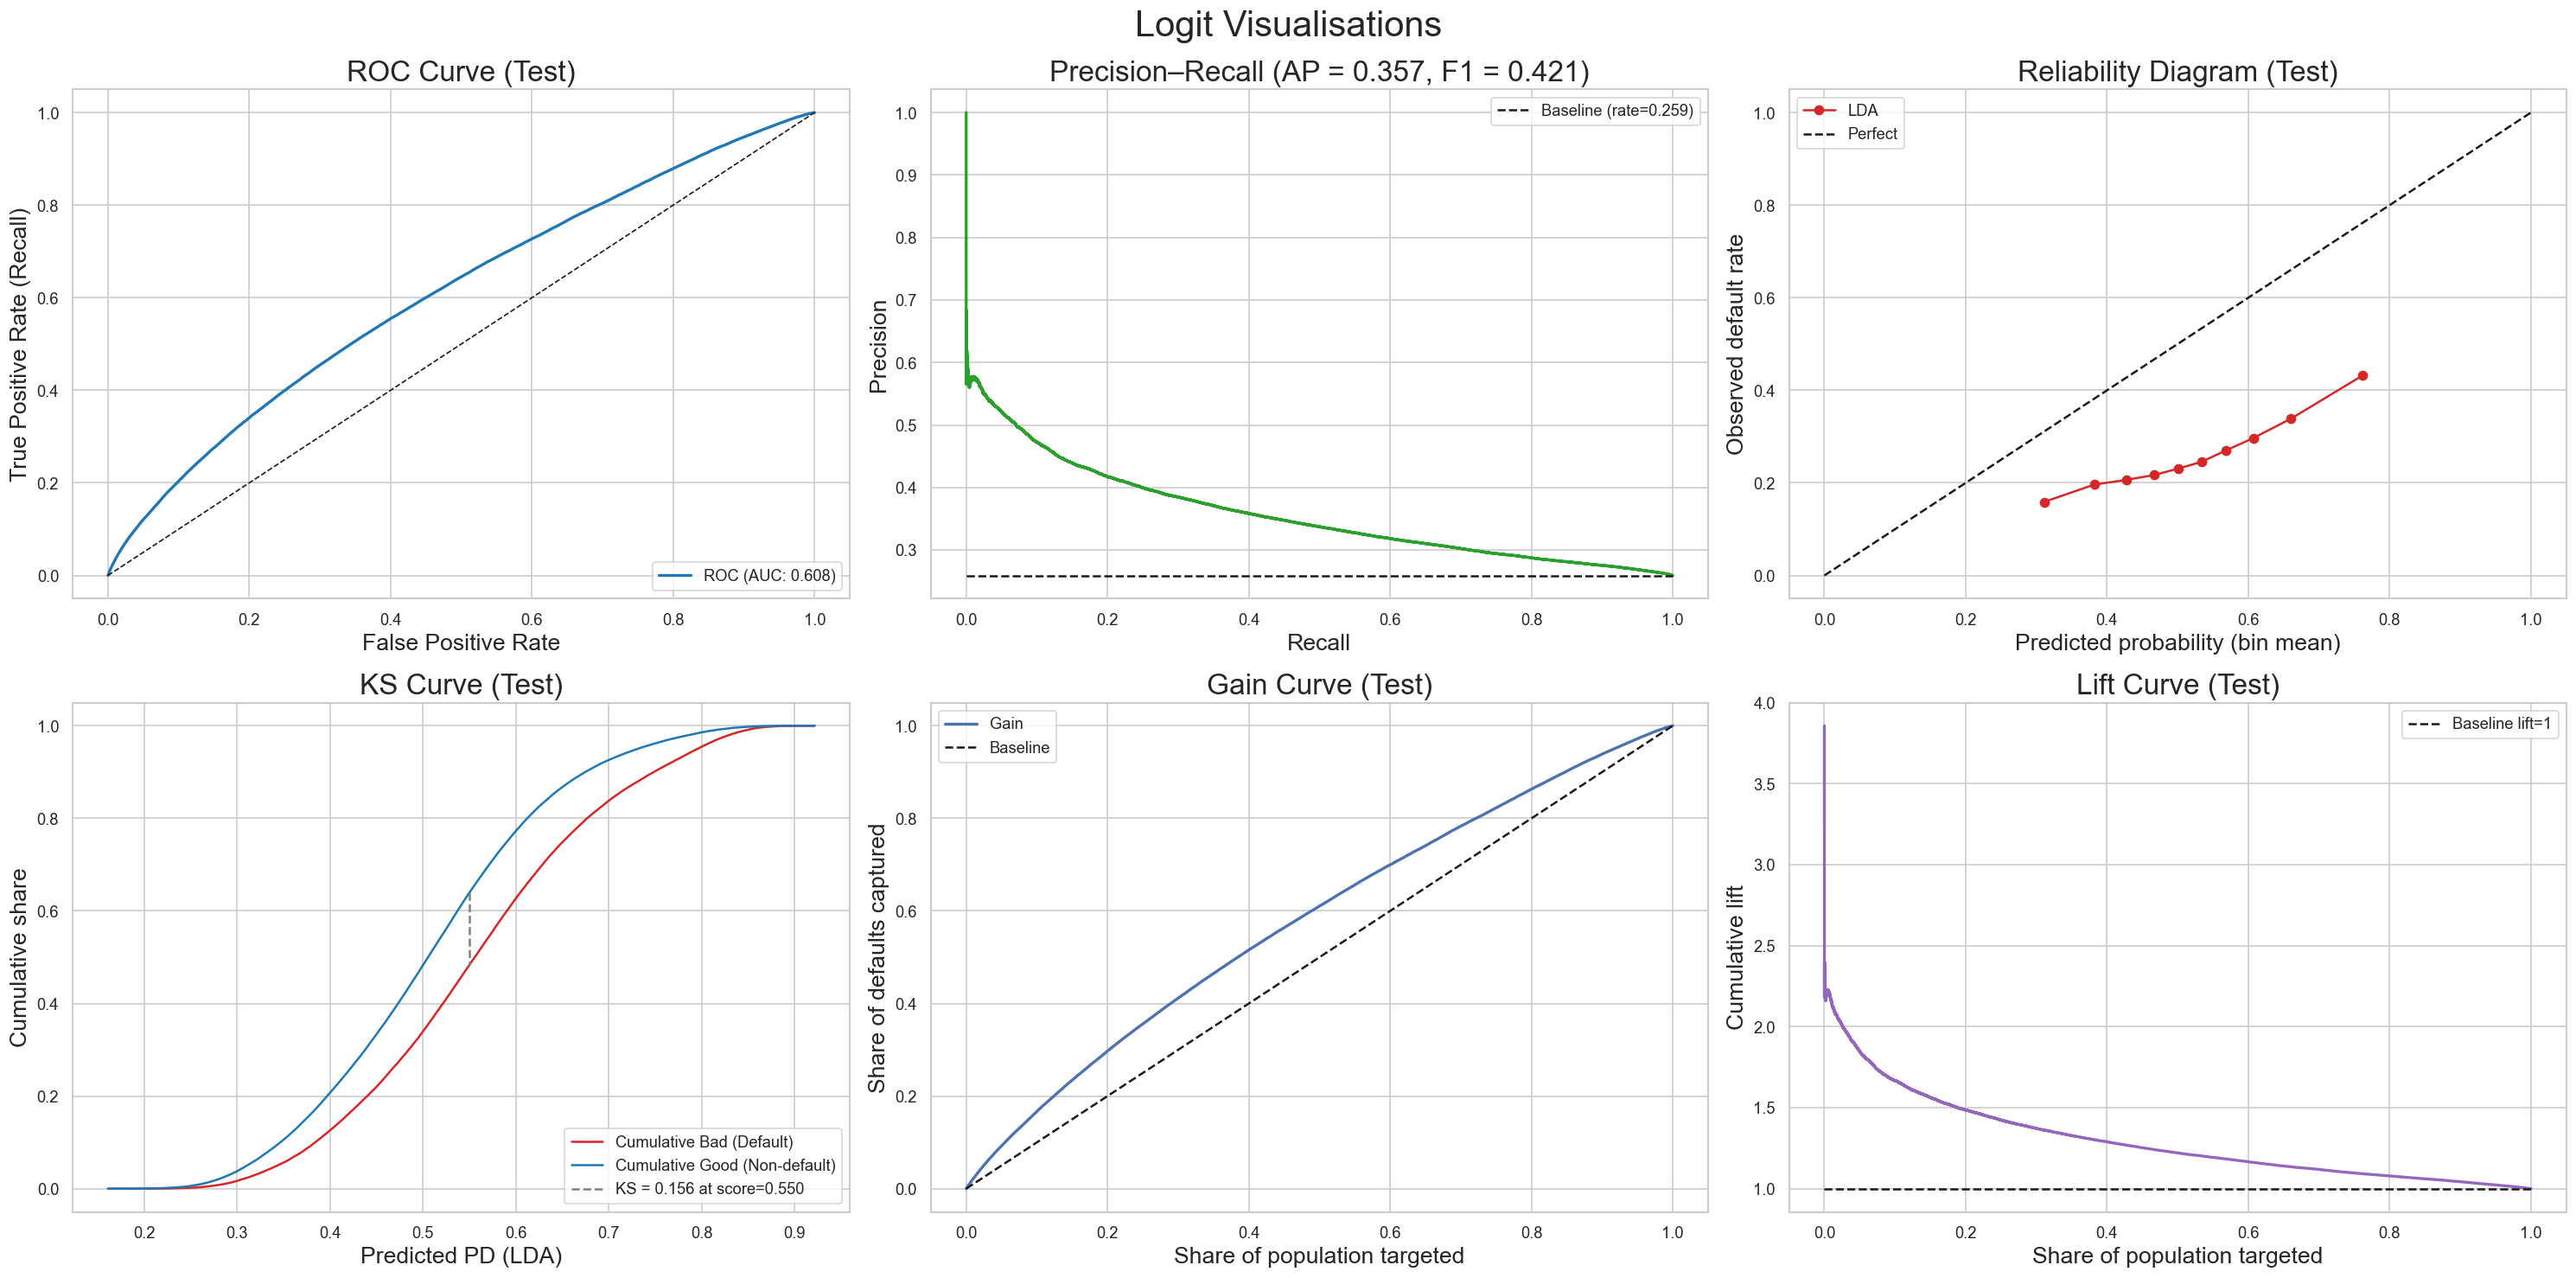

In [124]:
# Visualisations for best logit model
model_visualisation(pd_logit, "Logit")

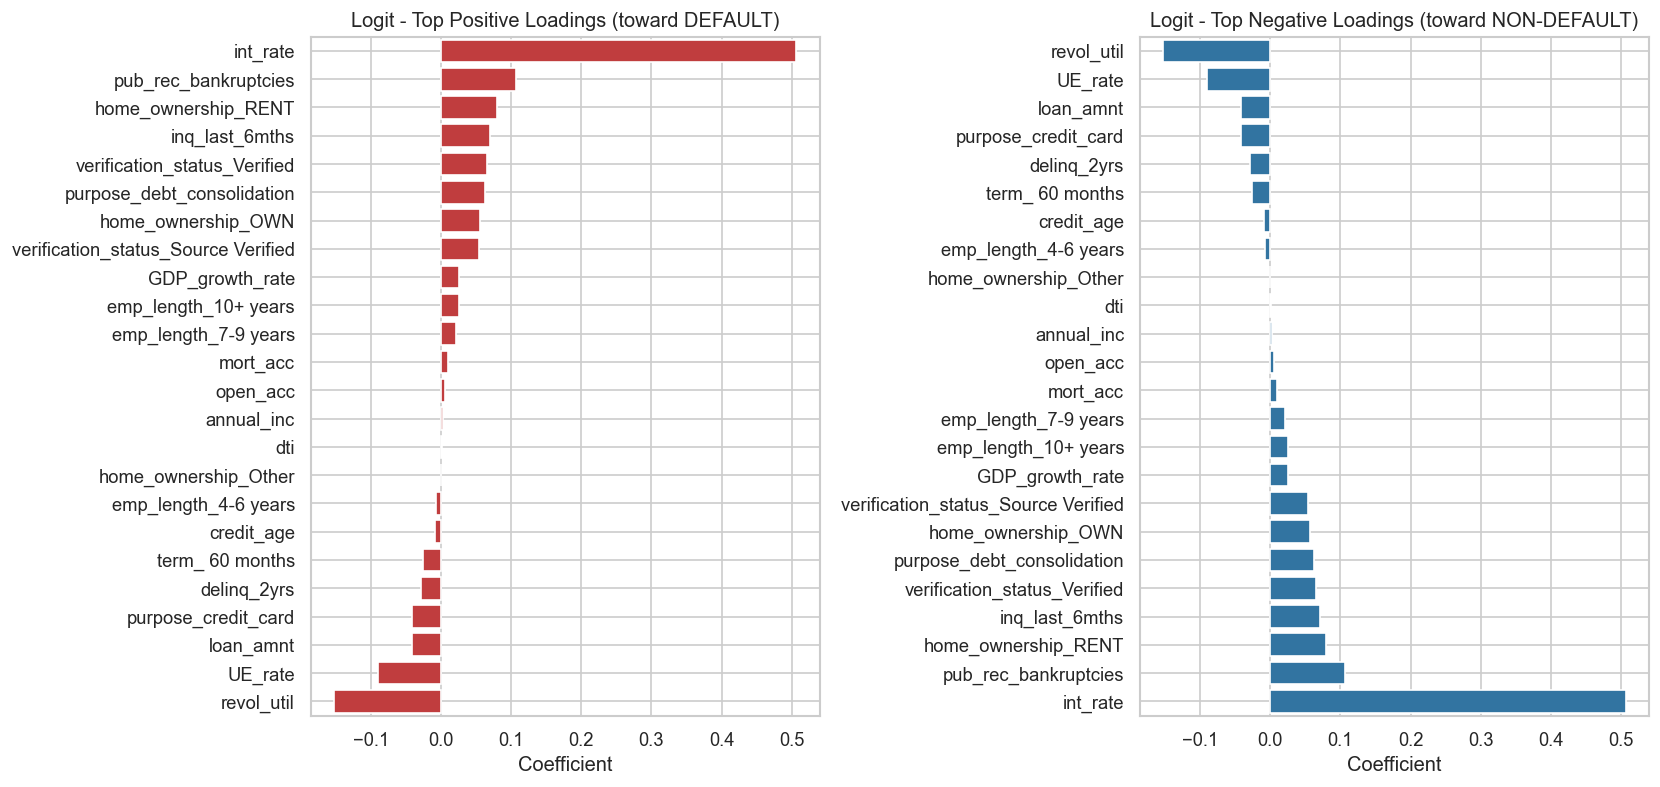

In [125]:
# Feature loadings for logit model
feature_loadings(logit, "Logit")

In [126]:
pd.DataFrame({"Metrics": metrics(y_test, pd_logit)}).T

AUC  Brier  LogLoss  Avg_PD  Avg_PD_Error  Avg_Prec  GINI   HL_Stat  \
Metrics 0.61   0.26     0.71    0.52          0.26      0.36  0.22 138578.48   

         HL_p  CalSlope  CalIntercept  Portfolio_Bad_Rate  \
Metrics  0.00      0.71         -1.16                0.26   

         Top_Decile_Bad_Rate  Lift  
Metrics                 0.43  1.67

**Overall Performance Summary**

The Logit model exhibits similar discrimination to Probit but suffers from severe miscalibration, with an average predicted PD of 0.524 vs actual event rate of 0.259—an overshoot of more than 26 percentage points. This miscalibration is reflected in the calibration slope (0.67) and intercept (-1.16), as well as an extremely poor Hosmer–Lemeshow p-value (0.000). While the model ranks risk moderately well, its raw PDs are not suitable for governance or operational use without calibration. Furthermore, Brier (0.259) and LogLoss (0.716) are worse than a constant predictor at the event rate, signaling that the model’s probability estimates are highly unreliable.

Key Highlights:
- AUC: 0.609 (moderate ranking power)
- GINI: 0.218 (consistent with AUC)
- Avg PD: 0.524 vs event rate 0.259 → extreme overprediction
- Calibration slope/intercept: 0.67 / -1.16 → strong miscalibration
- Hosmer–Lemeshow p-value: 0.000 → fails goodness-of-fit
- Top-decile lift: 1.65× → some concentration of risk


**Discrimination**

- AUC = 0.609, GINI = 0.218: Indicates modest ranking ability—better than random but far from strong.
- Average Precision (AP) = 0.356: Above the base rate (0.259), showing some improvement in precision-recall space.

Interpretation: The model can separate higher-risk from lower-risk applicants, but improvements in feature engineering and model class are needed to achieve stronger discrimination.

**Calibration**

- Avg PD = 0.524 vs event rate = 0.259: Model grossly overpredicts PD globally.
- Calibration slope = 0.670 (< 1): Predictions are too extreme; high PDs too high, low PDs too low.
- Calibration intercept = -1.160: Indicates a large downward shift needed to align PDs.
- Hosmer–Lemeshow p-value = 0.000: Strong evidence of miscalibration across deciles.
- Brier = 0.259, LogLoss = 0.716: Both worse than a constant predictor at event rate (Brier ≈ 0.191, LogLoss ≈ 0.572).

Interpretation: Raw PDs are not reliable for pricing, limits, or IFRS/CECL forecasting. Post-hoc calibration (isotonic or Platt) is essential before using PDs operationally.

**Lift/Gain**

- Top-decile bad rate = 0.429 vs portfolio = 0.259 → Lift = 1.65×.
- The riskiest 10% are 65% more likely to default than average.
- Implication: The model concentrates risk in top deciles, enabling decline tiers or manual review prioritization.
- Stronger models often achieve lift ≥ 2.0× and capture ≥ 60% of bads in top 40%; this model captures ~51%, which is moderate.

Interpretation: Ranking power is usable for segmentation, but not optimal for aggressive risk-based strategies.

**Implications**

Usable for ranking: Can support approval segmentation (e.g., accept safest 40%) and collections prioritization.
Not suitable for raw PD usage: Miscalibration would lead to overpricing, excessive declines, and inflated capital if used directly.
Governance risk: HL p=0 and slope/intercept far from targets will fail model risk validation without calibration.

## Decision Trees

In [127]:
# Decision tree hyperparameter mapping
dt_max_depth = [4, 6, 8, None]
dt_min_samples_leaf = [25, 50, 100, 150]
dt_res = []

In [128]:
# Training and testing models using validation dataset to find optimal selection of hyperparameters
for md in dt_max_depth:
    for msl in dt_min_samples_leaf:
        dt = DecisionTreeClassifier(
            max_depth = md,
            min_samples_leaf = msl,
            class_weight = "balanced", # Must be balanced due to imbalanced target feature
            random_state = 50
        )
        dt.fit(x_train, y_train)
        dt_val = dt.predict_proba(x_valid)[:, 1]
        dt_res.append({"Model" : dt, **metrics(y_valid, dt_val)})

In [129]:
# Applying composite score
dt_df = composite_score(pd.DataFrame(dt_res))
dt_df

Model  AUC  GINI  Brier  \
0   DecisionTreeClassifier(class_weight='balanced'... 0.63  0.26   0.24   
1   DecisionTreeClassifier(class_weight='balanced'... 0.63  0.26   0.24   
2   DecisionTreeClassifier(class_weight='balanced'... 0.63  0.26   0.24   
3   DecisionTreeClassifier(class_weight='balanced'... 0.63  0.26   0.24   
4   DecisionTreeClassifier(class_weight='balanced'... 0.63  0.26   0.24   
5   DecisionTreeClassifier(class_weight='balanced'... 0.63  0.26   0.24   
6   DecisionTreeClassifier(class_weight='balanced'... 0.63  0.26   0.24   
7   DecisionTreeClassifier(class_weight='balanced'... 0.63  0.26   0.24   
8   DecisionTreeClassifier(class_weight='balanced'... 0.62  0.25   0.23   
9   DecisionTreeClassifier(class_weight='balanced'... 0.62  0.25   0.23   
10  DecisionTreeClassifier(class_weight='balanced'... 0.62  0.25   0.23   
11  DecisionTreeClassifier(class_weight='balanced'... 0.62  0.24   0.23   
12  DecisionTreeClassifier(class_weight='balanced'... 0.62  0.23   0.24   
13  DecisionTreeClassifier(class_weight='balanced'... 0.61  0.21   0.24   
14  DecisionTreeClassifier(class_weight='balanced'... 0.59  0.19   0.25   
15  DecisionTreeClassifier(class_weight='balanced'... 0.57  0.15   0.26   

    LogLoss  Avg_PD  Avg_PD_Error   HL_Stat  HL_p  CalSlope  CalIntercept  \
0      0.67    0.49          0.18  62288.21  0.00      0.78         -0.80   
1      0.67    0.49          0.18  62288.21  0.00      0.78         -0.80   
2      0.67    0.49          0.18  62288.21  0.00      0.78         -0.80   
3      0.67    0.49          0.18  62288.21  0.00      0.78         -0.80   
4      0.67    0.49          0.18  65498.61  0.00      0.86         -0.82   
5      0.67    0.49          0.18  65498.61  0.00      0.86         -0.82   
6      0.67    0.49          0.18  65498.61  0.00      0.86         -0.82   
7      0.67    0.49          0.18  65498.61  0.00      0.86         -0.82   
8      0.66    0.47          0.16  57073.17  0.00      0.70         -0.76   
9      0.66    0.47          0.17  57550.32  0.00      0.71         -0.77   
10     0.66    0.47          0.17  57591.37  0.00      0.71         -0.77   
11     0.66    0.47          0.16  55566.98  0.00      0.65         -0.75   
12     0.67    0.47          0.16  65083.55  0.00      0.55         -0.77   
13     0.68    0.46          0.16  70114.91  0.00      0.46         -0.76   
14     0.75    0.45          0.14  91816.69  0.00      0.14         -0.76   
15     1.36    0.43          0.12 288517.11  0.00      0.02         -0.76   

    CompositeScore  
0             0.70  
1             0.70  
2             0.70  
3             0.70  
4             0.67  
5             0.67  
6             0.67  
7             0.67  
8             0.65  
9             0.65  
10            0.65  
11            0.60  
12            0.54  
13            0.46  
14            0.33  
15            0.05

In [130]:
# Finding the best decision tree model
best_dt = dt_df.iloc[0,0]
print(best_dt)

DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_leaf=150, random_state=50)


In [131]:
# Applying the best decision tree model to test data
pd_dt = best_dt.predict_proba(x_test)[:, 1]

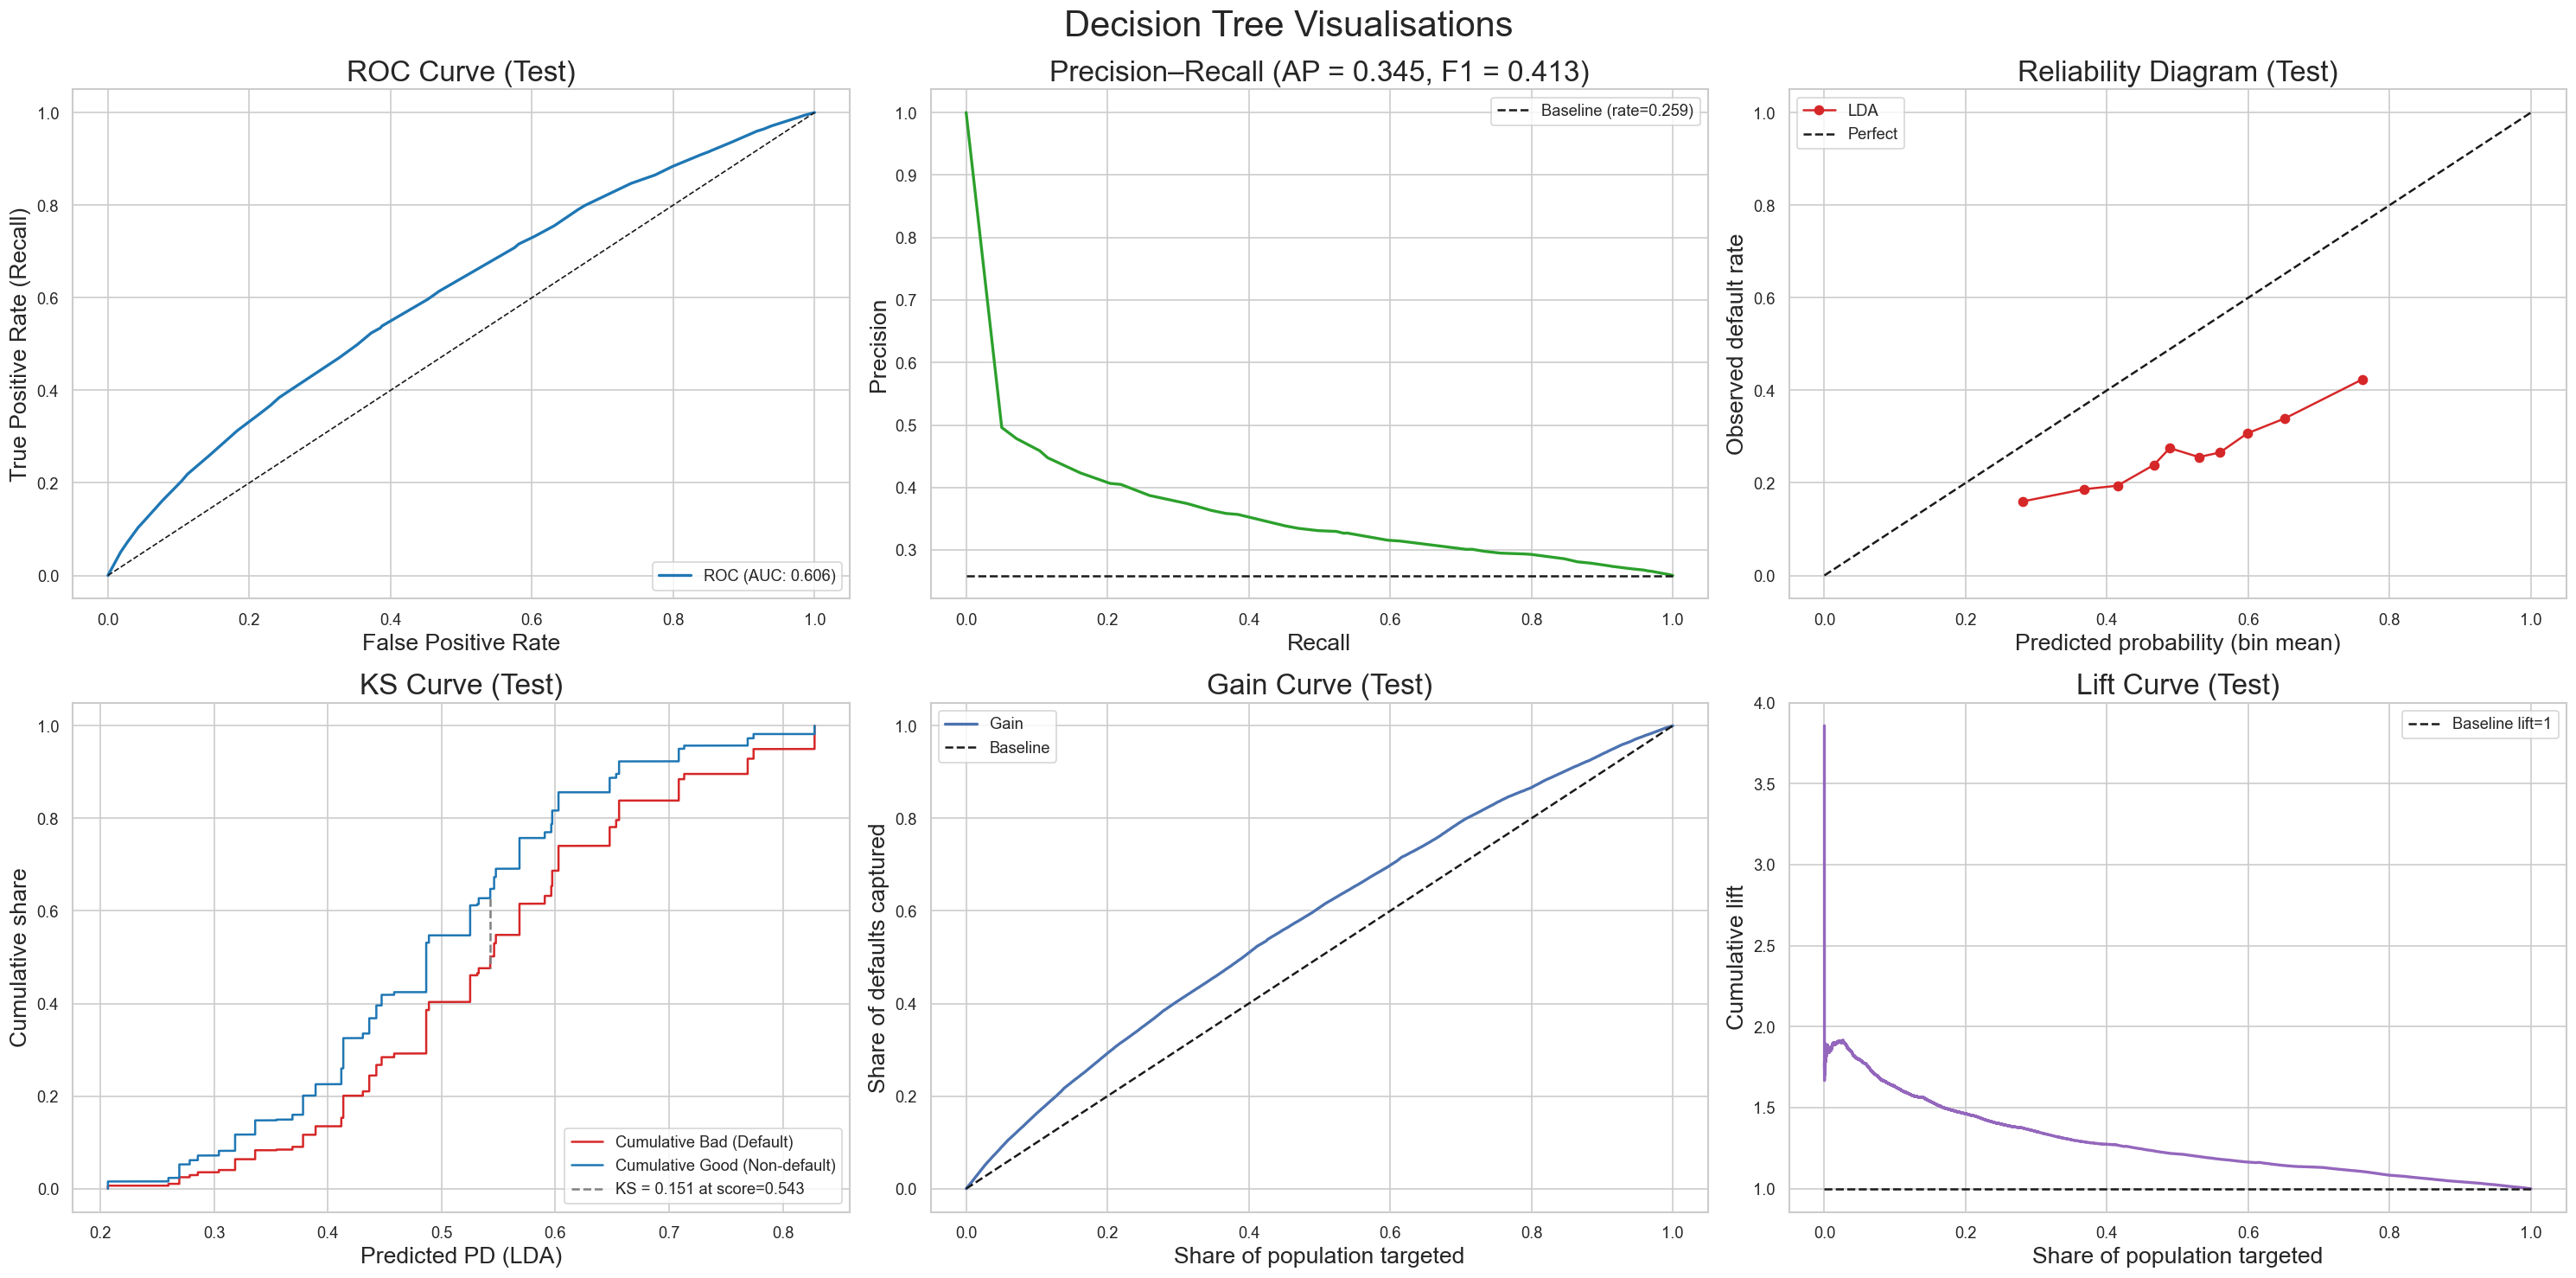

In [132]:
# Visualising the performance of the best decision tree model
model_visualisation(pd_dt, "Decision Tree")

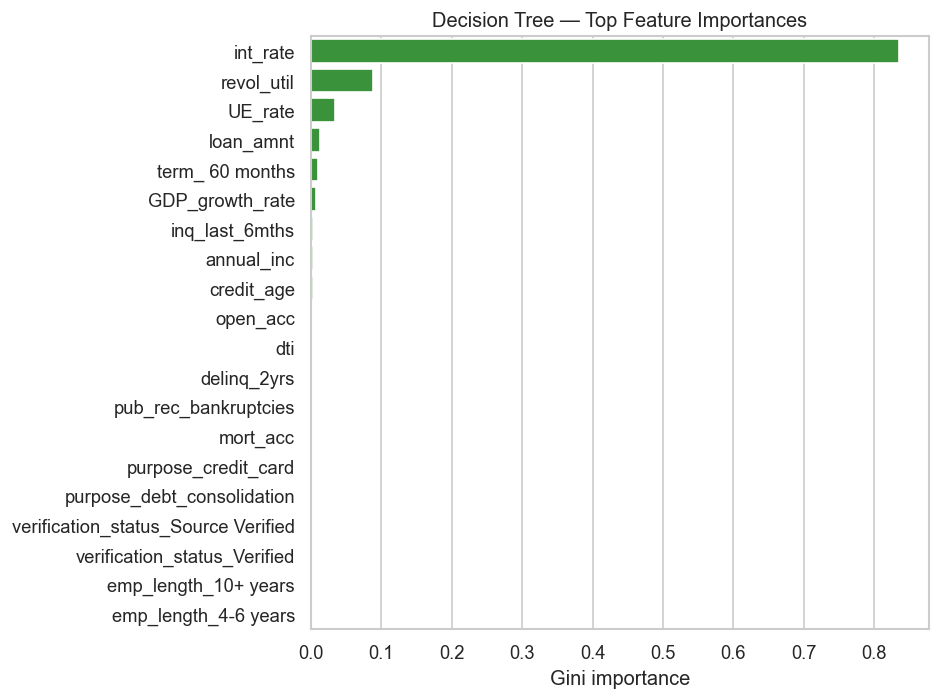

In [133]:
# Finding the most important features from the model
feature_names = x_train.columns.to_list()
imp = best_dt.feature_importances_
df_imp = pd.DataFrame({"feature": feature_names, "importance": imp})
df_imp = df_imp.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(data=df_imp, y="feature", x="importance", color="#2ca02c")
plt.title("Decision Tree — Top Feature Importances")
plt.xlabel("Gini importance")
plt.ylabel("")
plt.tight_layout(); plt.show()

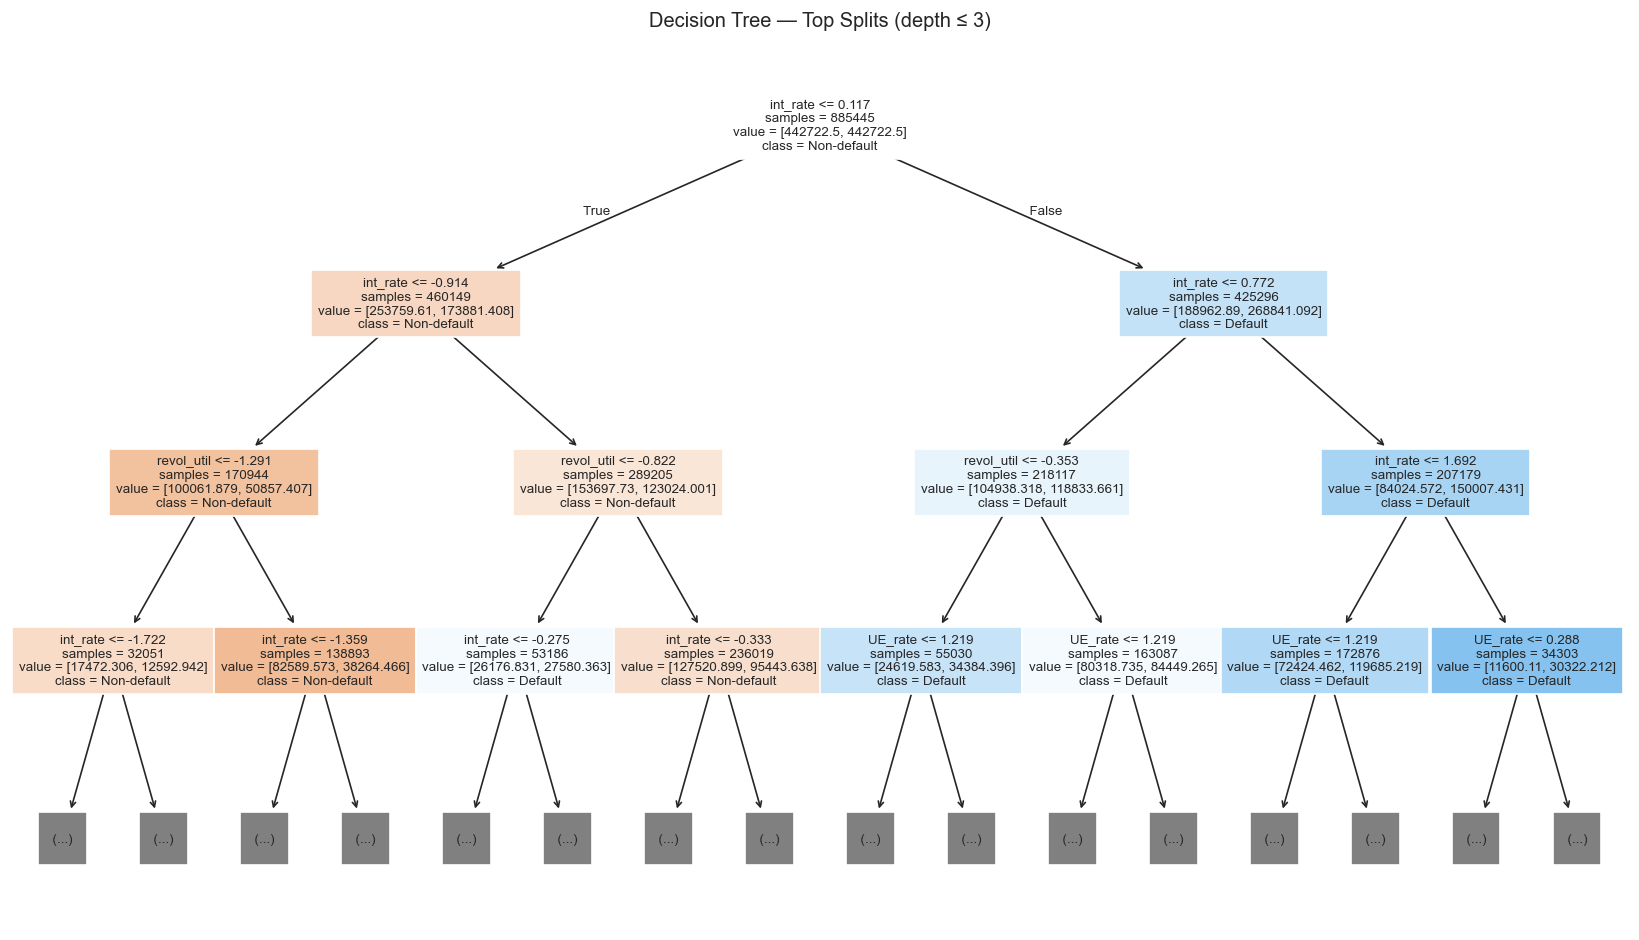

In [134]:
# Visualising the first 3 layers of the decision tree model
from sklearn import tree

plt.figure(figsize=(14, 8))
tree.plot_tree(best_dt,
               feature_names=feature_names,
               class_names=["Non-default","Default"],
               filled=True, impurity=False, max_depth=3, fontsize=8)
plt.title("Decision Tree — Top Splits (depth ≤ 3)")
plt.tight_layout()
plt.show()

In [135]:
pd.DataFrame({"Metrics": metrics(y_test, pd_dt)}).T

AUC  Brier  LogLoss  Avg_PD  Avg_PD_Error  Avg_Prec  GINI   HL_Stat  \
Metrics 0.61   0.25     0.70    0.51          0.25      0.35  0.21 125193.63   

         HL_p  CalSlope  CalIntercept  Portfolio_Bad_Rate  \
Metrics  0.00      0.66         -1.11                0.26   

         Top_Decile_Bad_Rate  Lift  
Metrics                 0.42  1.63

**Overall Performance Summary**

The Decision Tree model provides similar discrimination to other linear models but suffers from severe miscalibration, with an average predicted PD of 0.506 vs actual event rate of 0.259—an overshoot of nearly 25 percentage points. Calibration slope and intercept (0.66 / -1.11) confirm that predicted probabilities are far from reliable. The Hosmer–Lemeshow p-value (0.000) indicates poor calibration across risk buckets. While the model ranks risk moderately well, its raw PDs are not suitable for governance or operational use without calibration. Brier (0.251) and LogLoss (0.699) are worse than a constant predictor at the event rate, signaling that the model’s probability estimates are highly unreliable.

Key Highlights:
- AUC: 0.606 (modest ranking power)
- GINI: 0.213 (consistent with AUC)
- Avg PD: 0.506 vs event rate 0.259 → extreme overprediction
- Calibration slope/intercept: 0.66 / -1.11 → strong miscalibration
- Hosmer–Lemeshow p-value: 0.000 → fails goodness-of-fit
- Top-decile lift: 1.63× → some concentration of risk


**Discrimination**

- AUC = 0.606, GINI = 0.213: Indicates modest ranking ability—slightly weaker than Logit and Probit.
- Average Precision (AP) = 0.345: Lower than other models, suggesting weaker performance in precision-recall space.

Interpretation: The model can separate higher-risk from lower-risk applicants, but improvements in feature engineering and model class are needed to achieve stronger discrimination.

**Calibration**

- Avg PD = 0.506 vs event rate = 0.259: Model grossly overpredicts PD globally.
- Calibration slope = 0.662 (< 1): Predictions are too extreme; high PDs too high, low PDs too low.
- Calibration intercept = -1.105: Indicates a large downward shift needed to align PDs.
- Hosmer–Lemeshow p-value = 0.000: Strong evidence of miscalibration across deciles.
- Brier = 0.251, LogLoss = 0.699: Both worse than a constant predictor at event rate (Brier ≈ 0.191, LogLoss ≈ 0.572).

Interpretation: Raw PDs are not reliable for pricing, limits, or IFRS/CECL forecasting. Post-hoc calibration (isotonic or Platt) is essential before using PDs operationally.

**Lift/Gain**

- Top-decile bad rate = 0.423 vs portfolio = 0.259 → Lift = 1.63×.
- The riskiest 10% are 63% more likely to default than average.
- Implication: The model concentrates risk in top deciles, enabling decline tiers or manual review prioritization.
- Stronger models often achieve lift ≥ 2.0× and capture ≥ 60% of bads in top 40%; this model captures ~50%, which is moderate.

Interpretation: Ranking power is usable for segmentation, but not optimal for aggressive risk-based strategies.

**Implications**

- Usable for ranking: Can support approval segmentation (e.g., accept safest 40%) and collections prioritization.
- Not suitable for raw PD usage: Miscalibration would lead to overpricing, excessive declines, and inflated capital if used directly.
- Governance risk: HL p=0 and slope/intercept far from targets will fail model risk validation without calibration.

## Random Forest

In [136]:
# Random forest hyperparameter mapping
rf_n_estimators = [200, 400]
rf_max_depth = [None, 8]
rf_min_samples_leaf = [25, 50]
rf_res = []

In [137]:
# Training and testing the random forest model for each combination of hyperparameter mapping
for ne in rf_n_estimators:
    for md in rf_max_depth:
        for msl in rf_min_samples_leaf:
            rf = RandomForestClassifier(
                n_estimators = ne,
                max_depth = md,
                min_samples_leaf = msl,
                class_weight = "balanced_subsample",
                n_jobs = -1,
                random_state = 50
            )
            rf.fit(x_train, y_train)
            rf_val = rf.predict_proba(x_valid)[:, 1]
            rf_res.append({"Model" : rf, **metrics(y_valid, rf_val)})       

In [138]:
# Appling the composite score to the random forest models
rf_df = composite_score(pd.DataFrame(rf_res))
rf_df

Model  AUC  GINI  Brier  \
0  (DecisionTreeClassifier(max_features='sqrt', m... 0.64  0.28   0.22   
1  (DecisionTreeClassifier(max_features='sqrt', m... 0.64  0.28   0.22   
2  (DecisionTreeClassifier(max_features='sqrt', m... 0.64  0.28   0.22   
3  (DecisionTreeClassifier(max_features='sqrt', m... 0.64  0.28   0.22   
4  (DecisionTreeClassifier(max_depth=8, max_featu... 0.63  0.26   0.23   
5  (DecisionTreeClassifier(max_depth=8, max_featu... 0.63  0.26   0.23   
6  (DecisionTreeClassifier(max_depth=8, max_featu... 0.63  0.26   0.23   
7  (DecisionTreeClassifier(max_depth=8, max_featu... 0.63  0.26   0.23   

   LogLoss  Avg_PD  Avg_PD_Error  HL_Stat  HL_p  CalSlope  CalIntercept  \
0     0.63    0.44          0.13 30338.94  0.00      1.11         -0.56   
1     0.63    0.44          0.13 30420.15  0.00      1.10         -0.56   
2     0.64    0.45          0.14 37145.22  0.00      1.13         -0.62   
3     0.64    0.45          0.14 37347.62  0.00      1.13         -0.62   
4     0.65    0.47          0.16 46743.63  0.00      1.39         -0.67   
5     0.65    0.47          0.16 46634.49  0.00      1.39         -0.67   
6     0.65    0.47          0.16 45942.39  0.00      1.42         -0.66   
7     0.65    0.47          0.16 46839.04  0.00      1.42         -0.67   

   CompositeScore  
0            0.78  
1            0.75  
2            0.66  
3            0.65  
4            0.04  
5            0.03  
6            0.03  
7            0.03

In [139]:
# Selecting the best random forest model
best_rf = rf_df.iloc[0,0]
print(best_rf)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=25,
                       n_estimators=400, n_jobs=-1, random_state=50)


In [140]:
# Testing the best random forest model on test data
pd_rf = best_rf.predict_proba(x_test)[:, 1]

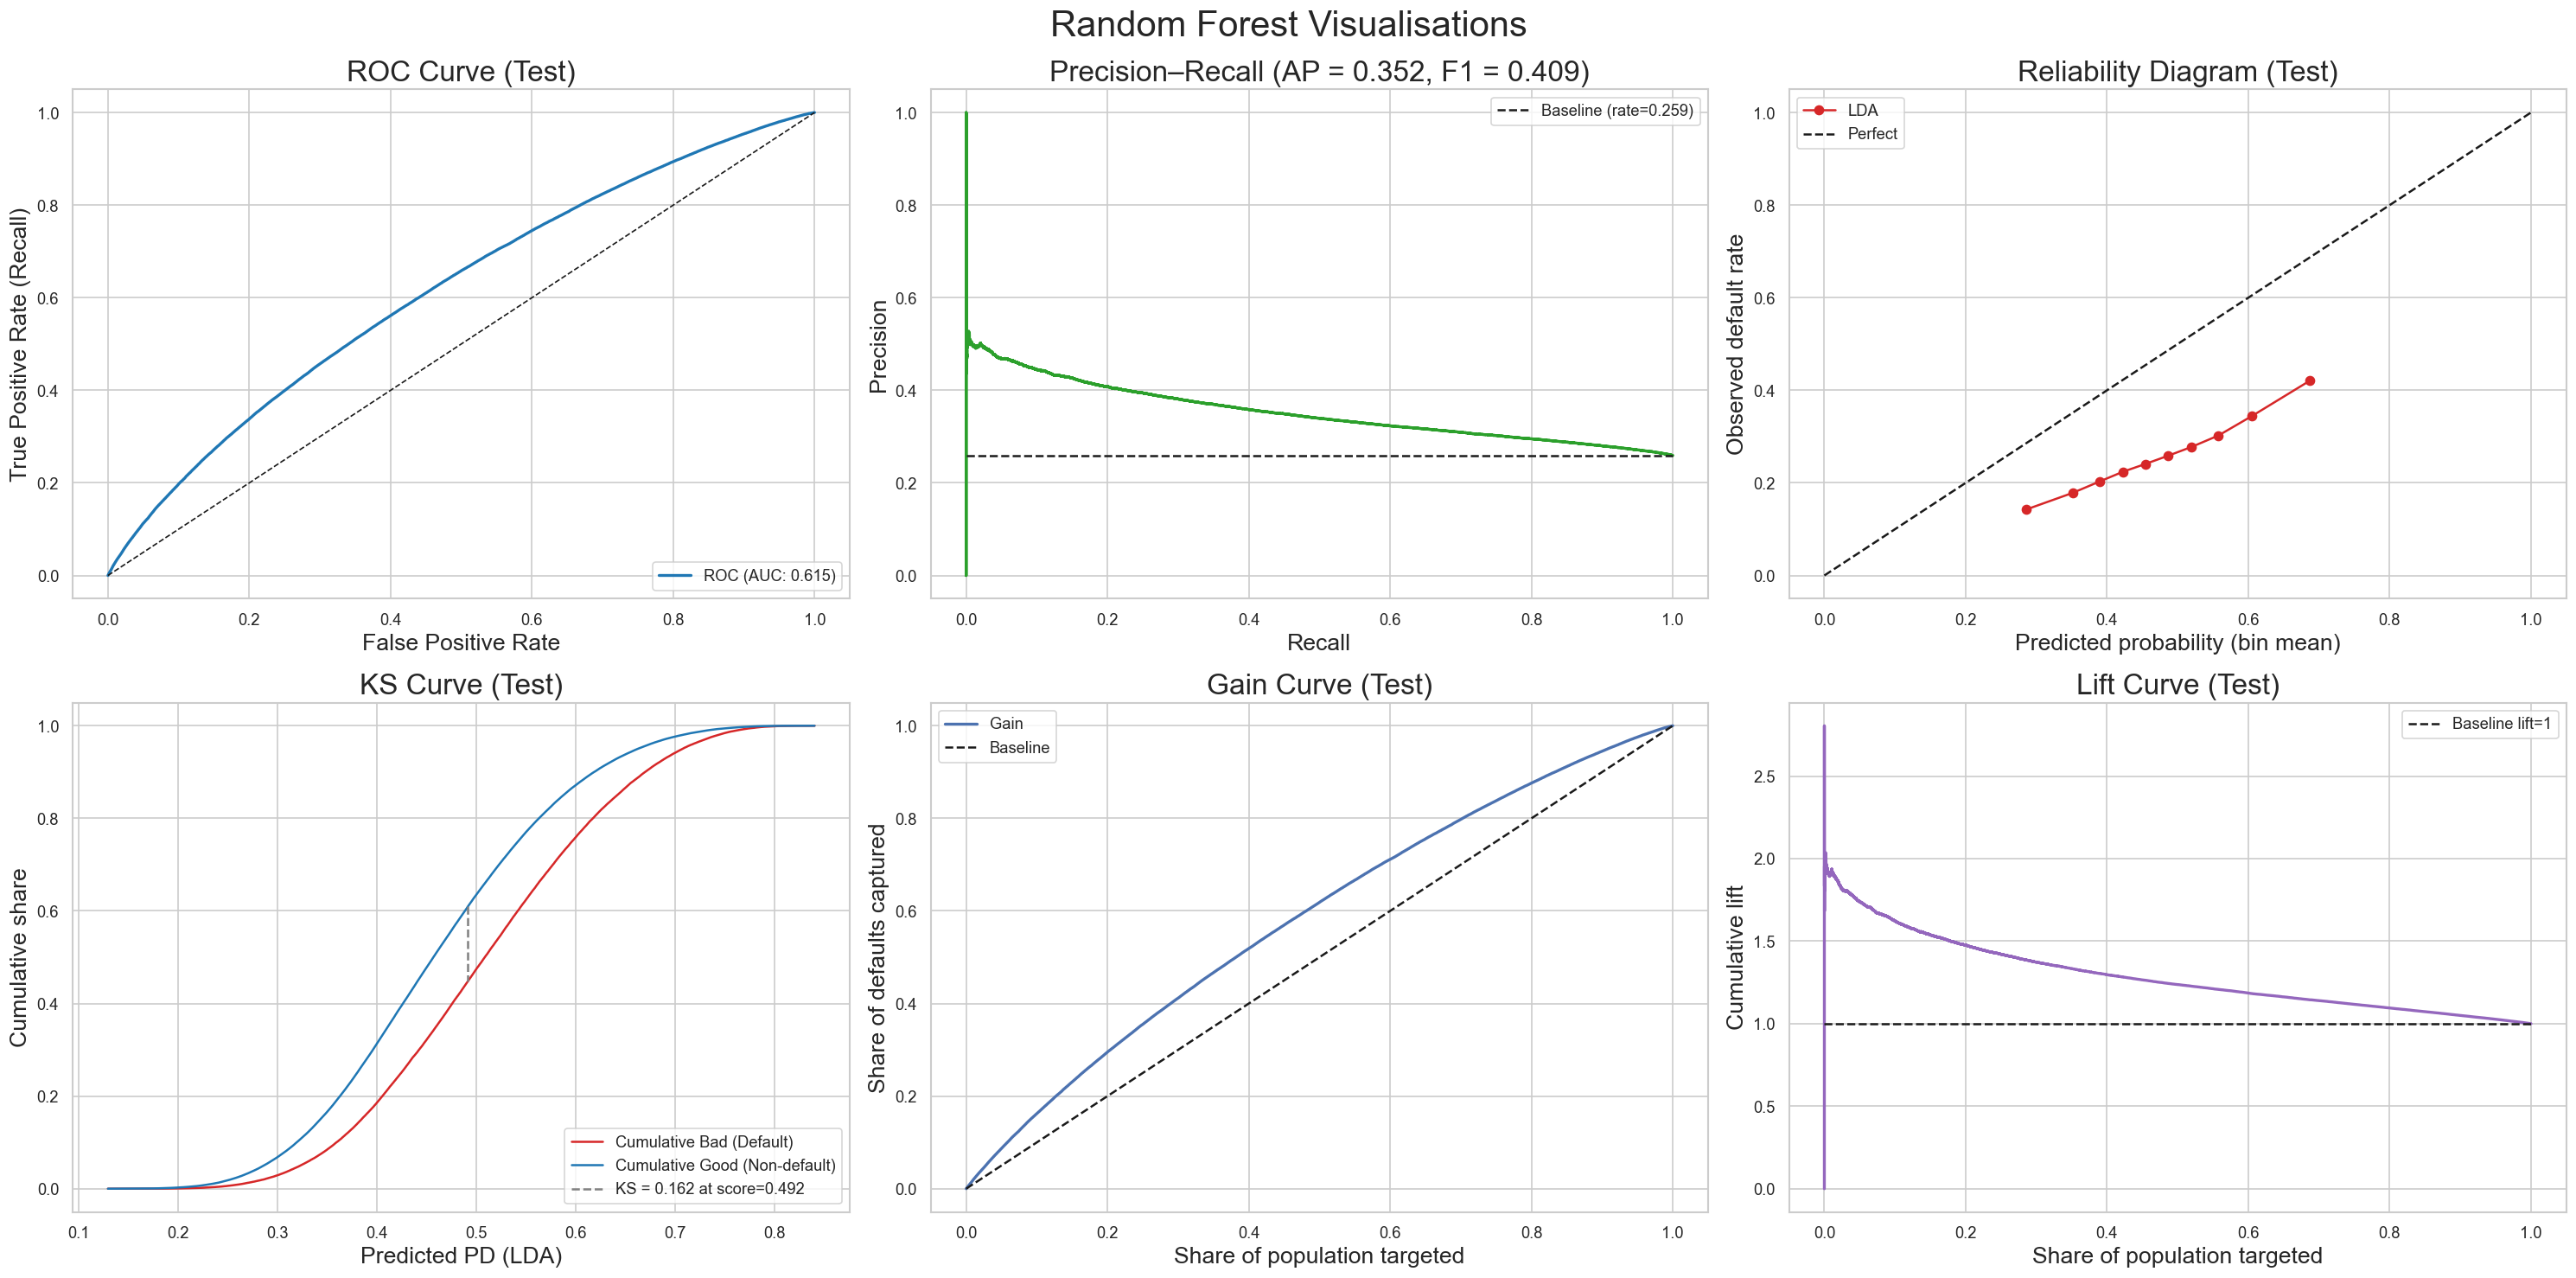

In [141]:
# Visualising the performance of the best random forest model
model_visualisation(pd_rf, "Random Forest")

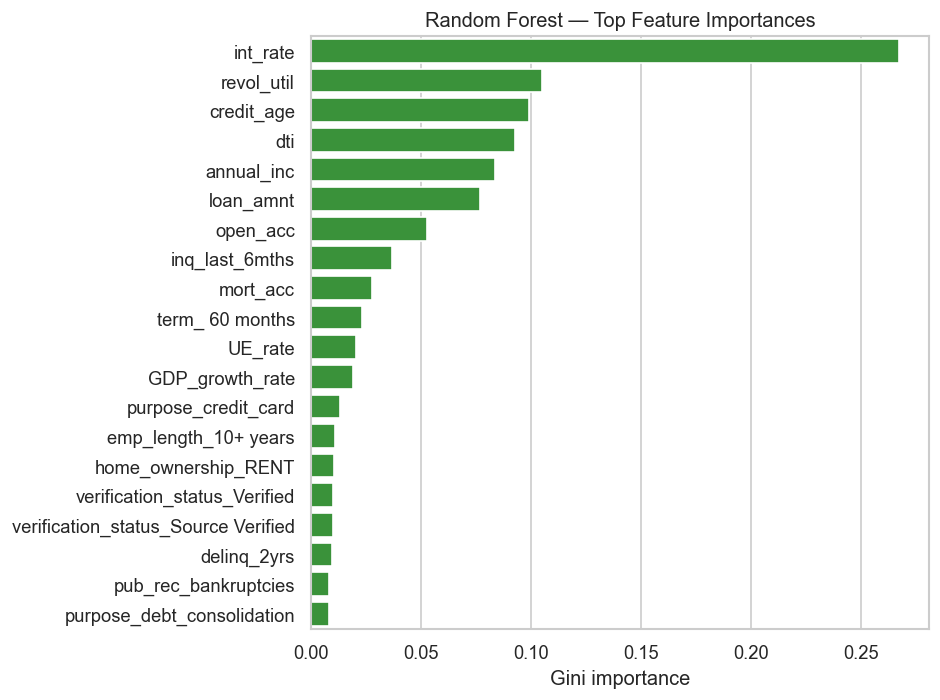

In [142]:
# Visualising the most important features for the random forest model
feature_names = x_train.columns.to_list()
imp = best_rf.feature_importances_
df_imp = pd.DataFrame({"feature": feature_names, "importance": imp})
df_imp = df_imp.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(data=df_imp, y="feature", x="importance", color="#2ca02c")
plt.title("Random Forest — Top Feature Importances")
plt.xlabel("Gini importance")
plt.ylabel("")
plt.tight_layout(); plt.show()

In [143]:
pd.DataFrame({"Metrics": metrics(y_test, pd_rf)}).T

AUC  Brier  LogLoss  Avg_PD  Avg_PD_Error  Avg_Prec  GINI  HL_Stat  \
Metrics 0.61   0.23     0.66    0.48          0.22      0.35  0.23 89752.27   

         HL_p  CalSlope  CalIntercept  Portfolio_Bad_Rate  \
Metrics  0.00      0.85         -1.01                0.26   

         Top_Decile_Bad_Rate  Lift  
Metrics                 0.42  1.62

**Overall Performance Summary**

The Random Forest model is the strongest performer among the tested models in terms of discrimination, with an AUC of 0.615 and GINI of 0.230. However, it still suffers from significant miscalibration, with an average predicted PD of 0.476 vs actual event rate of 0.259—an overshoot of ~22 percentage points. Calibration slope (0.846) is closer to 1 than other models, indicating less distortion in probability scaling, but the intercept (-1.006) and Hosmer–Lemeshow p-value (0.000) confirm poor calibration. While RF provides better ranking power and slightly improved probability behavior compared to linear and single-tree models, raw PDs remain unsuitable for governance or operational use without calibration.

Key Highlights:
- AUC: 0.615 (best among tested models)
- GINI: 0.230 (strongest so far)
- Avg PD: 0.476 vs event rate 0.259 → overprediction
- Calibration slope/intercept: 0.846 / -1.006 → miscalibration persists
- Hosmer–Lemeshow p-value: 0.000 → fails goodness-of-fit
- Top-decile lift: 1.62× → moderate risk concentration


**Discrimination**

- AUC = 0.615, GINI = 0.230: Best ranking ability among tested models, though still below the ideal threshold (≥ 0.65).
- Average Precision (AP) = 0.352: Slightly better than Decision Tree, comparable to Logit/Probit.

Interpretation: RF provides the most reliable ranking for segmentation and approval strategies among the tested models.

**Calibration**

- Avg PD = 0.476 vs event rate = 0.259: Model overpredicts PD, though less severely than Logit or DT.
- Calibration slope = 0.846 (< 1): Predictions are still too extreme but closer to ideal than other models.
- Calibration intercept = -1.006: Indicates a downward adjustment needed to align PDs.
- Hosmer–Lemeshow p-value = 0.000: Strong evidence of miscalibration across deciles.
- Brier = 0.234, LogLoss = 0.661: Better than DT and Logit, but still worse than a constant predictor at event rate (Brier ≈ 0.191, LogLoss ≈ 0.572).

Interpretation: RF is the most promising candidate for calibration; isotonic calibration should significantly improve PD fidelity.

**Lift/Gain**

- Top-decile bad rate = 0.421 vs portfolio = 0.259 → Lift = 1.62×.
- The riskiest 10% are 62% more likely to default than average.
- Implication: The model concentrates risk in top deciles, enabling decline tiers or manual review prioritization.
- Stronger models often achieve lift ≥ 2.0× and capture ≥ 60% of bads in top 40%; RF captures ~50%, which is moderate.

Interpretation: Ranking power is usable for segmentation, but further improvement is needed for high-impact risk-based strategies.

**Implications**

- Best candidate for improvement: RF offers the strongest discrimination and relatively better calibration slope, making it the most promising model for enhancement.
- Calibration required: Apply isotonic calibration on out-of-time data to achieve governance-ready PDs.

## Comparing Models

We will now compare the performance of the best models

In [144]:
results = []
results.append({"Model" : "LDA", **metrics(y_test, pd_lda)})
results.append({"Model" : "Probit", **metrics(y_test, pd_probit)})
results.append({"Model" : "Logistic (L1)", **metrics(y_test, pd_logit)})
results.append({"Model" : "Decision Tree", **metrics(y_test, pd_dt)})
results.append({"Model" : "Random Forest", **metrics(y_test, pd_rf)})

In [145]:
composite_score(pd.DataFrame(results))

Model  AUC  GINI  Brier  LogLoss  Avg_PD  Avg_PD_Error   HL_Stat  \
0  Random Forest 0.61  0.23   0.23     0.66    0.48          0.22  89752.27   
1            LDA 0.61  0.22   0.19     0.57    0.33          0.07  12933.25   
2         Probit 0.61  0.21   0.19     0.57    0.33          0.07  12872.68   
3  Logistic (L1) 0.61  0.22   0.26     0.71    0.52          0.26 138578.48   
4  Decision Tree 0.61  0.21   0.25     0.70    0.51          0.25 125193.63   

   HL_p  CalSlope  CalIntercept  CompositeScore  
0  0.00      0.85         -1.01            0.57  
1  0.00      0.70         -0.55            0.40  
2  0.00      0.72         -0.55            0.37  
3  0.00      0.71         -1.16            0.12  
4  0.00      0.66         -1.11            0.06

Random forest and LDA has the highest composite score. Thus the best random forest model will be our champion model and LDA will be our challenger model.

**Champion: Random Forest (RF)**

1) Best Discrimination:\
   AUC 0.615 / Gini 0.230 — highest among candidates → most reliable ranking for approval/pricing tiers.

3)  Promising Calibration Trajectory:\
    Calibration slope 0.846 (closest to 1) implies less distortion in the logit scale.\
    While Avg_PD overpredicts (0.476 vs 0.259), isotonic calibration typically corrects tree‑ensemble PDs effectively with limited loss of rank.

5)  Highest Probability Metrics:\
    Brier 0.234 / LogLoss 0.661 are the best of the four (still above the constant baseline, but closer than DT/Logit).

6)  Most headroom for gains with post-hoc calibration and hyperparameter tuning.

**Challenger: LDA**
1)  Reasonable Discrimination:\
    AUC 0.608 (near Logit), lift 1.652× (nearly the highest). Ranking is usable.

3)  Smaller Over‑Prediction vs Tree/Logi:\
    Avg_PD 0.332 (over by 7.3 ppt) vs RF/DT/Logit (22–26 ppt).\
    Solid Baseline with Best Raw PD Fidelity

5)  Reasonable Probability Metrics:\
    Brier 0.194 / LogLoss 0.574 — closest to the constant‑event‑rate baseline; substantially better than Logit/DT.

6) Governance‑Friendly:\
   Linear structure aids explainability. With WoE/monotonic binning and calibration, Probit can serve as a transparent baseline for model risk review.


**Not recommended (as-is): Logit and Decision Tree**
Both have severe miscalibration (Avg_PD massively above event rate), worse Brier/LogLoss than RF/Probit, and no offsetting gains in discrimination. They would materially overstate PDs for pricing/EL/capital if used without calibration.


**Future Improvements**
- Calibrate all models (time-based CV / Out-of-time)
- Isotonic calibration
- Include Decile Tables and PSI
- Apply WoE/monotonic binning to stabilize signs and include a few domain interactions to improve other model's performance.

# Phase 4: Calculating EAD and LGD

## Creating Dataset

Only a few variables are required to calculate EAD and LGD. 

These include:
- _funded_amnt_
- _int_rate_
- _out_prncp_
- _total_pymnt_
- _installment_
- _recoveries_
- _collection_recovery_fee_
- _settlement_amount_
- _settlement_percentage_
- _settlement_status_
- _settlement_term_
- _hardship_flag_
- _hardship_status_
- _term_

In [146]:
# Selecting the columns for EAD and LGD calculation
EAD_LGD_var = ["funded_amnt", "int_rate", "out_prncp", "total_pymnt", "installment" ,"recoveries", "collection_recovery_fee", "settlement_amount", 
           "settlement_percentage", "settlement_status", "settlement_term", "hardship_flag", "hardship_status", "term"]


pf_df = df[EAD_LGD_var]
pf_df

funded_amnt  int_rate  out_prncp  total_pymnt  installment  \
0               8000     12.79    2063.66      7521.68       268.75   
1              20000     17.99       0.00      7366.25       507.76   
2              10000      8.59       0.00     10962.48       316.10   
3              32200     21.49       0.00     35770.81       880.02   
4               2600      8.99       0.00      2662.59        82.67   
...              ...       ...        ...          ...          ...   
1756195        12000     14.08    8687.20      5360.96       279.72   
1756196        12000     25.82       0.00     14499.80       358.01   
1756197        10000     11.99    5993.27      5306.94       332.10   
1756198        12000     21.45    9924.69      5207.29       327.69   
1756199        16550     21.45   13541.01      7355.50       451.94   

         recoveries  collection_recovery_fee  settlement_amount  \
0              0.00                     0.00                NaN   
1           1313.11                   236.36                NaN   
2              0.00                     0.00                NaN   
3              0.00                     0.00                NaN   
4              0.00                     0.00                NaN   
...             ...                      ...                ...   
1756195        0.00                     0.00                NaN   
1756196        0.00                     0.00                NaN   
1756197        0.00                     0.00                NaN   
1756198        0.00                     0.00                NaN   
1756199        0.00                     0.00                NaN   

         settlement_percentage settlement_status  settlement_term  \
0                          NaN               NaN              NaN   
1                          NaN               NaN              NaN   
2                          NaN               NaN              NaN   
3                          NaN               NaN              NaN   
4                          NaN               NaN              NaN   
...                        ...               ...              ...   
1756195                    NaN               NaN              NaN   
1756196                    NaN               NaN              NaN   
1756197                    NaN               NaN              NaN   
1756198                    NaN               NaN              NaN   
1756199                    NaN               NaN              NaN   

        hardship_flag hardship_status        term  
0                   N             NaN   36 months  
1                   N             NaN   60 months  
2                   N             NaN   36 months  
3                   N             NaN   60 months  
4                   N             NaN   36 months  
...               ...             ...         ...  
1756195             N             NaN   60 months  
1756196             N             NaN   60 months  
1756197             N             NaN   36 months  
1756198             N             NaN   60 months  
1756199             N             NaN   60 months  

[1756200 rows x 14 columns]

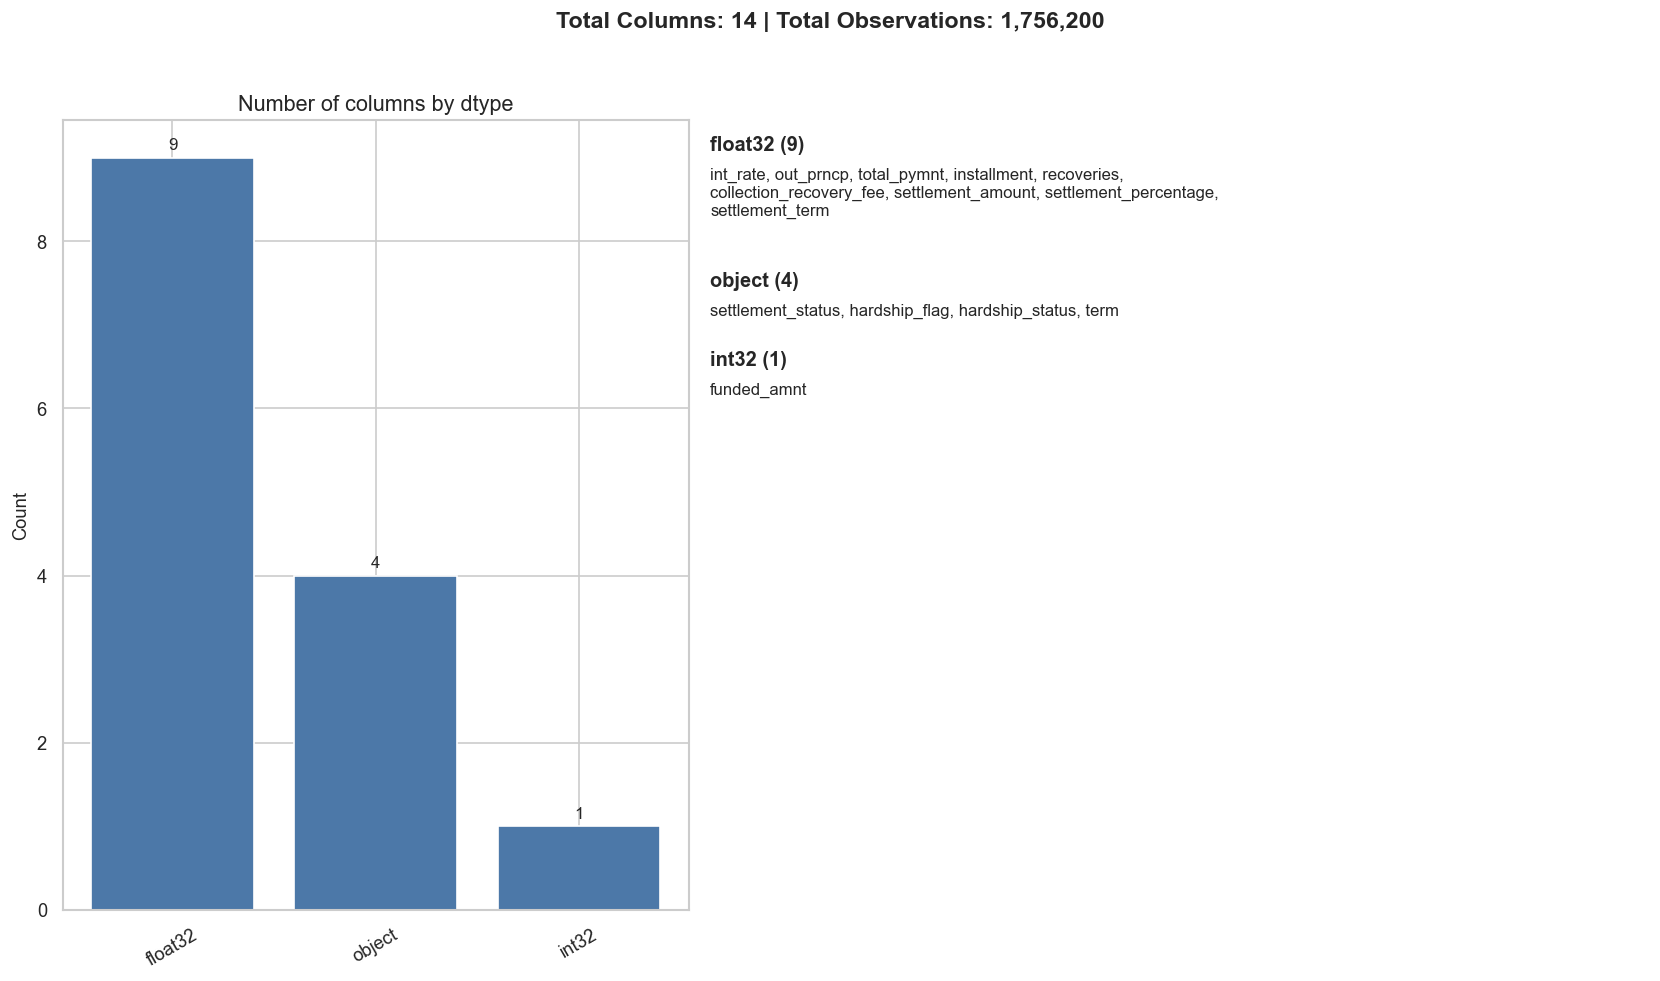

In [147]:
Plot_Dtype_Summary(pf_df)
plt.show()

term is still an object. Need to convert into numeric

## Data Exploration

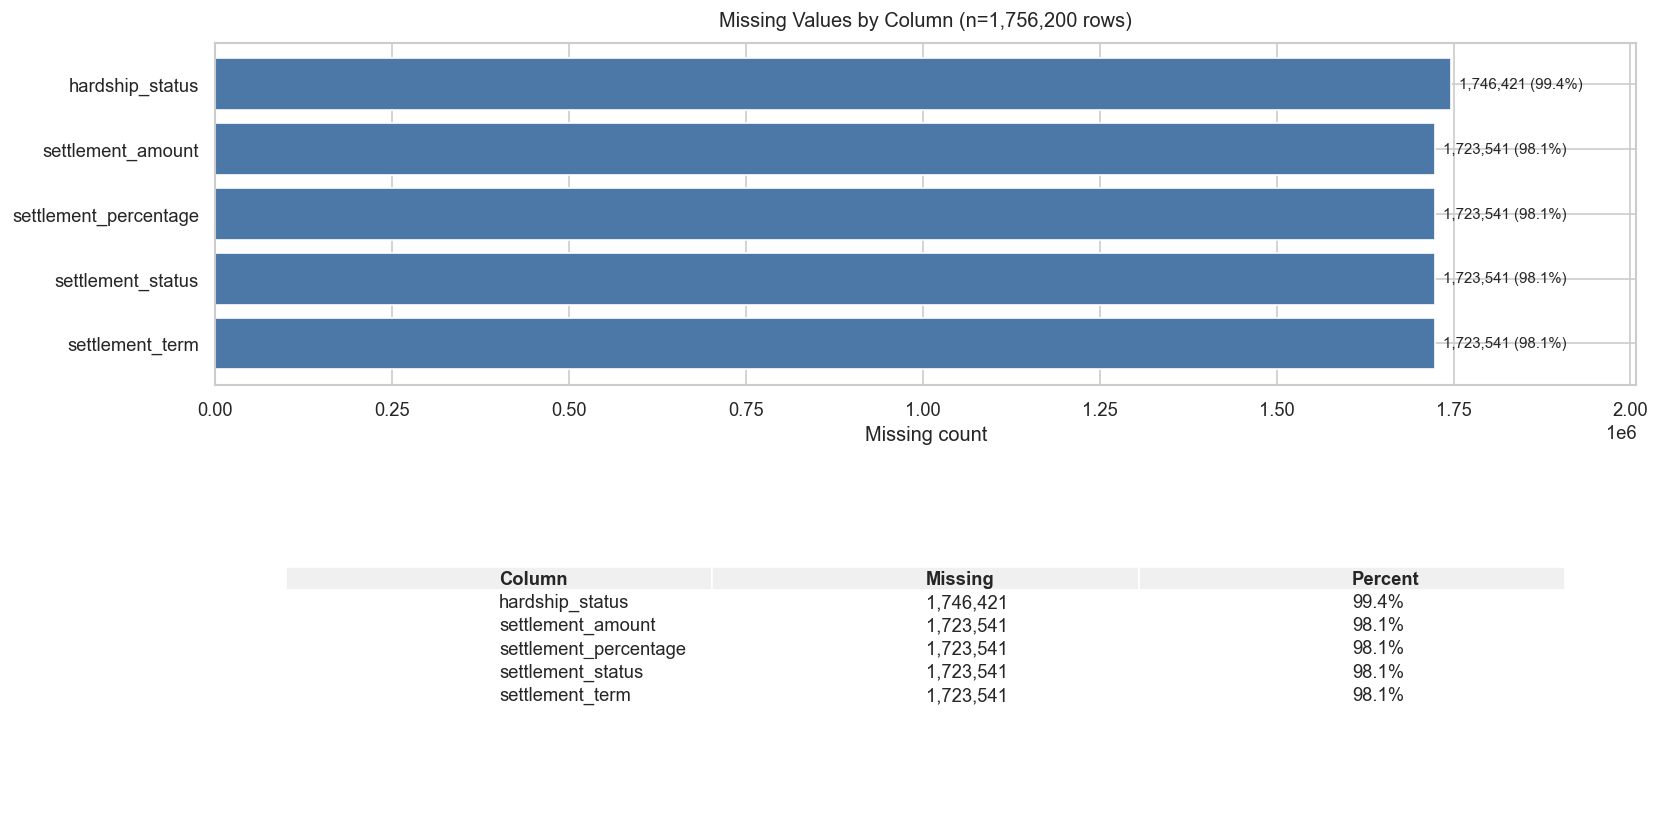

In [148]:
# Finding missing values
plot_missing_with_table(pf_df)
plt.show()

Significant amount of missing data. However, this missing data is intentional because non-default loans would not have any hardship or settlement. Impute 0.0 for missing numerical data and an empty string for missing object data

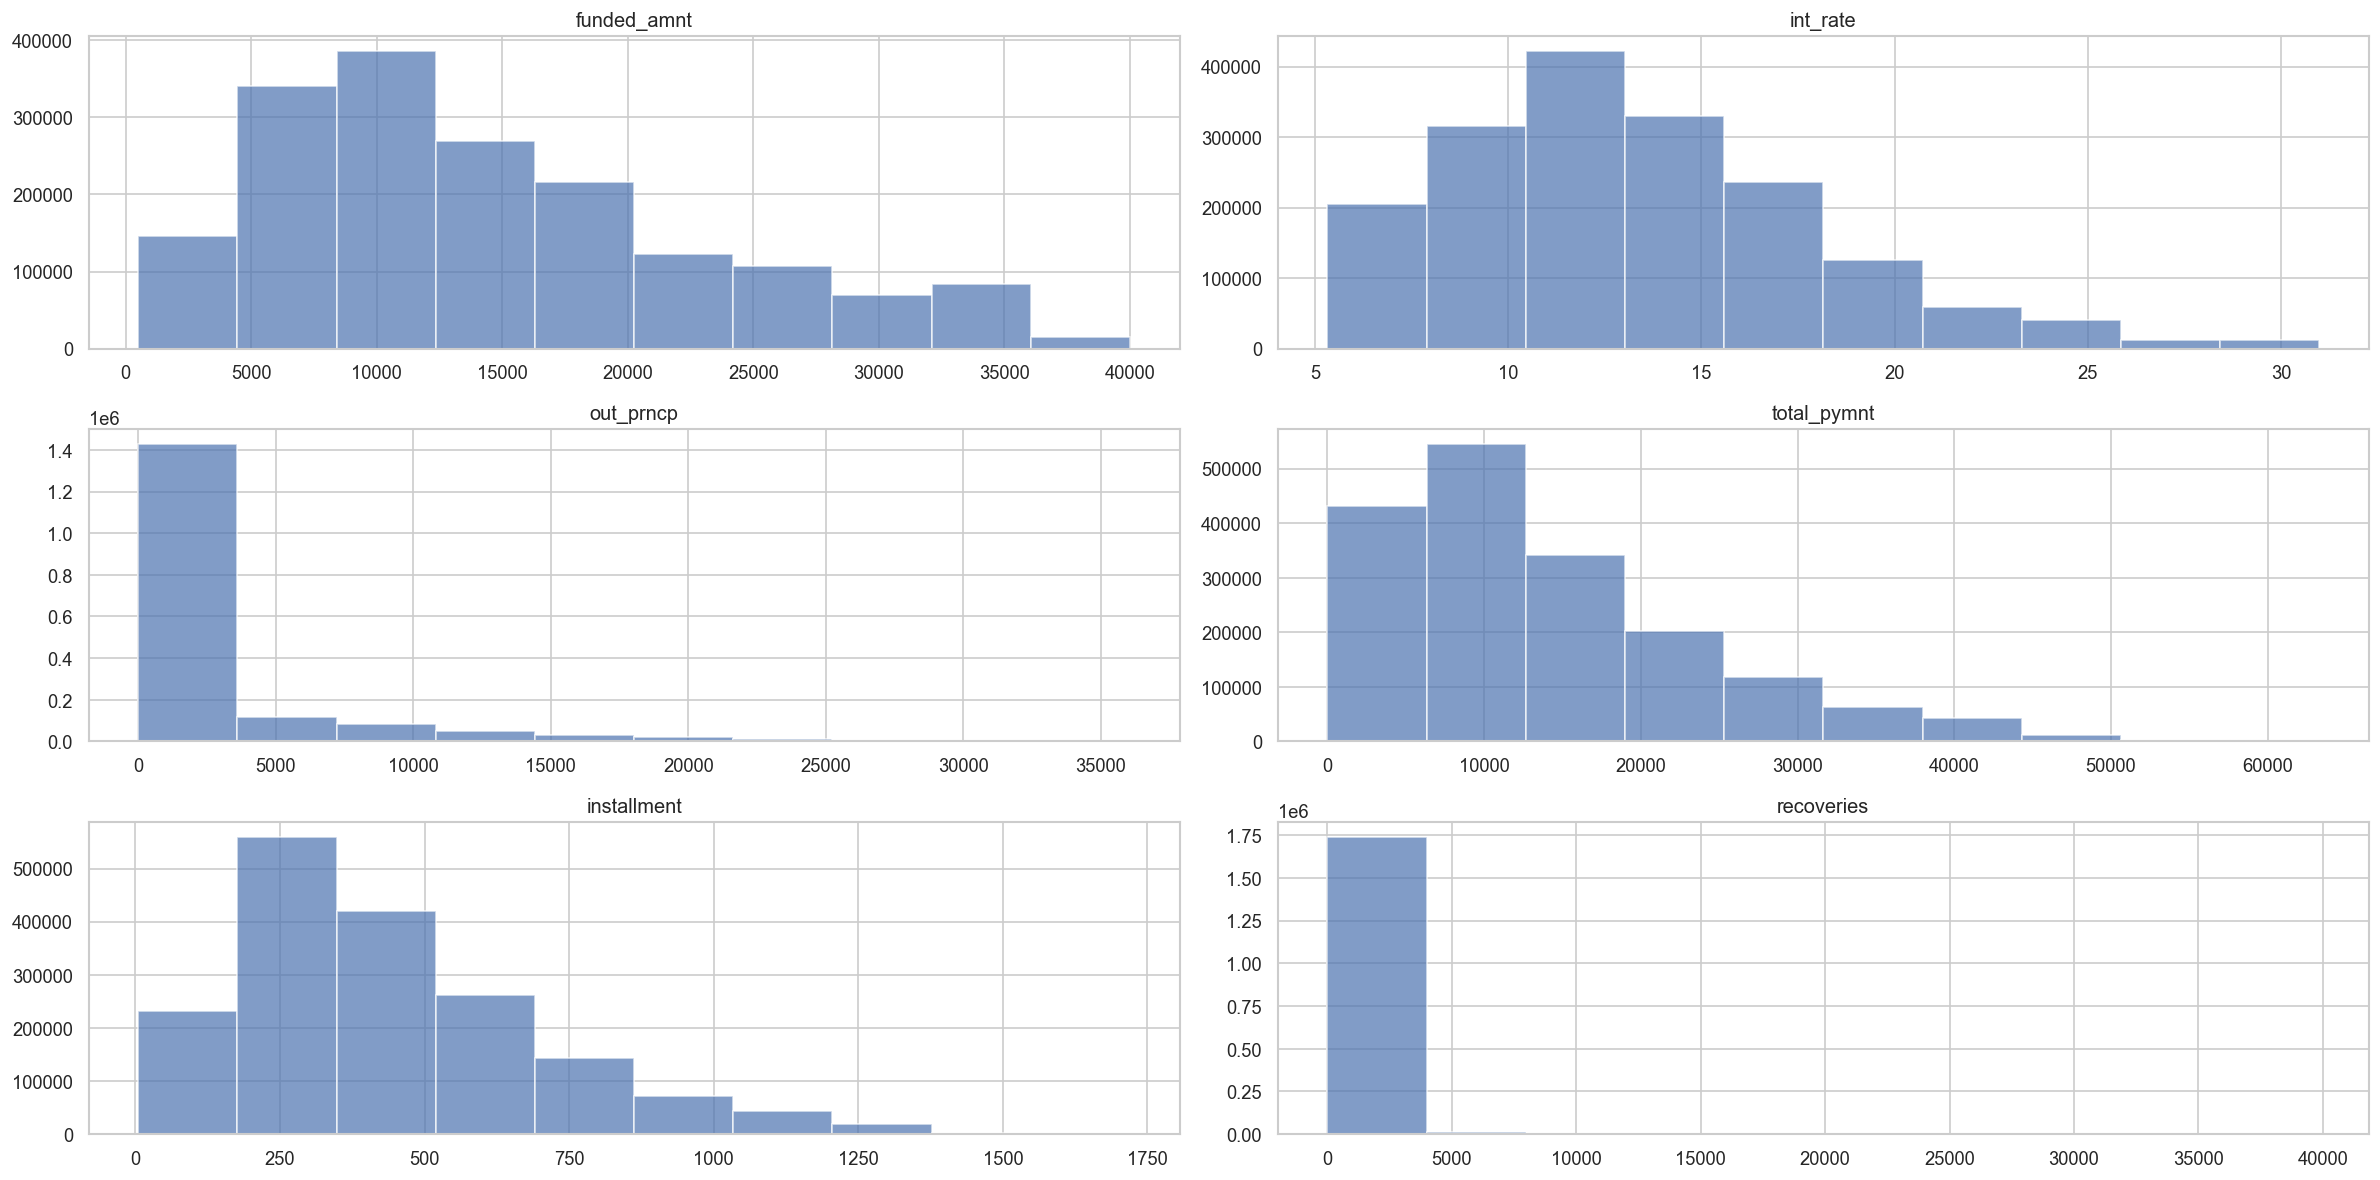

In [149]:
# Checking distribution
pf_df.iloc[:,:-8].hist(bins=10, alpha=0.7, figsize=(20, 10))
plt.tight_layout()
plt.show()

All seems to have a left skew with long right tails. Since this is only basic calculation, we do not need to apply any transformations

## Preprocessing

- _term_ will be converted into an interger value.

- _settlement_amount_ and _settlement_percentage_ will be imputed with 0.0 to coincide with non-default loans.

- _settlement_status_ and _hardship_status_ will be imputed with an empty string.

These changes will allow the EAD and LGD to be calculated

In [150]:
pf_df = pf_df.copy()

In [151]:
# Converting term into term_month (e.g. 36months -> 36, 60months -> 60)
pf_df["term_month"] = (pf_df["term"].astype(str)
                        .str.extract(r"(\d+)", expand = False)
                        .astype(int)
                       )

In [152]:
# Imputing missing values
for col in ["settlement_amount", "settlement_percentage"]:
    pf_df[col] = pf_df[col].fillna(0.0)

for col in ["settlement_status", "hardship_status"]:
    pf_df[col] = pf_df[col].astype(str).fillna("").str.strip()

## Calculating EAD

For each loan, the code will return an outstanding principal after k months by using the recorded remaining balance if available. If the remaining balance is not available, it will be reconstructed using the amortization formula. The code will then treat the remaining principal as the EAD at the chosen horizon

In [153]:
# Defining no. of payments and empty list to capture EAD values
payments_made = 12
ead_values = []

for idx, row in pf_df.iterrows():
    # Creating formula inputs for each row
    P = float(row["funded_amnt"])
    A = float(row["installment"])
    n = int(row["term_month"])
    k = min(payments_made, n)
    outp = float(row["out_prncp"])

    # Defining monthly interest rate
    r = float(row["int_rate"]) / 100.00 / 12.0

    # If there is a remaining principal, that will be the EAD
    if outp > 0.0:
        ead = outp
        ead_values.append(ead)
        continue

    # Calculating EAD based on the formula
    if r <= 0:
        ead = max(0.0, P - (P / n) * k)
    else:
        pow_k = (1.0 + r) ** k
        ead = P * pow_k - A * (pow_k - 1.0) / r
        ead = max(0.0, ead)

    # Appending calculated EAD
    ead_values.append(ead)

In [154]:
# Creating new column for EAD values
pf_df["EAD_12m"] = ead_values
pf_df

funded_amnt  int_rate  out_prncp  total_pymnt  installment  \
0               8000     12.79    2063.66      7521.68       268.75   
1              20000     17.99       0.00      7366.25       507.76   
2              10000      8.59       0.00     10962.48       316.10   
3              32200     21.49       0.00     35770.81       880.02   
4               2600      8.99       0.00      2662.59        82.67   
...              ...       ...        ...          ...          ...   
1756195        12000     14.08    8687.20      5360.96       279.72   
1756196        12000     25.82       0.00     14499.80       358.01   
1756197        10000     11.99    5993.27      5306.94       332.10   
1756198        12000     21.45    9924.69      5207.29       327.69   
1756199        16550     21.45   13541.01      7355.50       451.94   

         recoveries  collection_recovery_fee  settlement_amount  \
0              0.00                     0.00               0.00   
1           1313.11                   236.36               0.00   
2              0.00                     0.00               0.00   
3              0.00                     0.00               0.00   
4              0.00                     0.00               0.00   
...             ...                      ...                ...   
1756195        0.00                     0.00               0.00   
1756196        0.00                     0.00               0.00   
1756197        0.00                     0.00               0.00   
1756198        0.00                     0.00               0.00   
1756199        0.00                     0.00               0.00   

         settlement_percentage settlement_status  settlement_term  \
0                         0.00               nan              NaN   
1                         0.00               nan              NaN   
2                         0.00               nan              NaN   
3                         0.00               nan              NaN   
4                         0.00               nan              NaN   
...                        ...               ...              ...   
1756195                   0.00               nan              NaN   
1756196                   0.00               nan              NaN   
1756197                   0.00               nan              NaN   
1756198                   0.00               nan              NaN   
1756199                   0.00               nan              NaN   

        hardship_flag hardship_status        term  term_month  EAD_12m  
0                   N             nan   36 months          36  2063.66  
1                   N             nan   60 months          60 17288.51  
2                   N             nan   36 months          36  6947.48  
3                   N             nan   60 months          60 28178.68  
4                   N             nan   36 months          36  1809.66  
...               ...             ...         ...         ...      ...  
1756195             N             nan   60 months          60  8687.20  
1756196             N             nan   60 months          60 10649.86  
1756197             N             nan   36 months          36  5993.27  
1756198             N             nan   60 months          60  9924.69  
1756199             N             nan   60 months          60 13541.01  

[1756200 rows x 16 columns]

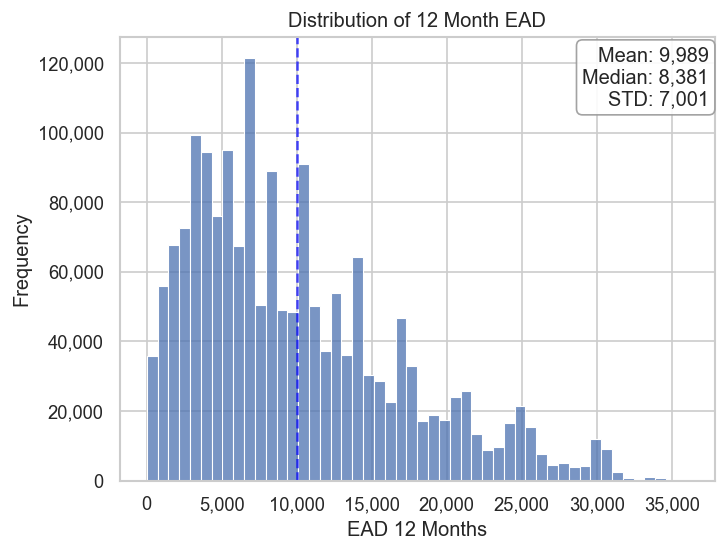

In [155]:
# Hisogram plot for EAT
sns.histplot(pf_df["EAD_12m"], bins = 50)

# Summary metrics for EAD
mean_ = pf_df["EAD_12m"].mean()
median_ = pf_df["EAD_12m"].median()
std_ = pf_df["EAD_12m"].std()

# Annotating Summary Metrics
text = f"Mean: {mean_:,.0f}\nMedian: {median_:,.0f}\nSTD: {std_:,.0f}"
plt.axvline(mean_, color = "blue", linestyle = "--", alpha = 0.7, lw = 1.5)
plt.annotate(text, xy=(0.99, 0.98), xycoords="axes fraction",
             ha="right", va="top",
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#999999", alpha=0.9))

# Chart Formatting
plt.ylabel("Frequency")
plt.xlabel("EAD 12 Months")
plt.title("Distribution of 12 Month EAD")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

EAD has a strong right skew which means that most accounts have small exposures with a small fraction having large exposures.

## Calculating LGD

The code below computes the LGD of each loan using the 12-month EAD and whichever is preferred/available between settlement and recoveries. This code also applies a hardship uplift to reflect a higher LGD under hardship

In [156]:
# Defining parameters
prefer_settlement_over_recoveries = True
hardship_lgd_uplift = 0.1
LGD_val = []

for idx, row in pf_df.iterrows():
    # Creating inputs for each row
    ead = float(row["EAD_12m"])
    if ead <= 1e-9:
        LGD_val.append(0.0)
        continue
    settlement_status = str(row.get("settlement_status", " ")).strip().lower()
    settlement_amount = float(row.get("settlement_amount", 0.0))
    settlement_pct = float(row.get("settlement_percentage", 0.0))
    recoveries = float(row.get("recoveries", 0.0))
    coll_fee = float(row.get("collection_recovery_fee", 0.0))

    # Deciding when to use settlement or recovery
    use_settlement = False
    if prefer_settlement_over_recoveries:
        if any (s in settlement_status for s in ["active", "complete"]):
            use_settlement = True
        if (settlement_amount > 0.0) or (settlement_pct > 0.0):
            use_settlement = True

    # Calculating recovery amount
    recovery = 0.0
    if use_settlement:
        if settlement_amount > 0.0:
            recovery = settlement_amount
        elif settlement_pct > 0.0:
            recovery = settlement_pct * ead
            
    if recovery <= 0.0:
        recovery = max(0.0, recoveries - max(0.0, coll_fee))

    # Calculating LGD value
    lgd = 1.0 - (recovery / max(ead, 1e-9))
    lgd = float(np.clip(lgd, 0.0, 1.0))

    # Applying hardship_lgd_uplift
    hardship_flag = str(row.get("hardship_flag", " ")).strip().lower()
    hardship_status = str(row.get("hardship_status", " ")).strip().lower()
    hardship_active = (
        hardship_flag == "y" or hardship_status in ["active"]
    )

    if hardship_lgd_uplift > 0.0 and hardship_active:
        lgd = float(np.clip(lgd * (1.0 + hardship_lgd_uplift), 0.0, 1.0))

    # Appending the LGD value to the list
    LGD_val.append(lgd)

In [157]:
# Creating new column for LGD values
pf_df["LGD"] = LGD_val
pf_df

funded_amnt  int_rate  out_prncp  total_pymnt  installment  \
0               8000     12.79    2063.66      7521.68       268.75   
1              20000     17.99       0.00      7366.25       507.76   
2              10000      8.59       0.00     10962.48       316.10   
3              32200     21.49       0.00     35770.81       880.02   
4               2600      8.99       0.00      2662.59        82.67   
...              ...       ...        ...          ...          ...   
1756195        12000     14.08    8687.20      5360.96       279.72   
1756196        12000     25.82       0.00     14499.80       358.01   
1756197        10000     11.99    5993.27      5306.94       332.10   
1756198        12000     21.45    9924.69      5207.29       327.69   
1756199        16550     21.45   13541.01      7355.50       451.94   

         recoveries  collection_recovery_fee  settlement_amount  \
0              0.00                     0.00               0.00   
1           1313.11                   236.36               0.00   
2              0.00                     0.00               0.00   
3              0.00                     0.00               0.00   
4              0.00                     0.00               0.00   
...             ...                      ...                ...   
1756195        0.00                     0.00               0.00   
1756196        0.00                     0.00               0.00   
1756197        0.00                     0.00               0.00   
1756198        0.00                     0.00               0.00   
1756199        0.00                     0.00               0.00   

         settlement_percentage settlement_status  settlement_term  \
0                         0.00               nan              NaN   
1                         0.00               nan              NaN   
2                         0.00               nan              NaN   
3                         0.00               nan              NaN   
4                         0.00               nan              NaN   
...                        ...               ...              ...   
1756195                   0.00               nan              NaN   
1756196                   0.00               nan              NaN   
1756197                   0.00               nan              NaN   
1756198                   0.00               nan              NaN   
1756199                   0.00               nan              NaN   

        hardship_flag hardship_status        term  term_month  EAD_12m  LGD  
0                   N             nan   36 months          36  2063.66 1.00  
1                   N             nan   60 months          60 17288.51 0.94  
2                   N             nan   36 months          36  6947.48 1.00  
3                   N             nan   60 months          60 28178.68 1.00  
4                   N             nan   36 months          36  1809.66 1.00  
...               ...             ...         ...         ...      ...  ...  
1756195             N             nan   60 months          60  8687.20 1.00  
1756196             N             nan   60 months          60 10649.86 1.00  
1756197             N             nan   36 months          36  5993.27 1.00  
1756198             N             nan   60 months          60  9924.69 1.00  
1756199             N             nan   60 months          60 13541.01 1.00  

[1756200 rows x 17 columns]

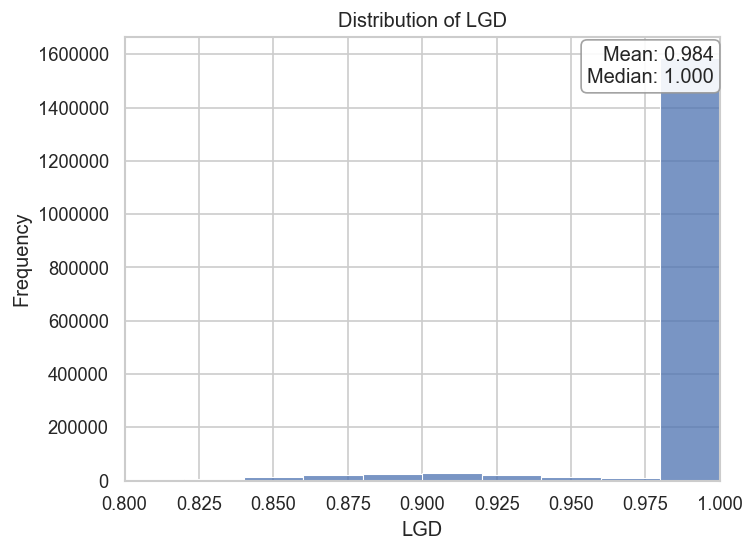

In [158]:
# Creating histogram for LGD
sns.histplot(pf_df["LGD"], bins = 50)

# Calculating summary metrics
mean_ = pf_df["LGD"].mean()
median_ = pf_df["LGD"].median()

# Applying annotation
text = f"Mean: {mean_:.3f}\nMedian: {median_:.3f}"
plt.annotate(text, xy=(0.99, 0.98), xycoords="axes fraction",
             ha="right", va="top",
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#999999", alpha=0.9))

# Chart settings
plt.ylabel("Frequency")
plt.ticklabel_format(style = "plain", axis = "y")
plt.xlabel("LGD")
plt.xlim(0.8, 1)
plt.title("Distribution of LGD")
plt.show()

LGD is extremely high with the average LGD being 0.98%. Furthermore, LGD has an extremely strong left skew with most accounts having an LGD of 1. This makes sense because all of these loans are unsecured P2P loans

# Phase 5: Scenario Analysis and ECL Calculation

## Defining Scenarios

**Overview**

Scenario analysis is a forward‑looking stress‑testing technique that evaluates how portfolio risk and performance change under alternative, plausible states of the world. It is used to quantify sensitivity of PD/EAD/LGD, pricing KPIs, losses, and capital under baseline conditions and stressed macro/borrower overlays. This helps set risk appetite, price for risk, plan capital (e.g., IFRS 9 / CECL overlays), and communicate “what‑if” outcomes to stakeholders.


**The three scenarios in this code**

- Baseline: Assumes steady‑state macro conditions (no shocks) and no borrower overlays. It serves as the control case.
- Adverse: Introduces a moderate downturn: GDP growth down, unemployment up; borrower finances worsen (income down, leverage/utilization and rates up) using small overlays.
- Severe: Applies a deep stress: larger macro shocks and proportionally stronger borrower overlays to reflect tighter affordability and higher credit strain.

In [159]:
# Defining the scenarios
scenarios = {
    "Baseline": {
        "macro": {"GDP_growth_rate": 0.0, "UE_rate": 0.0},
        "borrower": {}  # no overlays
    },
    "Adverse": {
        "macro": {"GDP_growth_rate": -2.0, "UE_rate": +1.5},
        "borrower": {
            # ("pct", v) means multiply by (1+v); ("abs", v) means add v
            "annual_inc": ("pct", -0.10),
            "dti": ("pct", +0.10),
            "revol_util": ("pct", +0.10),
            "int_rate": ("abs", +4.0)
        }
    },
    "Severe": {
        "macro": {"GDP_growth_rate": -5.0, "UE_rate": +3.0},
        "borrower": {
            "annual_inc": ("pct", -0.30),
            "dti": ("pct", +0.30),
            "revol_util": ("pct", +0.30),
            "int_rate": ("abs", +8.0)
        }
    }
}

In [160]:
# Defining the scenario clip bounds to remove any outliers
scenario_clip_bounds = {
    "GDP_growth_rate": (-10.0, 10.0),
    "UE_rate": (0.0, 50.0),
    "int_rate": (0.0, 100.0),       # annual percentage points if stored as % value
    "annual_inc": (0.0, 500_000.0),
    "dti": (0.0, 200.0),
    "revol_util": (0.0, 100.0)
}

## Calculating ECL for Each Scenario

In [161]:
# Creating empty dataframe and list to contain the results
scenario_df = pd.DataFrame()
scenario_results = []

for scenario_name, cfg in scenarios.items():
    Xs = PD_df_clip.drop(["default_12m", "issue_d"], axis = 1).copy()

    # Applying scenarios to each macro variable
    for col, delta in cfg["macro"].items():
        if col in Xs.columns:
            Xs[col] = Xs[col] + float(delta)
            if col in scenario_clip_bounds:
                lo, hi = scenario_clip_bounds[col]
                Xs[col] = Xs[col].clip(lo, hi)

    # Applying scenarios to each borrower variable
    for col, (op, val) in cfg["borrower"].items():
        if col in Xs.columns:
            if op == "pct":
                Xs[col] = Xs[col] * (1.0 + float(val))
            elif op == "abs":
                Xs[col] = Xs[col] + float(val)
            if col in scenario_clip_bounds:
                lo, hi = scenario_clip_bounds[col]
                Xs[col] = Xs[col].clip(lo, hi)

    # Applying the preprocessing functions
    X1 = Transform(Xs, transformation_dict)
    X2 = Impute(X1, impute_dict)
    X3 = OHE(X2, ohe_var)
    X4 = X3.drop(["avg_cur_bal", "real_int_rate", "infl_rate"], axis = 1)
    X5 = Scale(X4, scale_col)

    # Predicting the PD for each scenario
    pd_rf_s  = best_rf.predict_proba(X5)[:, 1]
    pd_lda_s = lda.predict_proba(X5)[:, 1]

    # Defining the LGD and EAD
    lgd_vec = pf_df["LGD"].values
    ead_vec = pf_df["EAD_12m"].values

    # Calculating the ECL for each scenario
    ecl_rf_s  = pd_rf_s  * lgd_vec * ead_vec
    ecl_lda_s = pd_lda_s * lgd_vec * ead_vec

    # Calculating the total ECL for each scenario
    total_ecl_rf = float(np.sum(ecl_rf_s))
    total_ecl_lda = float(np.sum(ecl_lda_s))

    # Appending the PD and ECL for each scenario
    scenario_df[f"{scenario_name}_rf_ecl"] = ecl_rf_s
    scenario_df[f"{scenario_name}_lda_ecl"] = ecl_lda_s
    scenario_df[f"{scenario_name}_rf_pd"] = pd_rf_s
    scenario_df[f"{scenario_name}_lda_pd"] = pd_lda_s

    # Appending the results for each scenario
    scenario_results.append({
        "Scenario": scenario_name,
        "Total_ECL_RF_12m": total_ecl_rf,
        "Total_ECL_LDA_12m": total_ecl_lda,
        "Avg_PD_RF_12m": float(np.mean(pd_rf_s)),
        "Avg_PD_LDA_12m": float(np.mean(pd_lda_s)),
        "Avg_LGD": float(np.mean(lgd_vec)),
        "Avg_EAD_12m": float(np.mean(ead_vec))
    })

In [162]:
scenario_df

Baseline_rf_ecl  Baseline_lda_ecl  Baseline_rf_pd  Baseline_lda_pd  \
0                 936.06            694.78            0.45             0.34   
1                9950.86           7155.53            0.61             0.44   
2                3421.88           2095.94            0.49             0.30   
3               18196.70          13515.04            0.65             0.48   
4                 787.14            536.59            0.43             0.30   
...                  ...               ...             ...              ...   
1756195          4159.86           3086.66            0.48             0.36   
1756196          7639.80           6549.07            0.72             0.61   
1756197          2567.82           1610.64            0.43             0.27   
1756198          6974.44           5335.50            0.70             0.54   
1756199          9601.32           7075.76            0.71             0.52   

         Adverse_rf_ecl  Adverse_lda_ecl  Adverse_rf_pd  Adverse_lda_pd  \
0                939.92           687.46           0.46            0.33   
1               9962.31          7166.28           0.61            0.44   
2               3412.62          2100.17           0.49            0.30   
3              18185.08         13656.58           0.65            0.48   
4                792.42           536.71           0.44            0.30   
...                 ...              ...            ...             ...   
1756195         4241.35          3060.92           0.49            0.35   
1756196         7644.43          6677.27           0.72            0.63   
1756197         2522.01          1588.67           0.42            0.27   
1756198         7032.13          5388.28           0.71            0.54   
1756199         9606.17          7141.82           0.71            0.53   

         Severe_rf_ecl  Severe_lda_ecl  Severe_rf_pd  Severe_lda_pd  
0               933.26          679.32          0.45           0.33  
1              9987.67         7175.16          0.62           0.44  
2              3452.58         2127.85          0.50           0.31  
3             18116.29        13675.53          0.64           0.49  
4               795.93          544.96          0.44           0.30  
...                ...             ...           ...            ...  
1756195        4245.15         3038.58          0.49           0.35  
1756196        7626.41         6776.51          0.72           0.64  
1756197        2517.20         1550.38          0.42           0.26  
1756198        7032.36         5416.53          0.71           0.55  
1756199        9658.32         7144.21          0.71           0.53  

[1756200 rows x 12 columns]

In [163]:
# Applying formatting to scenario results
scenario_summary = pd.DataFrame(scenario_results)

scenario_summary_fmt = scenario_summary.copy()
scenario_summary_fmt["Total_ECL_RF_12m"]  = scenario_summary_fmt["Total_ECL_RF_12m"].map(lambda x: f"{x:,.2f}")
scenario_summary_fmt["Total_ECL_LDA_12m"] = scenario_summary_fmt["Total_ECL_LDA_12m"].map(lambda x: f"{x:,.2f}")
scenario_summary_fmt["Avg_PD_RF_12m"]     = scenario_summary_fmt["Avg_PD_RF_12m"].map(lambda x: f"{x:.2%}")
scenario_summary_fmt["Avg_PD_LDA_12m"]    = scenario_summary_fmt["Avg_PD_LDA_12m"].map(lambda x: f"{x:.2%}")
scenario_summary_fmt["Avg_LGD"]           = scenario_summary_fmt["Avg_LGD"].map(lambda x: f"{x:.0%}")
scenario_summary_fmt["Avg_EAD_12m"]       = scenario_summary_fmt["Avg_EAD_12m"].map(lambda x: f"{x:,.2f}")

scenario_summary_fmt

Scenario  Total_ECL_RF_12m Total_ECL_LDA_12m Avg_PD_RF_12m Avg_PD_LDA_12m  \
0  Baseline  8,072,043,801.12  5,436,153,770.39        46.07%         30.77%   
1   Adverse  8,050,912,668.24  5,438,223,478.66        45.95%         30.76%   
2    Severe  8,043,435,239.28  5,438,383,134.76        45.92%         30.75%   

  Avg_LGD Avg_EAD_12m  
0     98%    9,989.13  
1     98%    9,989.13  
2     98%    9,989.13

In [164]:
print(f'{df["loan_amnt"].sum():,.2f}')

25,925,451,625.00


In [165]:

def ECL_Chart (df):
    # Compute % increases vs Baseline per model
    baseline_lda = df.loc[df['Scenario']=='Baseline','Total_ECL_LDA_12m'].values[0]
    baseline_rf  = df.loc[df['Scenario']=='Baseline','Total_ECL_RF_12m'].values[0]

    pct_vs_base_lda = (df['Total_ECL_LDA_12m'] - baseline_lda) / baseline_lda * 100
    pct_vs_base_rf  = (df['Total_ECL_RF_12m']  - baseline_rf)  / baseline_rf  * 100

    # Plot settings
    mpl.rcParams['axes.titlesize'] = 14
    mpl.rcParams['axes.labelsize'] = 12
    mpl.rcParams['xtick.labelsize'] = 11
    mpl.rcParams['ytick.labelsize'] = 11

    # Extracting key information
    scenarios = df['Scenario'].tolist()
    lda_ecl = df['Total_ECL_LDA_12m'].to_numpy()
    rf_ecl  = df['Total_ECL_RF_12m'].to_numpy()

    x = np.arange(len(scenarios))
    width = 0.38

    fig, ax = plt.subplots(figsize=(9, 5.5))
    bar1 = ax.bar(x - width/2, lda_ecl, width, label='LDA', color='#1f77b4')
    bar2 = ax.bar(x + width/2, rf_ecl, width, label='Random Forest', color='#ff7f0e')

    # Labels and title (raise title to avoid clipping)
    ax.set_title('Portfolio ECL (12-month): LDA vs Random Forest by Scenario', pad=20)
    ax.set_xlabel('Scenario')
    ax.set_ylabel('ECL (USD)')
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios)
    ax.legend(loc = "upper left", frameon = True, fontsize = 9)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Annotate bars with % increase vs Baseline
    # Baseline gets no label; Adverse/Severe show +x.xx%
    max_height = max(lda_ecl.max(), rf_ecl.max())

    for i, rect in enumerate(bar1):
        height = rect.get_height()
        if scenarios[i] != 'Baseline':
            pct = pct_vs_base_lda.iloc[i]
            ax.text(rect.get_x() + rect.get_width()/2,
                    height + max_height*0.02,
                    f"{pct:+.2f}% vs Baseline",
                    ha='center', va='bottom', fontsize=8, color='#1f77b4')

    for i, rect in enumerate(bar2):
        height = rect.get_height()
        if scenarios[i] != 'Baseline':
            pct = pct_vs_base_rf.iloc[i]
            ax.text(rect.get_x() + rect.get_width()/2,
                    height + max_height*0.02,
                    f"{pct:+.2f}% vs Baseline",
                    ha='center', va='bottom', fontsize=8, color='#ff7f0e')
    # Y-axis formatting
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1_000_000_000:,.0f} Billion'))
    
    plt.subplots_adjust(top=0.88)
    fig.tight_layout()
    
    plt.show()

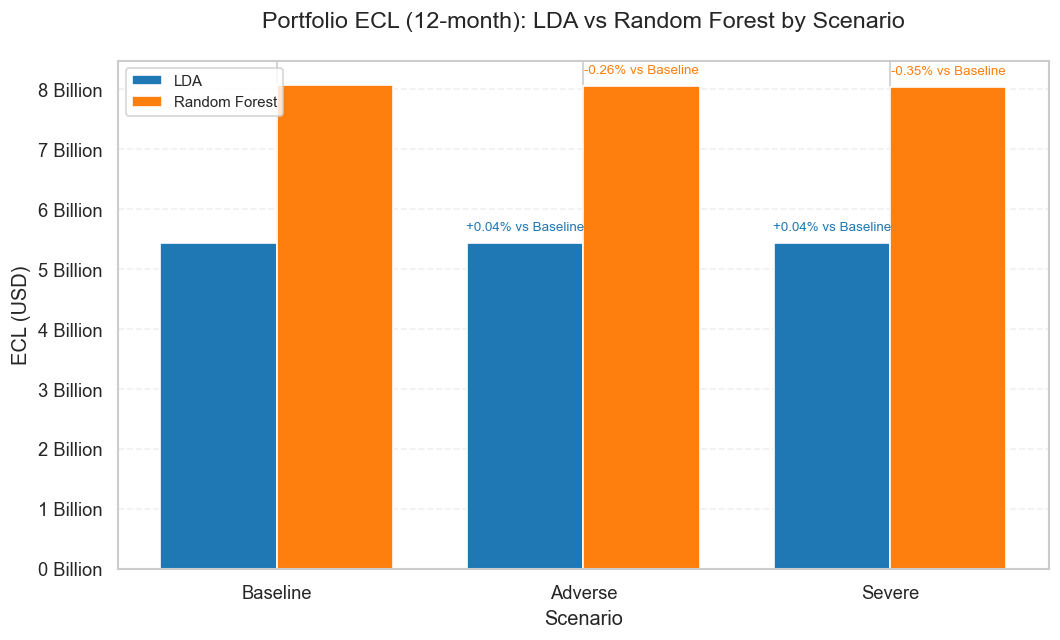

In [166]:
ECL_Chart(scenario_summary)

Based on the chart above, the RF model predicts a much higher ECL compared to the LDA model for every scenario indicating that the RF model tends to overpredict PDs as pointed out before. 

For the LDA model, the adverse and severe model increase by the same amount despite having very different input variables. This means that the LDA model is extremely insensitive to different real-world scenarios and would not be able to accurately predict PD in other scenarios.

For the RF model, the more harsh the scenario, the seemingly less ECL the model predicts, which does not make intuitive sense since harsher variables would result in more defaults and higher PDs. This means that the RF is non-monotonic and more calibration is needed to turn it monotonic

Both these outcomes highlight that the models only have moderate discriminatory power and are extremely miscalibrated and are unable to accurately predict ECL in different scenarios.

# Phase 6: VaR and CVaR

## Monte Carlo Simulation for VaR and CVaR Calculation

Monte Carlo simulation estimates portfolio loss distributions by randomly sampling many paths for key drivers (defaults, recoveries, exposures, macro shocks) based on their statistical properties and correlations. Running thousands of trials yields an empirical loss distribution from which tail risk measures are extracted.

Value at Risk (VaR\alphaα): a quantile of the loss distribution—e.g., 99% VaR is the loss level exceeded in only 1% of scenarios. It answers: “How bad can losses get with α\alphaα% confidence?”

Conditional Value at Risk (CVaR\alpha) (a.k.a. Expected Shortfall): the average loss given that losses exceed VaR\alpha. It captures tail severity, not just the cutoff. CVaR is often preferred for capital and stress management because it is coherent and more sensitive to tail risk.

For this project, we will be performing 10,000 simulations

In [169]:
# Defining the number of simulations and alphas
n_sims = 10_000
alphas = [0.95, 0.99]
rng = np.random.default_rng(123)
mc_rows = []

In [172]:
for scenario_name, cfg in scenarios.items():
    # Determining the EAD and LGD
    ead_vec = pf_df["LGD"]
    lgd_vec = pf_df["EAD_12m"]

    # Creating the RNG
    rng = np.random.default_rng(123)

    # Creating the empty arrays
    losses_rf = np.empty(n_sims, dtype = float)
    losses_lda = np.empty(n_sims, dtype = float)

    # Creating the Monte-Carlo simulation
    for i in range(n_sims):
        defaults_rf = rng.binomial(1, scenario_df[f"{scenario_name}_rf_pd"])
        defaults_lda = rng.binomial(1, scenario_df[f"{scenario_name}_lda_pd"])
        losses_rf[i] = float(np.sum(defaults_rf * ead_vec * lgd_vec))
        losses_lda[i] = float(np.sum(defaults_lda * ead_vec * lgd_vec))

    # Determining the VaR and CVaR for each alpha
    for alpha in alphas:
        var_rf = float(np.quantile(losses_rf, alpha))
        var_lda = float(np.quantile(losses_lda, alpha))
        cvar_rf = float(losses_rf[losses_rf >= var_rf].mean())
        cvar_lda = float(losses_lda[losses_lda >= var_lda].mean())

        # Appending results
        mc_rows.append({
            "Scenario" : scenario_name,
            "Alpha" : alpha,
            "VaR_RF" : var_rf,
            "CVaR_RF" : cvar_rf,
            "VaR_LDA" : var_lda,
            "CVaR_LDA" : cvar_lda
        })

In [173]:
# Creating the summary table and applying formating
mc_summary = pd.DataFrame(mc_rows)

for c in ["VaR_RF", "CVaR_RF", "VaR_LDA", "CVaR_LDA"]:
    mc_summary[c] = mc_summary[c].map(lambda x : f"{x:,.0f}")

mc_summary

Scenario  Alpha         VaR_RF        CVaR_RF        VaR_LDA       CVaR_LDA
0  Baseline   0.95  8,084,631,156  8,087,780,838  5,447,637,395  5,450,834,386
1  Baseline   0.99  8,089,807,141  8,092,387,912  5,452,745,466  5,455,647,064
2   Adverse   0.95  8,063,456,902  8,066,709,306  5,449,758,265  5,452,907,537
3   Adverse   0.99  8,068,856,398  8,071,268,611  5,454,678,424  5,457,593,312
4    Severe   0.95  8,055,982,356  8,059,094,197  5,449,995,737  5,453,137,181
5    Severe   0.99  8,061,140,343  8,063,529,376  5,455,080,536  5,457,792,966

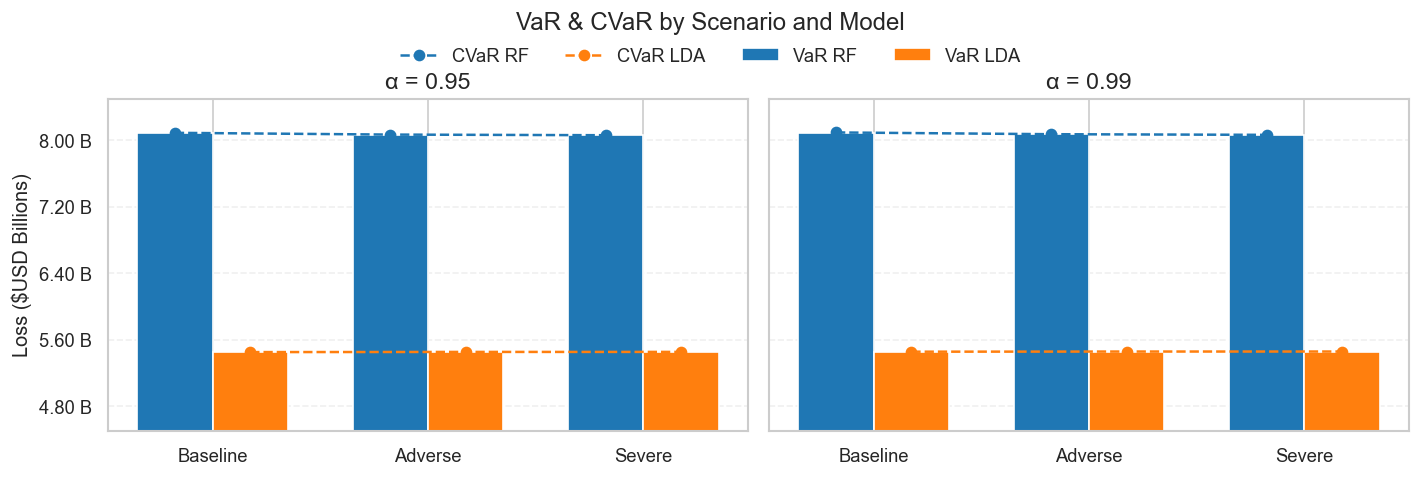

In [174]:
# Sort scenarios in preferred order
mc_bar_df = pd.DataFrame(mc_rows)
scenario_order = ['Baseline', 'Adverse', 'Severe']
mc_bar_df['Scenario'] = pd.Categorical(mc_bar_df['Scenario'], categories=scenario_order, ordered=True)
mc_bar_df = mc_bar_df.sort_values(['Scenario','Alpha'])

# Build grouped bar chart per alpha (two subplots: 95% and 99%)
fig, axes = plt.subplots(1, len(mc_bar_df['Alpha'].unique()), figsize=(12, 4), sharey=True)
for j, alpha in enumerate(sorted(mc_bar_df['Alpha'].unique())):
    ax = axes[j]
    sub = mc_bar_df[mc_bar_df['Alpha'] == alpha]

    x = np.arange(len(scenario_order))
    width = 0.35

    # Bars: VaR RF vs LDA
    ax.bar(x - width/2, sub['VaR_RF'].values, width, label='VaR RF', color='#1f77b4')
    ax.bar(x + width/2, sub['VaR_LDA'].values, width, label='VaR LDA', color='#ff7f0e')

    # Overlay line markers for CVaR (same x positions)
    ax.plot(x - width/2, sub['CVaR_RF'].values, marker='o', color='#1f77b4', linestyle='--', label='CVaR RF' if j==0 else None)
    ax.plot(x + width/2, sub['CVaR_LDA'].values, marker='o', color='#ff7f0e', linestyle='--', label='CVaR LDA' if j==0 else None)

    ax.set_xticks(x)
    ax.set_xticklabels(scenario_order)
    ax.set_title(f'α = {alpha:.2f}')
    ax.set_ylabel('Loss ($USD Billions)' if j == 0 else '')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

# Single legend
handles, labels = axes[0].get_legend_handles_labels()
ax.yaxis.set_major_locator(MaxNLocator(nbins = 6))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos : f'{v/1_000_000_000:,.2f} B'))
fig.legend(handles, labels, loc='upper center', ncol=4, frameon=False, bbox_to_anchor = (0.5, 0.95))
fig.suptitle('VaR & CVaR by Scenario and Model', y=0.99)
plt.ylim(4_500_000_000, None)
plt.subplots_adjust(top=1, wspace=1)
plt.tight_layout()
plt.show()

For the RF model, tail losses seem to decrease slightly as scenarios get harsher. This is counter-intuitive for stress testing and strongly suggests a non-monotone PD response. The LDA model's tail losses are slightly higher than the baseline scenario under stress. Although this is a sensible direction, the changes are still very small. Across all scenarios/alphas, RF's VaR and CVaR are higher than LDA. This is consistent with the earlier findings that RF produces higher than average PDs. Additionally, the CVaR is not significantly higher than the VaR which might imply thin tailed distributions with losses more normally distributed and extreme deviations are rare and minimal.

# Conclusion

The original aim of this project was to design and implement an end‑to‑end IFRS 9/Basel‑compliant retail/P2P credit risk framework using LendingClub loan histories enriched with macro indicators (GDP growth, unemployment). 

The pipeline in this project covers: 

- data ingestion and preprocessing (censoring vintages, creating appropriate target variable, clipping, imputation, OHE, standard scaling, etc.)
- PD modelling (trained LDA, Probit, Logit, Decision Tree and Random Forest models with time-split vintages. Procuded full diagnostics and governance curve to evaluate and select best models) 
- EAD/LGD estimation)
- 12‑month ECL computation under Baseline/Adverse/Severe scenarios 
- Monte Carlo portfolio loss simulations to quantify VaR/CVaR tail‑risk (95%, 99%) per scenario and model.
- Various visualisations at each stage of the pipeline

However, there are significant issues with this project including major miscalibrations across all the models that mean the PDs are unreliable and unfit for governance or operational use since their will inflate the ECL and capital. Furthermore, the champion RF model has major directional stress anomalies where under harsher scenarios, the VaR/CVaR dipped slighlty which is counter-intuitive and indicates a non-monotonic response. Finally, there was only limited discrimination ability with the highest AUC still being below typival consumer PD targets. 

Despite these significant issues, the original aim was still partially achieved. The project still shows framework completeness with an end-to-end pipeline that is governance-minded with defensive clipping, time-splits, leakage controls, macro overlays and tail-risk simulations. Furthermore, stress-testing scenarios and monte carlo VaR and CVaR simulations are implemented and working. Despite the poor calibration, these models were still able to achieve modest discrimination. Finally, the composite score created using weighted performance metrics allows for easily comparable diagnostics between models.

For future improvements to this project, the models need to be better calibrated with isotonic calibration for ensemble models and logistic or Platt recalibration for linear models using time-based CV / out-of-time data. Furthermore, WoE or monotonic binning might be considered for key continuous drivers to stabilize signs and performance under stress. Additionally, macro linkages could be added to strengthen macro sensitivity by adding lagged macro features or regime indicators. Finally, this project might be improved by adding decile tables, PSI, stability and drift checks across vintages. 

**Notes**

In conclusion, I had a good time learning performing this project over the holidays. It was a good refresher for old subjects I covered in uni and I was also able to learn plenty of new concepts and coding techniques such as monte carlo simulations, scenario analysis, EAD/LGD calculations and LDA models. Despite the overall poor performance of the models and by extension, the project, I am still very happy with its outcome simply due to the exposure it has provided to the credit modelling field. I look forward to improving upon this project in the future.